In [1]:
_version_ = 12

In [2]:
global NUM
NUM = 0

In [3]:
#import Necessary Libraries
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras import layers
import os
import cv2 as cv
import matplotlib.pyplot as plt
policy = tf.keras.mixed_precision.Policy('float32')
tf.keras.mixed_precision.set_global_policy(policy)

In [4]:
#define Loss function
def ssim(y_true, y_pred):
    ssim_value = tf.image.ssim(y_true, y_pred, max_val=1.0)
    return (1- ssim_value)

In [5]:
#Create Dataset
# X = np.zeros((17824, 256, 256, 3),dtype=np.float32)
# count = 0
# folder_path = "x//"
# for filename in os.listdir(folder_path):
#     img = cv.imread(folder_path+"//"+filename)
#     X[count] = ((img / 127.5)-1)
#     count+=1
# np.save('D://X.npy',X)

In [6]:
# y = np.zeros((17824, 256, 256, 3),dtype=np.float32)
# count = 0
# folder_path = "y//"
# for filename in os.listdir(folder_path):
#     img = cv.imread(folder_path+"//"+filename)
#     y[count] = ((img/127.5)-1)
#     count+=1
# np.save('D://y.npy',y)

In [7]:
#Hyperparameters
class CFG:
    IMG_WIDTH = 256
    IMG_HEIGHT = 256
    #the lambda param in loss
    LAMBDA = 100
    #train pipe
    BUFFER_SIZE = 500

In [8]:
#define genrator
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
    '''performs a downsampling of the input image by applying a CONV2D layer with stride of 2'''
    initializer = tf.random_normal_initializer(0., 0.035)

    result = tf.keras.Sequential()
    
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result
def upsample(filters, size, apply_dropout=False):
    '''performs a upsampling of the input image by applying a CONV2DTranspose layer with stride of 2'''

    initializer = tf.random_normal_initializer(0., 0.035)

    result = tf.keras.Sequential()
    result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:    
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result
def Generator():
    inputs = tf.keras.layers.Input(shape=[256, 256, 3])

    down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]

    up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    
    #list to store skip connections
    skips = []
    
    
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        
        #skip connection from the downsampling
        x = tf.keras.layers.Concatenate()([x, skip])

    out = last(x)

    return tf.keras.Model(inputs=inputs, outputs=out)



In [9]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)


def generator_loss(disc_generated_output, gen_output, target):
    '''generator loss with the lambda param'''
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

    # Mean absolute error
    #l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    l1_loss = ssim(target,gen_output)
    
    total_gen_loss = gan_loss + (CFG.LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

In [10]:
#define Discriminator
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
    tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

    last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)



In [11]:
def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

In [12]:
#Generator and discriminator optimizers
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [13]:
#define Model Training step
def train_step(input_image, target, step):
    '''train a single step of the pix2pix gan'''
    
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        #generate synthetic output
        gen_output = generator(input_image, training=True)
        
        # ------------------------discriminator on ground truth data ----------------------
        disc_real_output = discriminator([input_image, target], training=True)
        
        # ------------------------discriminator on generated data ----------------------
        disc_generated_output = discriminator([input_image, gen_output], training=True)
        
        
        # ------------------------generator loss ----------------------
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        
        # ------------------------discriminator loss----------------------
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)  
        
    # -----------------applying gradients WRT loss function -----------------------
    generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))
    return disc_loss,gen_l1_loss

In [14]:
#support functions
def display_per():
    #n = np.random.randint(0, 10)
    y_image = y[:1][0]
    x_image = X[:1][0]
    pred_image = generator(y[:1], training=True)[0]
    pred_image = (pred_image * 0.5) + 0.5
    y_image = (y_image * 0.5) + 0.5
    x_image = (x_image * 0.5) + 0.5
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))
    axs[0].imshow(y_image)
    axs[0].set_title('Input Image')
    axs[1].imshow(x_image)
    axs[1].set_title('Ground Truth')
    axs[2].imshow(pred_image)
    axs[2].set_title('Predicted Image')
    plt.show()
    
def plot_loss_over_steps(g_loss, d_loss, steps):
    plt.figure(figsize=(5,5))
    plt.plot(steps, g_loss, label='G Loss', color='blue')
    plt.plot(steps, d_loss, label='D Loss', color='red')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Generator and Discriminator Loss Over Steps')
    plt.show()
    
def save_models(g_model,d_model):
    global NUM
    filename2 = 'GModels//gmodel_{}.h5'.format(NUM)
    g_model.save(filename2)
    filename2 = 'DModels//dmodel_{}.h5'.format(NUM)
    d_model.save(filename2)
    print(f"Models saved : gmodel_{NUM} , dmodel_{NUM}")

def Model_load(gpath,dpath):
    global NUM
    gLname = -1
    dLname = -1
    max = -1
    for filename in os.listdir(gpath):
        if "model_" in filename:
            no = int(filename[7:][:-3])
            if max<no:
                max = no
                gLname = filename
    
    max=-1
    for filename in os.listdir(dpath):
        if "model_" in filename:
            no = int(filename[7:][:-3])
            if max<no:
                max = no
                dLname = filename
            
    if (gLname != -1) and (dLname != -1):
        print("Loading previous save: {} and {}".format(gLname[:-3],dLname[:-3]))
        g_model = tf.keras.models.load_model(gpath+gLname,custom_objects={'ssim':ssim})
        d_model = tf.keras.models.load_model(dpath+dLname)
        NUM = int(gLname[7:][:-3]) 
    else:
        print("Loading New Model")
        d_model = Discriminator()
        g_model = Generator()
        NUM = 0
    return g_model,d_model

In [15]:
#Model Training function
def train(dataset, epochs):
    try:
        GLOSS = []
        DLOSS = []
        STEP = []
        t_gloss = []
        t_dloss = []
        global NUM
        step = 0
        for epoch in range(epochs):
            for input_image, target in dataset:
                start = time.time()
                d_loss,gen_loss = train_step(input_image, target,step)
                end = time.time()
                times = (end - start) 
                print(f"Step {step}/{epochs*len(X)}  Gen_loss: {round(float(gen_loss),3)}  Dis_loss: {round(float(d_loss),3)} Time: {int(times*100)}ms")
                step+=1
                NUM+=1
                t_gloss.append(round(float(gen_loss),3))
                t_dloss.append(round(float(d_loss),3))
                if (step % 1000) == 0:
                    display_per()
                    save_models(generator, discriminator)
                    GLOSS.append(sum(t_gloss)/1000)
                    DLOSS.append(sum(t_dloss)/1000)
                    t_gloss.clear()
                    t_dloss.clear()
                    STEP.append(step)
                    plot_loss_over_steps(GLOSS, DLOSS, STEP)
                    np.save("Metrics//"+str(np.random.randint(1000, 9999)), np.vstack((STEP, GLOSS, DLOSS)))
                    
    except KeyboardInterrupt:
        print("Function interrupted by user")
        save_models(generator, discriminator)
        display_per()

In [16]:
#Load GAN Models
batch_size = 1
with tf.device("cpu"):
    X = np.load('X_mini.npy')
    y = np.load('y_mini.npy')
    dataset = tf.data.Dataset.from_tensor_slices((y, X))
    dataset = dataset.shuffle(buffer_size=len(X)).batch(batch_size)
    print('Loaded Dataset: ', X.shape, y.shape)
with tf.device("gpu"):
    #image_shape = X.shape[0]
    generator,discriminator = Model_load(gpath="GModels//",dpath="DModels//")

Loaded Dataset:  (1001, 256, 256, 3) (1001, 256, 256, 3)
Loading previous save: gmodel_154595 and dmodel_154595


Step 0/127560  Gen_loss: 0.999  Dis_loss: 1.613 Time: 949ms
Step 1/127560  Gen_loss: 0.996  Dis_loss: 3.226 Time: 22ms
Step 2/127560  Gen_loss: 0.991  Dis_loss: 2.165 Time: 21ms
Step 3/127560  Gen_loss: 0.991  Dis_loss: 1.992 Time: 19ms
Step 4/127560  Gen_loss: 0.993  Dis_loss: 1.582 Time: 20ms
Step 5/127560  Gen_loss: 0.992  Dis_loss: 2.412 Time: 21ms
Step 6/127560  Gen_loss: 0.986  Dis_loss: 1.997 Time: 21ms
Step 7/127560  Gen_loss: 0.997  Dis_loss: 1.713 Time: 21ms
Step 8/127560  Gen_loss: 0.989  Dis_loss: 1.844 Time: 82ms
Step 9/127560  Gen_loss: 0.993  Dis_loss: 1.674 Time: 22ms
Step 10/127560  Gen_loss: 0.981  Dis_loss: 1.647 Time: 21ms
Step 11/127560  Gen_loss: 0.973  Dis_loss: 1.659 Time: 21ms
Step 12/127560  Gen_loss: 0.969  Dis_loss: 2.476 Time: 22ms
Step 13/127560  Gen_loss: 0.958  Dis_loss: 1.577 Time: 21ms
Step 14/127560  Gen_loss: 0.94  Dis_loss: 2.087 Time: 21ms
Step 15/127560  Gen_loss: 0.966  Dis_loss: 3.06 Time: 20ms
Step 16/127560  Gen_loss: 0.918  Dis_loss: 1.416 Ti

Step 137/127560  Gen_loss: 0.738  Dis_loss: 0.345 Time: 21ms
Step 138/127560  Gen_loss: 0.679  Dis_loss: 0.222 Time: 20ms
Step 139/127560  Gen_loss: 0.684  Dis_loss: 0.149 Time: 20ms
Step 140/127560  Gen_loss: 0.505  Dis_loss: 0.381 Time: 20ms
Step 141/127560  Gen_loss: 0.736  Dis_loss: 0.301 Time: 20ms
Step 142/127560  Gen_loss: 0.633  Dis_loss: 0.132 Time: 21ms
Step 143/127560  Gen_loss: 0.784  Dis_loss: 0.128 Time: 21ms
Step 144/127560  Gen_loss: 0.504  Dis_loss: 0.378 Time: 21ms
Step 145/127560  Gen_loss: 0.778  Dis_loss: 0.347 Time: 19ms
Step 146/127560  Gen_loss: 1.056  Dis_loss: 0.107 Time: 20ms
Step 147/127560  Gen_loss: 0.779  Dis_loss: 0.266 Time: 20ms
Step 148/127560  Gen_loss: 0.557  Dis_loss: 0.494 Time: 20ms
Step 149/127560  Gen_loss: 0.764  Dis_loss: 0.248 Time: 21ms
Step 150/127560  Gen_loss: 0.56  Dis_loss: 0.293 Time: 21ms
Step 151/127560  Gen_loss: 0.75  Dis_loss: 0.146 Time: 20ms
Step 152/127560  Gen_loss: 0.608  Dis_loss: 0.194 Time: 21ms
Step 153/127560  Gen_loss:

Step 272/127560  Gen_loss: 0.782  Dis_loss: 0.121 Time: 21ms
Step 273/127560  Gen_loss: 0.486  Dis_loss: 0.094 Time: 21ms
Step 274/127560  Gen_loss: 0.623  Dis_loss: 0.136 Time: 21ms
Step 275/127560  Gen_loss: 0.785  Dis_loss: 0.066 Time: 21ms
Step 276/127560  Gen_loss: 0.806  Dis_loss: 0.078 Time: 21ms
Step 277/127560  Gen_loss: 1.074  Dis_loss: 0.03 Time: 19ms
Step 278/127560  Gen_loss: 0.532  Dis_loss: 0.085 Time: 21ms
Step 279/127560  Gen_loss: 0.729  Dis_loss: 0.043 Time: 21ms
Step 280/127560  Gen_loss: 0.502  Dis_loss: 0.086 Time: 20ms
Step 281/127560  Gen_loss: 0.535  Dis_loss: 0.049 Time: 20ms
Step 282/127560  Gen_loss: 0.718  Dis_loss: 0.023 Time: 21ms
Step 283/127560  Gen_loss: 0.758  Dis_loss: 0.02 Time: 20ms
Step 284/127560  Gen_loss: 0.411  Dis_loss: 0.031 Time: 19ms
Step 285/127560  Gen_loss: 0.678  Dis_loss: 0.079 Time: 19ms
Step 286/127560  Gen_loss: 0.672  Dis_loss: 0.047 Time: 20ms
Step 287/127560  Gen_loss: 0.828  Dis_loss: 0.033 Time: 21ms
Step 288/127560  Gen_loss:

Step 407/127560  Gen_loss: 1.023  Dis_loss: 0.072 Time: 20ms
Step 408/127560  Gen_loss: 0.388  Dis_loss: 0.847 Time: 21ms
Step 409/127560  Gen_loss: 0.538  Dis_loss: 0.234 Time: 19ms
Step 410/127560  Gen_loss: 0.673  Dis_loss: 1.236 Time: 20ms
Step 411/127560  Gen_loss: 0.722  Dis_loss: 0.042 Time: 21ms
Step 412/127560  Gen_loss: 0.394  Dis_loss: 1.306 Time: 20ms
Step 413/127560  Gen_loss: 0.575  Dis_loss: 0.302 Time: 21ms
Step 414/127560  Gen_loss: 0.757  Dis_loss: 0.08 Time: 22ms
Step 415/127560  Gen_loss: 0.314  Dis_loss: 0.309 Time: 20ms
Step 416/127560  Gen_loss: 0.59  Dis_loss: 0.178 Time: 20ms
Step 417/127560  Gen_loss: 0.342  Dis_loss: 1.508 Time: 21ms
Step 418/127560  Gen_loss: 0.571  Dis_loss: 0.993 Time: 21ms
Step 419/127560  Gen_loss: 0.764  Dis_loss: 0.101 Time: 21ms
Step 420/127560  Gen_loss: 1.085  Dis_loss: 0.02 Time: 21ms
Step 421/127560  Gen_loss: 0.636  Dis_loss: 0.082 Time: 21ms
Step 422/127560  Gen_loss: 0.353  Dis_loss: 0.282 Time: 19ms
Step 423/127560  Gen_loss: 

Step 542/127560  Gen_loss: 0.449  Dis_loss: 0.398 Time: 20ms
Step 543/127560  Gen_loss: 0.653  Dis_loss: 0.078 Time: 21ms
Step 544/127560  Gen_loss: 0.505  Dis_loss: 0.408 Time: 21ms
Step 545/127560  Gen_loss: 0.669  Dis_loss: 0.019 Time: 21ms
Step 546/127560  Gen_loss: 0.634  Dis_loss: 0.02 Time: 19ms
Step 547/127560  Gen_loss: 0.923  Dis_loss: 0.055 Time: 19ms
Step 548/127560  Gen_loss: 0.635  Dis_loss: 0.054 Time: 21ms
Step 549/127560  Gen_loss: 0.406  Dis_loss: 0.167 Time: 21ms
Step 550/127560  Gen_loss: 0.587  Dis_loss: 0.046 Time: 21ms
Step 551/127560  Gen_loss: 0.682  Dis_loss: 0.034 Time: 20ms
Step 552/127560  Gen_loss: 0.569  Dis_loss: 1.619 Time: 20ms
Step 553/127560  Gen_loss: 1.054  Dis_loss: 0.248 Time: 21ms
Step 554/127560  Gen_loss: 0.949  Dis_loss: 0.271 Time: 20ms
Step 555/127560  Gen_loss: 0.731  Dis_loss: 0.12 Time: 19ms
Step 556/127560  Gen_loss: 0.856  Dis_loss: 0.053 Time: 20ms
Step 557/127560  Gen_loss: 0.635  Dis_loss: 0.069 Time: 21ms
Step 558/127560  Gen_loss:

Step 677/127560  Gen_loss: 0.326  Dis_loss: 0.106 Time: 21ms
Step 678/127560  Gen_loss: 0.573  Dis_loss: 0.023 Time: 21ms
Step 679/127560  Gen_loss: 0.252  Dis_loss: 0.961 Time: 20ms
Step 680/127560  Gen_loss: 0.498  Dis_loss: 1.244 Time: 19ms
Step 681/127560  Gen_loss: 0.602  Dis_loss: 0.134 Time: 20ms
Step 682/127560  Gen_loss: 0.552  Dis_loss: 0.028 Time: 21ms
Step 683/127560  Gen_loss: 0.722  Dis_loss: 0.03 Time: 20ms
Step 684/127560  Gen_loss: 0.696  Dis_loss: 0.046 Time: 21ms
Step 685/127560  Gen_loss: 1.109  Dis_loss: 0.01 Time: 21ms
Step 686/127560  Gen_loss: 0.556  Dis_loss: 0.099 Time: 19ms
Step 687/127560  Gen_loss: 0.607  Dis_loss: 0.036 Time: 20ms
Step 688/127560  Gen_loss: 0.647  Dis_loss: 0.011 Time: 20ms
Step 689/127560  Gen_loss: 0.392  Dis_loss: 0.514 Time: 21ms
Step 690/127560  Gen_loss: 0.581  Dis_loss: 0.115 Time: 21ms
Step 691/127560  Gen_loss: 1.102  Dis_loss: 0.048 Time: 20ms
Step 692/127560  Gen_loss: 0.802  Dis_loss: 0.041 Time: 20ms
Step 693/127560  Gen_loss:

Step 812/127560  Gen_loss: 0.554  Dis_loss: 0.315 Time: 19ms
Step 813/127560  Gen_loss: 0.727  Dis_loss: 0.024 Time: 20ms
Step 814/127560  Gen_loss: 0.758  Dis_loss: 0.038 Time: 21ms
Step 815/127560  Gen_loss: 0.521  Dis_loss: 0.191 Time: 20ms
Step 816/127560  Gen_loss: 0.95  Dis_loss: 0.062 Time: 21ms
Step 817/127560  Gen_loss: 0.579  Dis_loss: 0.081 Time: 21ms
Step 818/127560  Gen_loss: 0.564  Dis_loss: 0.035 Time: 19ms
Step 819/127560  Gen_loss: 0.274  Dis_loss: 1.264 Time: 20ms
Step 820/127560  Gen_loss: 0.721  Dis_loss: 0.043 Time: 21ms
Step 821/127560  Gen_loss: 0.764  Dis_loss: 0.245 Time: 21ms
Step 822/127560  Gen_loss: 0.437  Dis_loss: 0.108 Time: 22ms
Step 823/127560  Gen_loss: 0.774  Dis_loss: 0.055 Time: 21ms
Step 824/127560  Gen_loss: 1.078  Dis_loss: 0.039 Time: 21ms
Step 825/127560  Gen_loss: 0.934  Dis_loss: 0.083 Time: 19ms
Step 826/127560  Gen_loss: 1.028  Dis_loss: 0.047 Time: 21ms
Step 827/127560  Gen_loss: 0.821  Dis_loss: 0.041 Time: 21ms
Step 828/127560  Gen_loss

Step 947/127560  Gen_loss: 0.538  Dis_loss: 0.143 Time: 21ms
Step 948/127560  Gen_loss: 0.344  Dis_loss: 1.647 Time: 20ms
Step 949/127560  Gen_loss: 0.637  Dis_loss: 0.621 Time: 21ms
Step 950/127560  Gen_loss: 0.722  Dis_loss: 0.13 Time: 19ms
Step 951/127560  Gen_loss: 0.367  Dis_loss: 0.88 Time: 20ms
Step 952/127560  Gen_loss: 1.088  Dis_loss: 0.284 Time: 19ms
Step 953/127560  Gen_loss: 0.336  Dis_loss: 2.249 Time: 22ms
Step 954/127560  Gen_loss: 0.574  Dis_loss: 0.151 Time: 21ms
Step 955/127560  Gen_loss: 0.711  Dis_loss: 0.996 Time: 22ms
Step 956/127560  Gen_loss: 0.681  Dis_loss: 0.083 Time: 20ms
Step 957/127560  Gen_loss: 0.587  Dis_loss: 0.273 Time: 19ms
Step 958/127560  Gen_loss: 0.641  Dis_loss: 0.039 Time: 21ms
Step 959/127560  Gen_loss: 0.538  Dis_loss: 0.075 Time: 21ms
Step 960/127560  Gen_loss: 0.704  Dis_loss: 0.075 Time: 21ms
Step 961/127560  Gen_loss: 0.415  Dis_loss: 0.371 Time: 21ms
Step 962/127560  Gen_loss: 0.509  Dis_loss: 0.117 Time: 20ms
Step 963/127560  Gen_loss:

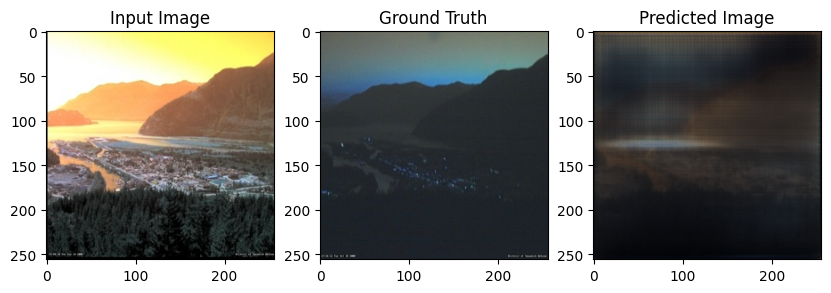

Models saved : gmodel_1000 , dmodel_1000


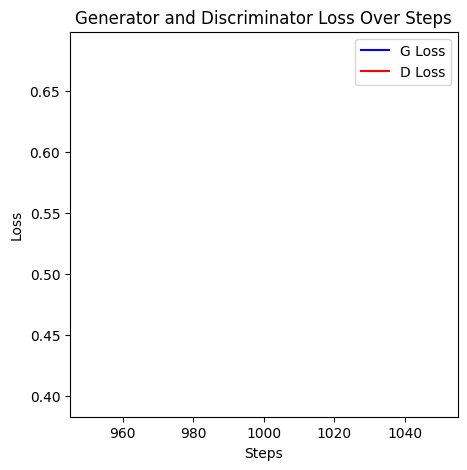

Step 1000/127560  Gen_loss: 0.782  Dis_loss: 0.066 Time: 20ms
Step 1001/127560  Gen_loss: 0.776  Dis_loss: 0.06 Time: 21ms
Step 1002/127560  Gen_loss: 0.702  Dis_loss: 0.019 Time: 20ms
Step 1003/127560  Gen_loss: 0.348  Dis_loss: 1.526 Time: 21ms
Step 1004/127560  Gen_loss: 0.554  Dis_loss: 0.57 Time: 20ms
Step 1005/127560  Gen_loss: 1.087  Dis_loss: 0.542 Time: 20ms
Step 1006/127560  Gen_loss: 1.031  Dis_loss: 0.315 Time: 19ms
Step 1007/127560  Gen_loss: 0.653  Dis_loss: 0.047 Time: 19ms
Step 1008/127560  Gen_loss: 0.511  Dis_loss: 1.854 Time: 21ms
Step 1009/127560  Gen_loss: 0.727  Dis_loss: 0.064 Time: 20ms
Step 1010/127560  Gen_loss: 0.593  Dis_loss: 0.165 Time: 20ms
Step 1011/127560  Gen_loss: 0.739  Dis_loss: 0.083 Time: 20ms
Step 1012/127560  Gen_loss: 1.002  Dis_loss: 0.253 Time: 20ms
Step 1013/127560  Gen_loss: 0.394  Dis_loss: 1.065 Time: 20ms
Step 1014/127560  Gen_loss: 0.703  Dis_loss: 0.068 Time: 22ms
Step 1015/127560  Gen_loss: 0.644  Dis_loss: 0.422 Time: 21ms
Step 1016/

Step 1133/127560  Gen_loss: 0.661  Dis_loss: 0.033 Time: 20ms
Step 1134/127560  Gen_loss: 1.021  Dis_loss: 0.043 Time: 21ms
Step 1135/127560  Gen_loss: 0.654  Dis_loss: 0.029 Time: 21ms
Step 1136/127560  Gen_loss: 0.441  Dis_loss: 0.577 Time: 20ms
Step 1137/127560  Gen_loss: 0.433  Dis_loss: 0.076 Time: 19ms
Step 1138/127560  Gen_loss: 0.925  Dis_loss: 0.06 Time: 20ms
Step 1139/127560  Gen_loss: 0.366  Dis_loss: 0.783 Time: 21ms
Step 1140/127560  Gen_loss: 0.422  Dis_loss: 0.174 Time: 21ms
Step 1141/127560  Gen_loss: 0.927  Dis_loss: 0.227 Time: 20ms
Step 1142/127560  Gen_loss: 0.463  Dis_loss: 0.028 Time: 21ms
Step 1143/127560  Gen_loss: 0.277  Dis_loss: 4.107 Time: 20ms
Step 1144/127560  Gen_loss: 0.612  Dis_loss: 0.075 Time: 19ms
Step 1145/127560  Gen_loss: 0.298  Dis_loss: 1.46 Time: 21ms
Step 1146/127560  Gen_loss: 1.114  Dis_loss: 1.245 Time: 22ms
Step 1147/127560  Gen_loss: 0.717  Dis_loss: 0.288 Time: 21ms
Step 1148/127560  Gen_loss: 0.666  Dis_loss: 0.083 Time: 20ms
Step 1149/

Step 1266/127560  Gen_loss: 0.77  Dis_loss: 0.024 Time: 20ms
Step 1267/127560  Gen_loss: 0.439  Dis_loss: 3.162 Time: 21ms
Step 1268/127560  Gen_loss: 0.629  Dis_loss: 0.074 Time: 20ms
Step 1269/127560  Gen_loss: 0.653  Dis_loss: 0.646 Time: 20ms
Step 1270/127560  Gen_loss: 0.567  Dis_loss: 0.077 Time: 21ms
Step 1271/127560  Gen_loss: 0.62  Dis_loss: 0.041 Time: 21ms
Step 1272/127560  Gen_loss: 0.601  Dis_loss: 0.078 Time: 21ms
Step 1273/127560  Gen_loss: 1.05  Dis_loss: 0.077 Time: 20ms
Step 1274/127560  Gen_loss: 0.673  Dis_loss: 0.025 Time: 20ms
Step 1275/127560  Gen_loss: 0.616  Dis_loss: 0.07 Time: 20ms
Step 1276/127560  Gen_loss: 0.297  Dis_loss: 2.803 Time: 22ms
Step 1277/127560  Gen_loss: 0.86  Dis_loss: 0.116 Time: 20ms
Step 1278/127560  Gen_loss: 0.527  Dis_loss: 0.445 Time: 21ms
Step 1279/127560  Gen_loss: 0.729  Dis_loss: 0.432 Time: 21ms
Step 1280/127560  Gen_loss: 0.413  Dis_loss: 0.986 Time: 22ms
Step 1281/127560  Gen_loss: 0.712  Dis_loss: 0.137 Time: 19ms
Step 1282/127

Step 1399/127560  Gen_loss: 0.649  Dis_loss: 0.474 Time: 20ms
Step 1400/127560  Gen_loss: 0.283  Dis_loss: 1.441 Time: 20ms
Step 1401/127560  Gen_loss: 0.69  Dis_loss: 0.174 Time: 21ms
Step 1402/127560  Gen_loss: 0.307  Dis_loss: 0.562 Time: 21ms
Step 1403/127560  Gen_loss: 0.655  Dis_loss: 0.132 Time: 21ms
Step 1404/127560  Gen_loss: 0.697  Dis_loss: 0.145 Time: 21ms
Step 1405/127560  Gen_loss: 0.793  Dis_loss: 0.06 Time: 22ms
Step 1406/127560  Gen_loss: 0.938  Dis_loss: 0.231 Time: 19ms
Step 1407/127560  Gen_loss: 0.734  Dis_loss: 0.046 Time: 21ms
Step 1408/127560  Gen_loss: 0.914  Dis_loss: 0.153 Time: 20ms
Step 1409/127560  Gen_loss: 0.951  Dis_loss: 0.101 Time: 21ms
Step 1410/127560  Gen_loss: 0.491  Dis_loss: 0.567 Time: 22ms
Step 1411/127560  Gen_loss: 0.939  Dis_loss: 0.027 Time: 21ms
Step 1412/127560  Gen_loss: 0.406  Dis_loss: 0.116 Time: 19ms
Step 1413/127560  Gen_loss: 0.491  Dis_loss: 0.073 Time: 19ms
Step 1414/127560  Gen_loss: 0.563  Dis_loss: 0.075 Time: 21ms
Step 1415/

Step 1532/127560  Gen_loss: 0.945  Dis_loss: 1.171 Time: 20ms
Step 1533/127560  Gen_loss: 0.717  Dis_loss: 0.435 Time: 19ms
Step 1534/127560  Gen_loss: 0.947  Dis_loss: 0.09 Time: 19ms
Step 1535/127560  Gen_loss: 0.7  Dis_loss: 0.081 Time: 19ms
Step 1536/127560  Gen_loss: 0.636  Dis_loss: 0.19 Time: 19ms
Step 1537/127560  Gen_loss: 0.323  Dis_loss: 0.283 Time: 21ms
Step 1538/127560  Gen_loss: 0.905  Dis_loss: 0.046 Time: 20ms
Step 1539/127560  Gen_loss: 0.602  Dis_loss: 0.964 Time: 20ms
Step 1540/127560  Gen_loss: 0.945  Dis_loss: 0.102 Time: 19ms
Step 1541/127560  Gen_loss: 0.556  Dis_loss: 0.194 Time: 20ms
Step 1542/127560  Gen_loss: 0.787  Dis_loss: 0.061 Time: 21ms
Step 1543/127560  Gen_loss: 0.924  Dis_loss: 0.078 Time: 19ms
Step 1544/127560  Gen_loss: 0.541  Dis_loss: 0.091 Time: 21ms
Step 1545/127560  Gen_loss: 0.769  Dis_loss: 0.082 Time: 20ms
Step 1546/127560  Gen_loss: 0.582  Dis_loss: 0.091 Time: 21ms
Step 1547/127560  Gen_loss: 0.638  Dis_loss: 0.071 Time: 20ms
Step 1548/12

Step 1665/127560  Gen_loss: 0.557  Dis_loss: 0.162 Time: 19ms
Step 1666/127560  Gen_loss: 0.725  Dis_loss: 0.058 Time: 19ms
Step 1667/127560  Gen_loss: 0.788  Dis_loss: 0.101 Time: 19ms
Step 1668/127560  Gen_loss: 0.579  Dis_loss: 0.064 Time: 19ms
Step 1669/127560  Gen_loss: 0.653  Dis_loss: 0.184 Time: 20ms
Step 1670/127560  Gen_loss: 0.384  Dis_loss: 1.032 Time: 19ms
Step 1671/127560  Gen_loss: 0.609  Dis_loss: 0.127 Time: 19ms
Step 1672/127560  Gen_loss: 0.696  Dis_loss: 0.343 Time: 20ms
Step 1673/127560  Gen_loss: 0.628  Dis_loss: 0.131 Time: 19ms
Step 1674/127560  Gen_loss: 0.903  Dis_loss: 0.621 Time: 19ms
Step 1675/127560  Gen_loss: 0.944  Dis_loss: 0.032 Time: 20ms
Step 1676/127560  Gen_loss: 0.547  Dis_loss: 0.067 Time: 20ms
Step 1677/127560  Gen_loss: 0.658  Dis_loss: 0.039 Time: 19ms
Step 1678/127560  Gen_loss: 0.63  Dis_loss: 0.068 Time: 19ms
Step 1679/127560  Gen_loss: 0.606  Dis_loss: 0.058 Time: 20ms
Step 1680/127560  Gen_loss: 0.716  Dis_loss: 0.038 Time: 19ms
Step 1681

Step 1798/127560  Gen_loss: 0.575  Dis_loss: 0.233 Time: 19ms
Step 1799/127560  Gen_loss: 0.503  Dis_loss: 0.121 Time: 20ms
Step 1800/127560  Gen_loss: 0.57  Dis_loss: 2.835 Time: 19ms
Step 1801/127560  Gen_loss: 0.461  Dis_loss: 0.671 Time: 20ms
Step 1802/127560  Gen_loss: 0.6  Dis_loss: 0.61 Time: 20ms
Step 1803/127560  Gen_loss: 0.398  Dis_loss: 0.49 Time: 19ms
Step 1804/127560  Gen_loss: 0.594  Dis_loss: 0.207 Time: 20ms
Step 1805/127560  Gen_loss: 0.433  Dis_loss: 0.119 Time: 20ms
Step 1806/127560  Gen_loss: 0.461  Dis_loss: 0.067 Time: 20ms
Step 1807/127560  Gen_loss: 0.694  Dis_loss: 0.056 Time: 19ms
Step 1808/127560  Gen_loss: 0.431  Dis_loss: 0.103 Time: 20ms
Step 1809/127560  Gen_loss: 0.617  Dis_loss: 0.093 Time: 20ms
Step 1810/127560  Gen_loss: 0.653  Dis_loss: 0.057 Time: 19ms
Step 1811/127560  Gen_loss: 0.637  Dis_loss: 0.051 Time: 20ms
Step 1812/127560  Gen_loss: 0.908  Dis_loss: 0.064 Time: 19ms
Step 1813/127560  Gen_loss: 0.901  Dis_loss: 0.054 Time: 20ms
Step 1814/127

Step 1931/127560  Gen_loss: 0.392  Dis_loss: 1.501 Time: 21ms
Step 1932/127560  Gen_loss: 0.619  Dis_loss: 0.272 Time: 19ms
Step 1933/127560  Gen_loss: 0.638  Dis_loss: 0.177 Time: 20ms
Step 1934/127560  Gen_loss: 0.72  Dis_loss: 0.95 Time: 19ms
Step 1935/127560  Gen_loss: 0.462  Dis_loss: 0.282 Time: 19ms
Step 1936/127560  Gen_loss: 0.93  Dis_loss: 0.224 Time: 20ms
Step 1937/127560  Gen_loss: 0.646  Dis_loss: 0.609 Time: 21ms
Step 1938/127560  Gen_loss: 0.675  Dis_loss: 0.056 Time: 20ms
Step 1939/127560  Gen_loss: 0.293  Dis_loss: 2.668 Time: 21ms
Step 1940/127560  Gen_loss: 0.437  Dis_loss: 0.669 Time: 20ms
Step 1941/127560  Gen_loss: 0.672  Dis_loss: 0.319 Time: 19ms
Step 1942/127560  Gen_loss: 0.855  Dis_loss: 1.134 Time: 19ms
Step 1943/127560  Gen_loss: 0.51  Dis_loss: 0.224 Time: 20ms
Step 1944/127560  Gen_loss: 0.572  Dis_loss: 0.167 Time: 20ms
Step 1945/127560  Gen_loss: 0.598  Dis_loss: 0.086 Time: 19ms
Step 1946/127560  Gen_loss: 0.666  Dis_loss: 0.111 Time: 20ms
Step 1947/12

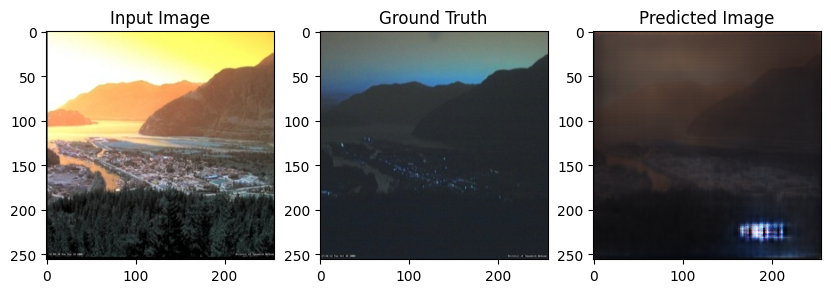

Models saved : gmodel_2000 , dmodel_2000


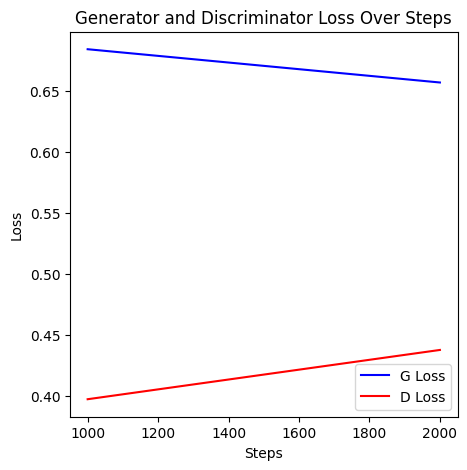

Step 2000/127560  Gen_loss: 0.257  Dis_loss: 1.394 Time: 19ms
Step 2001/127560  Gen_loss: 0.707  Dis_loss: 0.212 Time: 20ms
Step 2002/127560  Gen_loss: 0.842  Dis_loss: 0.304 Time: 20ms
Step 2003/127560  Gen_loss: 0.471  Dis_loss: 0.231 Time: 20ms
Step 2004/127560  Gen_loss: 0.453  Dis_loss: 0.298 Time: 19ms
Step 2005/127560  Gen_loss: 0.858  Dis_loss: 0.184 Time: 20ms
Step 2006/127560  Gen_loss: 0.575  Dis_loss: 0.292 Time: 20ms
Step 2007/127560  Gen_loss: 0.536  Dis_loss: 0.086 Time: 20ms
Step 2008/127560  Gen_loss: 0.715  Dis_loss: 0.13 Time: 20ms
Step 2009/127560  Gen_loss: 0.757  Dis_loss: 0.235 Time: 19ms
Step 2010/127560  Gen_loss: 0.299  Dis_loss: 2.587 Time: 19ms
Step 2011/127560  Gen_loss: 0.424  Dis_loss: 1.123 Time: 19ms
Step 2012/127560  Gen_loss: 0.566  Dis_loss: 0.212 Time: 20ms
Step 2013/127560  Gen_loss: 0.865  Dis_loss: 0.355 Time: 20ms
Step 2014/127560  Gen_loss: 0.495  Dis_loss: 0.272 Time: 20ms
Step 2015/127560  Gen_loss: 0.497  Dis_loss: 0.117 Time: 20ms
Step 2016

Step 2133/127560  Gen_loss: 0.928  Dis_loss: 0.056 Time: 20ms
Step 2134/127560  Gen_loss: 0.663  Dis_loss: 0.052 Time: 19ms
Step 2135/127560  Gen_loss: 0.902  Dis_loss: 0.106 Time: 20ms
Step 2136/127560  Gen_loss: 0.672  Dis_loss: 0.052 Time: 19ms
Step 2137/127560  Gen_loss: 0.858  Dis_loss: 0.023 Time: 19ms
Step 2138/127560  Gen_loss: 0.821  Dis_loss: 0.09 Time: 19ms
Step 2139/127560  Gen_loss: 0.392  Dis_loss: 1.287 Time: 19ms
Step 2140/127560  Gen_loss: 0.863  Dis_loss: 0.162 Time: 20ms
Step 2141/127560  Gen_loss: 0.731  Dis_loss: 0.105 Time: 19ms
Step 2142/127560  Gen_loss: 0.468  Dis_loss: 0.171 Time: 19ms
Step 2143/127560  Gen_loss: 1.001  Dis_loss: 0.09 Time: 20ms
Step 2144/127560  Gen_loss: 0.751  Dis_loss: 0.874 Time: 20ms
Step 2145/127560  Gen_loss: 0.753  Dis_loss: 0.118 Time: 19ms
Step 2146/127560  Gen_loss: 0.877  Dis_loss: 0.086 Time: 20ms
Step 2147/127560  Gen_loss: 0.495  Dis_loss: 0.558 Time: 20ms
Step 2148/127560  Gen_loss: 0.441  Dis_loss: 0.683 Time: 20ms
Step 2149/

Step 2266/127560  Gen_loss: 0.537  Dis_loss: 0.061 Time: 20ms
Step 2267/127560  Gen_loss: 0.578  Dis_loss: 0.231 Time: 19ms
Step 2268/127560  Gen_loss: 0.63  Dis_loss: 0.236 Time: 20ms
Step 2269/127560  Gen_loss: 0.606  Dis_loss: 0.034 Time: 19ms
Step 2270/127560  Gen_loss: 0.342  Dis_loss: 0.968 Time: 20ms
Step 2271/127560  Gen_loss: 0.628  Dis_loss: 0.078 Time: 20ms
Step 2272/127560  Gen_loss: 0.814  Dis_loss: 0.069 Time: 19ms
Step 2273/127560  Gen_loss: 0.654  Dis_loss: 0.089 Time: 20ms
Step 2274/127560  Gen_loss: 0.447  Dis_loss: 0.119 Time: 20ms
Step 2275/127560  Gen_loss: 0.749  Dis_loss: 0.584 Time: 20ms
Step 2276/127560  Gen_loss: 0.553  Dis_loss: 0.244 Time: 20ms
Step 2277/127560  Gen_loss: 0.869  Dis_loss: 0.117 Time: 19ms
Step 2278/127560  Gen_loss: 0.452  Dis_loss: 0.925 Time: 19ms
Step 2279/127560  Gen_loss: 0.702  Dis_loss: 0.27 Time: 19ms
Step 2280/127560  Gen_loss: 0.751  Dis_loss: 0.514 Time: 19ms
Step 2281/127560  Gen_loss: 0.349  Dis_loss: 2.168 Time: 19ms
Step 2282/

Step 2399/127560  Gen_loss: 0.276  Dis_loss: 2.622 Time: 22ms
Step 2400/127560  Gen_loss: 0.638  Dis_loss: 0.319 Time: 19ms
Step 2401/127560  Gen_loss: 0.491  Dis_loss: 0.682 Time: 21ms
Step 2402/127560  Gen_loss: 0.314  Dis_loss: 0.362 Time: 19ms
Step 2403/127560  Gen_loss: 0.729  Dis_loss: 0.032 Time: 20ms
Step 2404/127560  Gen_loss: 0.589  Dis_loss: 0.219 Time: 20ms
Step 2405/127560  Gen_loss: 0.444  Dis_loss: 0.674 Time: 19ms
Step 2406/127560  Gen_loss: 0.523  Dis_loss: 0.373 Time: 19ms
Step 2407/127560  Gen_loss: 0.491  Dis_loss: 0.426 Time: 19ms
Step 2408/127560  Gen_loss: 0.462  Dis_loss: 0.209 Time: 20ms
Step 2409/127560  Gen_loss: 0.523  Dis_loss: 0.11 Time: 21ms
Step 2410/127560  Gen_loss: 0.584  Dis_loss: 0.111 Time: 19ms
Step 2411/127560  Gen_loss: 0.647  Dis_loss: 0.063 Time: 19ms
Step 2412/127560  Gen_loss: 0.801  Dis_loss: 0.03 Time: 20ms
Step 2413/127560  Gen_loss: 0.354  Dis_loss: 0.965 Time: 21ms
Step 2414/127560  Gen_loss: 0.825  Dis_loss: 0.139 Time: 19ms
Step 2415/

Step 2532/127560  Gen_loss: 0.92  Dis_loss: 0.11 Time: 20ms
Step 2533/127560  Gen_loss: 0.726  Dis_loss: 0.062 Time: 19ms
Step 2534/127560  Gen_loss: 0.851  Dis_loss: 0.153 Time: 20ms
Step 2535/127560  Gen_loss: 0.699  Dis_loss: 0.029 Time: 19ms
Step 2536/127560  Gen_loss: 0.625  Dis_loss: 0.63 Time: 19ms
Step 2537/127560  Gen_loss: 0.699  Dis_loss: 0.061 Time: 19ms
Step 2538/127560  Gen_loss: 0.624  Dis_loss: 0.293 Time: 19ms
Step 2539/127560  Gen_loss: 0.344  Dis_loss: 1.55 Time: 19ms
Step 2540/127560  Gen_loss: 0.728  Dis_loss: 0.285 Time: 20ms
Step 2541/127560  Gen_loss: 0.644  Dis_loss: 2.378 Time: 19ms
Step 2542/127560  Gen_loss: 0.755  Dis_loss: 0.415 Time: 20ms
Step 2543/127560  Gen_loss: 0.505  Dis_loss: 1.179 Time: 20ms
Step 2544/127560  Gen_loss: 0.911  Dis_loss: 0.203 Time: 20ms
Step 2545/127560  Gen_loss: 0.525  Dis_loss: 1.149 Time: 19ms
Step 2546/127560  Gen_loss: 0.593  Dis_loss: 0.263 Time: 19ms
Step 2547/127560  Gen_loss: 0.36  Dis_loss: 0.882 Time: 20ms
Step 2548/127

Step 2665/127560  Gen_loss: 0.685  Dis_loss: 0.096 Time: 19ms
Step 2666/127560  Gen_loss: 0.915  Dis_loss: 0.071 Time: 19ms
Step 2667/127560  Gen_loss: 0.665  Dis_loss: 0.161 Time: 19ms
Step 2668/127560  Gen_loss: 0.701  Dis_loss: 0.047 Time: 20ms
Step 2669/127560  Gen_loss: 0.414  Dis_loss: 3.238 Time: 20ms
Step 2670/127560  Gen_loss: 0.758  Dis_loss: 0.281 Time: 18ms
Step 2671/127560  Gen_loss: 0.683  Dis_loss: 0.083 Time: 18ms
Step 2672/127560  Gen_loss: 0.611  Dis_loss: 0.081 Time: 19ms
Step 2673/127560  Gen_loss: 0.868  Dis_loss: 0.826 Time: 19ms
Step 2674/127560  Gen_loss: 0.262  Dis_loss: 2.128 Time: 18ms
Step 2675/127560  Gen_loss: 0.41  Dis_loss: 0.575 Time: 20ms
Step 2676/127560  Gen_loss: 0.536  Dis_loss: 0.557 Time: 19ms
Step 2677/127560  Gen_loss: 0.444  Dis_loss: 0.344 Time: 20ms
Step 2678/127560  Gen_loss: 1.083  Dis_loss: 0.31 Time: 19ms
Step 2679/127560  Gen_loss: 0.633  Dis_loss: 0.146 Time: 19ms
Step 2680/127560  Gen_loss: 0.845  Dis_loss: 0.176 Time: 18ms
Step 2681/

Step 2798/127560  Gen_loss: 0.452  Dis_loss: 0.317 Time: 19ms
Step 2799/127560  Gen_loss: 0.445  Dis_loss: 0.395 Time: 19ms
Step 2800/127560  Gen_loss: 0.703  Dis_loss: 0.433 Time: 20ms
Step 2801/127560  Gen_loss: 0.609  Dis_loss: 0.142 Time: 19ms
Step 2802/127560  Gen_loss: 0.495  Dis_loss: 0.407 Time: 19ms
Step 2803/127560  Gen_loss: 0.528  Dis_loss: 1.308 Time: 19ms
Step 2804/127560  Gen_loss: 0.763  Dis_loss: 1.677 Time: 19ms
Step 2805/127560  Gen_loss: 0.32  Dis_loss: 0.241 Time: 19ms
Step 2806/127560  Gen_loss: 0.613  Dis_loss: 0.268 Time: 21ms
Step 2807/127560  Gen_loss: 0.823  Dis_loss: 0.424 Time: 19ms
Step 2808/127560  Gen_loss: 0.564  Dis_loss: 1.713 Time: 19ms
Step 2809/127560  Gen_loss: 0.392  Dis_loss: 0.232 Time: 19ms
Step 2810/127560  Gen_loss: 0.865  Dis_loss: 0.199 Time: 21ms
Step 2811/127560  Gen_loss: 0.698  Dis_loss: 0.218 Time: 19ms
Step 2812/127560  Gen_loss: 0.499  Dis_loss: 1.323 Time: 19ms
Step 2813/127560  Gen_loss: 0.72  Dis_loss: 0.089 Time: 19ms
Step 2814/

Step 2931/127560  Gen_loss: 0.356  Dis_loss: 0.273 Time: 19ms
Step 2932/127560  Gen_loss: 0.41  Dis_loss: 1.697 Time: 20ms
Step 2933/127560  Gen_loss: 0.56  Dis_loss: 0.341 Time: 19ms
Step 2934/127560  Gen_loss: 0.493  Dis_loss: 0.961 Time: 19ms
Step 2935/127560  Gen_loss: 0.498  Dis_loss: 0.244 Time: 22ms
Step 2936/127560  Gen_loss: 0.638  Dis_loss: 0.749 Time: 20ms
Step 2937/127560  Gen_loss: 0.822  Dis_loss: 0.561 Time: 20ms
Step 2938/127560  Gen_loss: 0.598  Dis_loss: 0.612 Time: 21ms
Step 2939/127560  Gen_loss: 0.497  Dis_loss: 0.147 Time: 19ms
Step 2940/127560  Gen_loss: 0.31  Dis_loss: 1.106 Time: 20ms
Step 2941/127560  Gen_loss: 0.91  Dis_loss: 0.106 Time: 19ms
Step 2942/127560  Gen_loss: 0.446  Dis_loss: 0.185 Time: 20ms
Step 2943/127560  Gen_loss: 0.259  Dis_loss: 1.329 Time: 20ms
Step 2944/127560  Gen_loss: 0.843  Dis_loss: 0.341 Time: 20ms
Step 2945/127560  Gen_loss: 0.229  Dis_loss: 0.656 Time: 20ms
Step 2946/127560  Gen_loss: 0.531  Dis_loss: 0.976 Time: 19ms
Step 2947/12

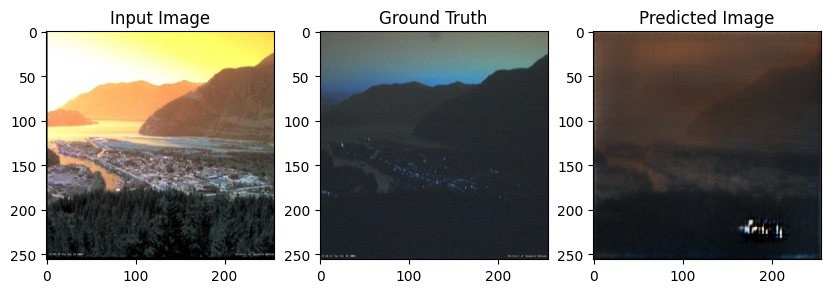

Models saved : gmodel_3000 , dmodel_3000


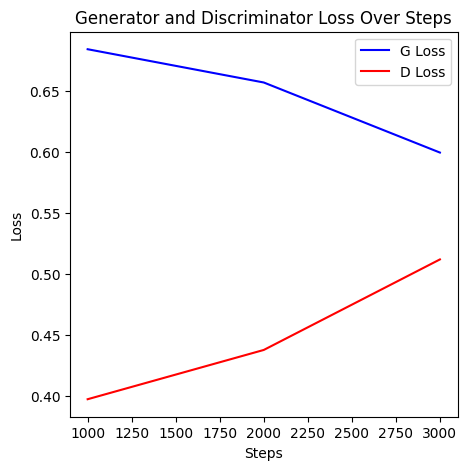

Step 3000/127560  Gen_loss: 0.935  Dis_loss: 0.072 Time: 20ms
Step 3001/127560  Gen_loss: 0.904  Dis_loss: 0.143 Time: 19ms
Step 3002/127560  Gen_loss: 0.397  Dis_loss: 0.218 Time: 20ms
Step 3003/127560  Gen_loss: 0.6  Dis_loss: 1.146 Time: 19ms
Step 3004/127560  Gen_loss: 0.692  Dis_loss: 0.208 Time: 19ms
Step 3005/127560  Gen_loss: 0.495  Dis_loss: 0.134 Time: 19ms
Step 3006/127560  Gen_loss: 0.528  Dis_loss: 0.34 Time: 19ms
Step 3007/127560  Gen_loss: 0.707  Dis_loss: 0.287 Time: 19ms
Step 3008/127560  Gen_loss: 0.461  Dis_loss: 0.436 Time: 19ms
Step 3009/127560  Gen_loss: 0.434  Dis_loss: 0.182 Time: 19ms
Step 3010/127560  Gen_loss: 0.653  Dis_loss: 0.037 Time: 20ms
Step 3011/127560  Gen_loss: 0.62  Dis_loss: 0.258 Time: 20ms
Step 3012/127560  Gen_loss: 0.311  Dis_loss: 0.863 Time: 20ms
Step 3013/127560  Gen_loss: 0.233  Dis_loss: 1.035 Time: 20ms
Step 3014/127560  Gen_loss: 0.708  Dis_loss: 0.945 Time: 20ms
Step 3015/127560  Gen_loss: 0.308  Dis_loss: 0.706 Time: 19ms
Step 3016/12

Step 3133/127560  Gen_loss: 0.528  Dis_loss: 0.268 Time: 20ms
Step 3134/127560  Gen_loss: 0.653  Dis_loss: 0.068 Time: 19ms
Step 3135/127560  Gen_loss: 0.623  Dis_loss: 0.081 Time: 19ms
Step 3136/127560  Gen_loss: 0.319  Dis_loss: 1.684 Time: 20ms
Step 3137/127560  Gen_loss: 0.754  Dis_loss: 0.329 Time: 19ms
Step 3138/127560  Gen_loss: 0.976  Dis_loss: 0.063 Time: 20ms
Step 3139/127560  Gen_loss: 0.404  Dis_loss: 1.906 Time: 19ms
Step 3140/127560  Gen_loss: 0.42  Dis_loss: 1.337 Time: 20ms
Step 3141/127560  Gen_loss: 0.805  Dis_loss: 0.677 Time: 20ms
Step 3142/127560  Gen_loss: 0.435  Dis_loss: 0.871 Time: 19ms
Step 3143/127560  Gen_loss: 0.449  Dis_loss: 0.9 Time: 19ms
Step 3144/127560  Gen_loss: 0.624  Dis_loss: 1.002 Time: 20ms
Step 3145/127560  Gen_loss: 0.603  Dis_loss: 0.802 Time: 19ms
Step 3146/127560  Gen_loss: 0.591  Dis_loss: 0.268 Time: 19ms
Step 3147/127560  Gen_loss: 0.653  Dis_loss: 0.52 Time: 19ms
Step 3148/127560  Gen_loss: 0.682  Dis_loss: 0.106 Time: 19ms
Step 3149/12

Step 3266/127560  Gen_loss: 0.497  Dis_loss: 0.688 Time: 19ms
Step 3267/127560  Gen_loss: 0.276  Dis_loss: 0.821 Time: 19ms
Step 3268/127560  Gen_loss: 0.53  Dis_loss: 1.153 Time: 19ms
Step 3269/127560  Gen_loss: 0.384  Dis_loss: 0.733 Time: 19ms
Step 3270/127560  Gen_loss: 0.736  Dis_loss: 0.639 Time: 20ms
Step 3271/127560  Gen_loss: 0.703  Dis_loss: 0.618 Time: 20ms
Step 3272/127560  Gen_loss: 0.446  Dis_loss: 1.706 Time: 19ms
Step 3273/127560  Gen_loss: 0.566  Dis_loss: 0.521 Time: 20ms
Step 3274/127560  Gen_loss: 0.452  Dis_loss: 0.948 Time: 19ms
Step 3275/127560  Gen_loss: 0.614  Dis_loss: 0.303 Time: 19ms
Step 3276/127560  Gen_loss: 0.778  Dis_loss: 0.077 Time: 19ms
Step 3277/127560  Gen_loss: 0.633  Dis_loss: 0.108 Time: 20ms
Step 3278/127560  Gen_loss: 0.396  Dis_loss: 0.395 Time: 21ms
Step 3279/127560  Gen_loss: 0.55  Dis_loss: 2.806 Time: 20ms
Step 3280/127560  Gen_loss: 0.809  Dis_loss: 0.812 Time: 20ms
Step 3281/127560  Gen_loss: 0.815  Dis_loss: 1.052 Time: 19ms
Step 3282/

Step 3399/127560  Gen_loss: 0.518  Dis_loss: 0.483 Time: 20ms
Step 3400/127560  Gen_loss: 0.794  Dis_loss: 0.588 Time: 20ms
Step 3401/127560  Gen_loss: 0.298  Dis_loss: 0.416 Time: 20ms
Step 3402/127560  Gen_loss: 0.717  Dis_loss: 0.537 Time: 20ms
Step 3403/127560  Gen_loss: 0.42  Dis_loss: 0.673 Time: 20ms
Step 3404/127560  Gen_loss: 0.707  Dis_loss: 0.058 Time: 20ms
Step 3405/127560  Gen_loss: 0.718  Dis_loss: 0.162 Time: 19ms
Step 3406/127560  Gen_loss: 0.848  Dis_loss: 0.03 Time: 21ms
Step 3407/127560  Gen_loss: 0.456  Dis_loss: 1.221 Time: 20ms
Step 3408/127560  Gen_loss: 0.308  Dis_loss: 0.789 Time: 19ms
Step 3409/127560  Gen_loss: 0.6  Dis_loss: 0.471 Time: 20ms
Step 3410/127560  Gen_loss: 0.702  Dis_loss: 1.015 Time: 20ms
Step 3411/127560  Gen_loss: 0.377  Dis_loss: 0.54 Time: 19ms
Step 3412/127560  Gen_loss: 0.701  Dis_loss: 2.747 Time: 19ms
Step 3413/127560  Gen_loss: 0.481  Dis_loss: 0.253 Time: 19ms
Step 3414/127560  Gen_loss: 0.652  Dis_loss: 0.237 Time: 21ms
Step 3415/127

Step 3532/127560  Gen_loss: 0.336  Dis_loss: 2.382 Time: 19ms
Step 3533/127560  Gen_loss: 0.666  Dis_loss: 0.092 Time: 20ms
Step 3534/127560  Gen_loss: 0.775  Dis_loss: 0.617 Time: 19ms
Step 3535/127560  Gen_loss: 0.625  Dis_loss: 0.766 Time: 20ms
Step 3536/127560  Gen_loss: 0.429  Dis_loss: 1.588 Time: 19ms
Step 3537/127560  Gen_loss: 0.518  Dis_loss: 0.496 Time: 20ms
Step 3538/127560  Gen_loss: 0.401  Dis_loss: 0.422 Time: 20ms
Step 3539/127560  Gen_loss: 0.247  Dis_loss: 0.445 Time: 19ms
Step 3540/127560  Gen_loss: 0.613  Dis_loss: 0.557 Time: 20ms
Step 3541/127560  Gen_loss: 0.443  Dis_loss: 0.54 Time: 19ms
Step 3542/127560  Gen_loss: 0.427  Dis_loss: 0.117 Time: 20ms
Step 3543/127560  Gen_loss: 0.875  Dis_loss: 1.801 Time: 20ms
Step 3544/127560  Gen_loss: 0.547  Dis_loss: 0.31 Time: 20ms
Step 3545/127560  Gen_loss: 0.679  Dis_loss: 0.068 Time: 20ms
Step 3546/127560  Gen_loss: 0.189  Dis_loss: 1.958 Time: 22ms
Step 3547/127560  Gen_loss: 0.521  Dis_loss: 0.95 Time: 19ms
Step 3548/1

Step 3665/127560  Gen_loss: 0.489  Dis_loss: 1.135 Time: 19ms
Step 3666/127560  Gen_loss: 0.584  Dis_loss: 0.406 Time: 19ms
Step 3667/127560  Gen_loss: 0.674  Dis_loss: 0.333 Time: 20ms
Step 3668/127560  Gen_loss: 0.517  Dis_loss: 0.113 Time: 19ms
Step 3669/127560  Gen_loss: 0.804  Dis_loss: 0.397 Time: 19ms
Step 3670/127560  Gen_loss: 0.642  Dis_loss: 0.12 Time: 19ms
Step 3671/127560  Gen_loss: 0.665  Dis_loss: 0.052 Time: 19ms
Step 3672/127560  Gen_loss: 0.595  Dis_loss: 0.126 Time: 20ms
Step 3673/127560  Gen_loss: 0.55  Dis_loss: 2.567 Time: 19ms
Step 3674/127560  Gen_loss: 0.518  Dis_loss: 0.75 Time: 19ms
Step 3675/127560  Gen_loss: 0.649  Dis_loss: 0.88 Time: 20ms
Step 3676/127560  Gen_loss: 0.532  Dis_loss: 0.152 Time: 19ms
Step 3677/127560  Gen_loss: 0.464  Dis_loss: 0.711 Time: 19ms
Step 3678/127560  Gen_loss: 0.484  Dis_loss: 0.228 Time: 21ms
Step 3679/127560  Gen_loss: 0.731  Dis_loss: 0.657 Time: 20ms
Step 3680/127560  Gen_loss: 0.375  Dis_loss: 2.889 Time: 20ms
Step 3681/12

Step 3798/127560  Gen_loss: 0.598  Dis_loss: 1.737 Time: 20ms
Step 3799/127560  Gen_loss: 0.587  Dis_loss: 0.465 Time: 19ms
Step 3800/127560  Gen_loss: 0.583  Dis_loss: 0.444 Time: 19ms
Step 3801/127560  Gen_loss: 0.717  Dis_loss: 1.638 Time: 19ms
Step 3802/127560  Gen_loss: 0.557  Dis_loss: 0.402 Time: 19ms
Step 3803/127560  Gen_loss: 0.756  Dis_loss: 0.548 Time: 20ms
Step 3804/127560  Gen_loss: 0.556  Dis_loss: 0.469 Time: 20ms
Step 3805/127560  Gen_loss: 0.729  Dis_loss: 0.073 Time: 20ms
Step 3806/127560  Gen_loss: 0.704  Dis_loss: 0.269 Time: 20ms
Step 3807/127560  Gen_loss: 0.517  Dis_loss: 0.297 Time: 20ms
Step 3808/127560  Gen_loss: 0.904  Dis_loss: 1.208 Time: 20ms
Step 3809/127560  Gen_loss: 0.587  Dis_loss: 0.346 Time: 22ms
Step 3810/127560  Gen_loss: 0.622  Dis_loss: 0.429 Time: 19ms
Step 3811/127560  Gen_loss: 0.596  Dis_loss: 0.284 Time: 19ms
Step 3812/127560  Gen_loss: 0.908  Dis_loss: 0.227 Time: 20ms
Step 3813/127560  Gen_loss: 0.556  Dis_loss: 0.209 Time: 19ms
Step 381

Step 3931/127560  Gen_loss: 0.65  Dis_loss: 0.063 Time: 19ms
Step 3932/127560  Gen_loss: 0.707  Dis_loss: 2.184 Time: 19ms
Step 3933/127560  Gen_loss: 0.403  Dis_loss: 1.55 Time: 20ms
Step 3934/127560  Gen_loss: 0.801  Dis_loss: 0.6 Time: 20ms
Step 3935/127560  Gen_loss: 0.519  Dis_loss: 0.172 Time: 19ms
Step 3936/127560  Gen_loss: 0.639  Dis_loss: 0.502 Time: 19ms
Step 3937/127560  Gen_loss: 0.685  Dis_loss: 1.62 Time: 20ms
Step 3938/127560  Gen_loss: 0.887  Dis_loss: 0.202 Time: 19ms
Step 3939/127560  Gen_loss: 0.427  Dis_loss: 2.973 Time: 19ms
Step 3940/127560  Gen_loss: 0.943  Dis_loss: 0.5 Time: 19ms
Step 3941/127560  Gen_loss: 0.259  Dis_loss: 0.386 Time: 19ms
Step 3942/127560  Gen_loss: 0.663  Dis_loss: 0.297 Time: 19ms
Step 3943/127560  Gen_loss: 0.93  Dis_loss: 0.095 Time: 19ms
Step 3944/127560  Gen_loss: 0.287  Dis_loss: 1.123 Time: 19ms
Step 3945/127560  Gen_loss: 0.786  Dis_loss: 1.075 Time: 20ms
Step 3946/127560  Gen_loss: 0.686  Dis_loss: 0.902 Time: 19ms
Step 3947/127560

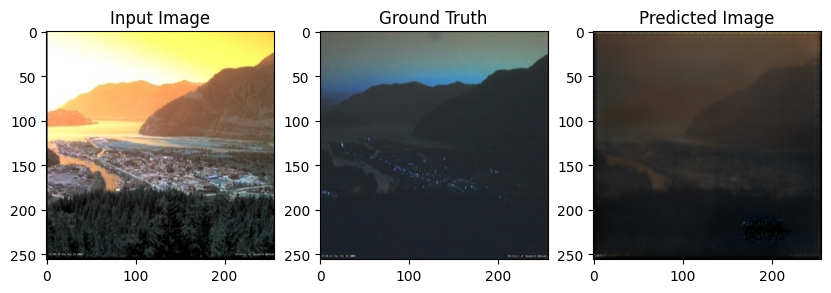

Models saved : gmodel_4000 , dmodel_4000


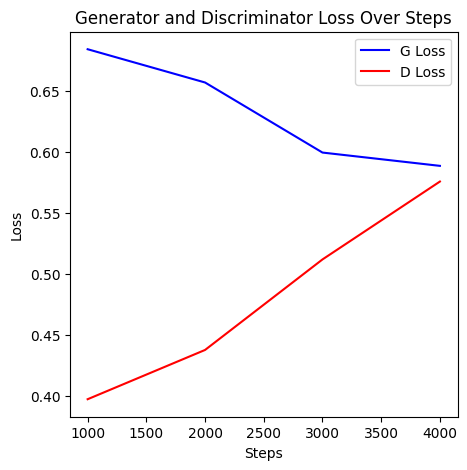

Step 4000/127560  Gen_loss: 0.667  Dis_loss: 0.178 Time: 19ms
Step 4001/127560  Gen_loss: 0.513  Dis_loss: 0.156 Time: 19ms
Step 4002/127560  Gen_loss: 0.619  Dis_loss: 0.255 Time: 21ms
Step 4003/127560  Gen_loss: 0.504  Dis_loss: 0.083 Time: 20ms
Step 4004/127560  Gen_loss: 0.892  Dis_loss: 0.574 Time: 20ms
Step 4005/127560  Gen_loss: 0.638  Dis_loss: 0.357 Time: 19ms
Step 4006/127560  Gen_loss: 0.672  Dis_loss: 0.047 Time: 19ms
Step 4007/127560  Gen_loss: 0.718  Dis_loss: 0.229 Time: 19ms
Step 4008/127560  Gen_loss: 0.668  Dis_loss: 0.083 Time: 19ms
Step 4009/127560  Gen_loss: 0.636  Dis_loss: 0.237 Time: 20ms
Step 4010/127560  Gen_loss: 0.425  Dis_loss: 1.72 Time: 20ms
Step 4011/127560  Gen_loss: 0.706  Dis_loss: 0.182 Time: 20ms
Step 4012/127560  Gen_loss: 0.469  Dis_loss: 0.591 Time: 20ms
Step 4013/127560  Gen_loss: 0.353  Dis_loss: 0.345 Time: 19ms
Step 4014/127560  Gen_loss: 0.52  Dis_loss: 1.233 Time: 20ms
Step 4015/127560  Gen_loss: 0.39  Dis_loss: 0.379 Time: 19ms
Step 4016/1

Step 4133/127560  Gen_loss: 1.059  Dis_loss: 0.14 Time: 20ms
Step 4134/127560  Gen_loss: 0.604  Dis_loss: 0.242 Time: 19ms
Step 4135/127560  Gen_loss: 0.41  Dis_loss: 0.909 Time: 19ms
Step 4136/127560  Gen_loss: 0.226  Dis_loss: 1.004 Time: 20ms
Step 4137/127560  Gen_loss: 0.608  Dis_loss: 2.812 Time: 19ms
Step 4138/127560  Gen_loss: 0.614  Dis_loss: 0.27 Time: 19ms
Step 4139/127560  Gen_loss: 0.535  Dis_loss: 0.331 Time: 19ms
Step 4140/127560  Gen_loss: 0.608  Dis_loss: 0.489 Time: 19ms
Step 4141/127560  Gen_loss: 0.573  Dis_loss: 0.091 Time: 19ms
Step 4142/127560  Gen_loss: 0.548  Dis_loss: 0.466 Time: 19ms
Step 4143/127560  Gen_loss: 0.573  Dis_loss: 0.556 Time: 20ms
Step 4144/127560  Gen_loss: 0.23  Dis_loss: 0.902 Time: 20ms
Step 4145/127560  Gen_loss: 0.58  Dis_loss: 0.223 Time: 20ms
Step 4146/127560  Gen_loss: 0.549  Dis_loss: 0.695 Time: 19ms
Step 4147/127560  Gen_loss: 0.331  Dis_loss: 0.383 Time: 19ms
Step 4148/127560  Gen_loss: 0.599  Dis_loss: 0.72 Time: 20ms
Step 4149/1275

Step 4266/127560  Gen_loss: 0.237  Dis_loss: 0.585 Time: 20ms
Step 4267/127560  Gen_loss: 0.488  Dis_loss: 0.888 Time: 19ms
Step 4268/127560  Gen_loss: 0.696  Dis_loss: 0.183 Time: 19ms
Step 4269/127560  Gen_loss: 0.487  Dis_loss: 0.628 Time: 19ms
Step 4270/127560  Gen_loss: 0.206  Dis_loss: 1.567 Time: 20ms
Step 4271/127560  Gen_loss: 0.292  Dis_loss: 1.734 Time: 19ms
Step 4272/127560  Gen_loss: 0.615  Dis_loss: 0.355 Time: 19ms
Step 4273/127560  Gen_loss: 0.659  Dis_loss: 0.055 Time: 20ms
Step 4274/127560  Gen_loss: 0.586  Dis_loss: 0.267 Time: 19ms
Step 4275/127560  Gen_loss: 0.422  Dis_loss: 0.362 Time: 19ms
Step 4276/127560  Gen_loss: 0.523  Dis_loss: 0.222 Time: 20ms
Step 4277/127560  Gen_loss: 0.681  Dis_loss: 0.289 Time: 19ms
Step 4278/127560  Gen_loss: 0.24  Dis_loss: 2.075 Time: 19ms
Step 4279/127560  Gen_loss: 0.512  Dis_loss: 0.125 Time: 19ms
Step 4280/127560  Gen_loss: 0.832  Dis_loss: 0.35 Time: 19ms
Step 4281/127560  Gen_loss: 0.985  Dis_loss: 0.139 Time: 19ms
Step 4282/

Step 4399/127560  Gen_loss: 0.741  Dis_loss: 0.568 Time: 20ms
Step 4400/127560  Gen_loss: 0.661  Dis_loss: 0.016 Time: 19ms
Step 4401/127560  Gen_loss: 0.595  Dis_loss: 0.178 Time: 19ms
Step 4402/127560  Gen_loss: 0.65  Dis_loss: 0.068 Time: 19ms
Step 4403/127560  Gen_loss: 0.278  Dis_loss: 1.968 Time: 19ms
Step 4404/127560  Gen_loss: 0.497  Dis_loss: 0.24 Time: 19ms
Step 4405/127560  Gen_loss: 0.85  Dis_loss: 0.713 Time: 20ms
Step 4406/127560  Gen_loss: 0.797  Dis_loss: 0.237 Time: 19ms
Step 4407/127560  Gen_loss: 0.706  Dis_loss: 0.296 Time: 19ms
Step 4408/127560  Gen_loss: 0.602  Dis_loss: 0.345 Time: 19ms
Step 4409/127560  Gen_loss: 0.544  Dis_loss: 0.284 Time: 20ms
Step 4410/127560  Gen_loss: 0.405  Dis_loss: 1.031 Time: 18ms
Step 4411/127560  Gen_loss: 0.554  Dis_loss: 0.437 Time: 20ms
Step 4412/127560  Gen_loss: 0.752  Dis_loss: 0.74 Time: 20ms
Step 4413/127560  Gen_loss: 0.701  Dis_loss: 0.882 Time: 19ms
Step 4414/127560  Gen_loss: 0.651  Dis_loss: 0.36 Time: 19ms
Step 4415/127

Step 4532/127560  Gen_loss: 0.321  Dis_loss: 1.745 Time: 19ms
Step 4533/127560  Gen_loss: 0.911  Dis_loss: 0.43 Time: 19ms
Step 4534/127560  Gen_loss: 0.29  Dis_loss: 1.138 Time: 19ms
Step 4535/127560  Gen_loss: 0.849  Dis_loss: 0.182 Time: 20ms
Step 4536/127560  Gen_loss: 0.607  Dis_loss: 0.304 Time: 19ms
Step 4537/127560  Gen_loss: 0.592  Dis_loss: 0.246 Time: 18ms
Step 4538/127560  Gen_loss: 0.401  Dis_loss: 0.394 Time: 19ms
Step 4539/127560  Gen_loss: 0.616  Dis_loss: 0.242 Time: 19ms
Step 4540/127560  Gen_loss: 0.223  Dis_loss: 0.908 Time: 19ms
Step 4541/127560  Gen_loss: 0.859  Dis_loss: 0.758 Time: 19ms
Step 4542/127560  Gen_loss: 0.577  Dis_loss: 0.26 Time: 18ms
Step 4543/127560  Gen_loss: 0.561  Dis_loss: 0.444 Time: 19ms
Step 4544/127560  Gen_loss: 0.235  Dis_loss: 2.29 Time: 20ms
Step 4545/127560  Gen_loss: 0.379  Dis_loss: 0.625 Time: 19ms
Step 4546/127560  Gen_loss: 0.589  Dis_loss: 0.312 Time: 19ms
Step 4547/127560  Gen_loss: 0.45  Dis_loss: 0.362 Time: 20ms
Step 4548/127

Step 4665/127560  Gen_loss: 0.795  Dis_loss: 0.647 Time: 20ms
Step 4666/127560  Gen_loss: 0.502  Dis_loss: 0.42 Time: 18ms
Step 4667/127560  Gen_loss: 0.696  Dis_loss: 0.26 Time: 20ms
Step 4668/127560  Gen_loss: 0.618  Dis_loss: 0.669 Time: 19ms
Step 4669/127560  Gen_loss: 0.501  Dis_loss: 0.534 Time: 19ms
Step 4670/127560  Gen_loss: 0.424  Dis_loss: 0.213 Time: 20ms
Step 4671/127560  Gen_loss: 0.504  Dis_loss: 0.543 Time: 18ms
Step 4672/127560  Gen_loss: 0.631  Dis_loss: 0.125 Time: 20ms
Step 4673/127560  Gen_loss: 0.609  Dis_loss: 0.685 Time: 19ms
Step 4674/127560  Gen_loss: 0.276  Dis_loss: 0.756 Time: 19ms
Step 4675/127560  Gen_loss: 0.567  Dis_loss: 0.237 Time: 20ms
Step 4676/127560  Gen_loss: 0.293  Dis_loss: 0.906 Time: 20ms
Step 4677/127560  Gen_loss: 0.361  Dis_loss: 0.85 Time: 18ms
Step 4678/127560  Gen_loss: 0.441  Dis_loss: 0.214 Time: 19ms
Step 4679/127560  Gen_loss: 0.687  Dis_loss: 0.437 Time: 19ms
Step 4680/127560  Gen_loss: 0.674  Dis_loss: 0.131 Time: 19ms
Step 4681/1

Step 4798/127560  Gen_loss: 0.615  Dis_loss: 0.913 Time: 19ms
Step 4799/127560  Gen_loss: 0.597  Dis_loss: 0.254 Time: 20ms
Step 4800/127560  Gen_loss: 0.813  Dis_loss: 0.527 Time: 19ms
Step 4801/127560  Gen_loss: 0.421  Dis_loss: 0.577 Time: 19ms
Step 4802/127560  Gen_loss: 0.714  Dis_loss: 0.183 Time: 19ms
Step 4803/127560  Gen_loss: 0.571  Dis_loss: 0.195 Time: 19ms
Step 4804/127560  Gen_loss: 0.714  Dis_loss: 0.065 Time: 19ms
Step 4805/127560  Gen_loss: 0.552  Dis_loss: 1.599 Time: 19ms
Step 4806/127560  Gen_loss: 0.471  Dis_loss: 2.207 Time: 19ms
Step 4807/127560  Gen_loss: 0.561  Dis_loss: 0.093 Time: 19ms
Step 4808/127560  Gen_loss: 0.417  Dis_loss: 0.416 Time: 20ms
Step 4809/127560  Gen_loss: 0.388  Dis_loss: 0.575 Time: 19ms
Step 4810/127560  Gen_loss: 0.429  Dis_loss: 0.81 Time: 19ms
Step 4811/127560  Gen_loss: 0.563  Dis_loss: 0.111 Time: 19ms
Step 4812/127560  Gen_loss: 0.207  Dis_loss: 1.272 Time: 20ms
Step 4813/127560  Gen_loss: 0.503  Dis_loss: 1.269 Time: 20ms
Step 4814

Step 4931/127560  Gen_loss: 1.012  Dis_loss: 1.599 Time: 19ms
Step 4932/127560  Gen_loss: 0.739  Dis_loss: 1.78 Time: 19ms
Step 4933/127560  Gen_loss: 0.481  Dis_loss: 0.427 Time: 19ms
Step 4934/127560  Gen_loss: 0.341  Dis_loss: 0.505 Time: 20ms
Step 4935/127560  Gen_loss: 0.476  Dis_loss: 1.359 Time: 19ms
Step 4936/127560  Gen_loss: 0.796  Dis_loss: 1.38 Time: 19ms
Step 4937/127560  Gen_loss: 0.397  Dis_loss: 0.46 Time: 19ms
Step 4938/127560  Gen_loss: 0.416  Dis_loss: 1.629 Time: 19ms
Step 4939/127560  Gen_loss: 0.714  Dis_loss: 0.449 Time: 18ms
Step 4940/127560  Gen_loss: 0.564  Dis_loss: 0.723 Time: 19ms
Step 4941/127560  Gen_loss: 0.478  Dis_loss: 0.582 Time: 20ms
Step 4942/127560  Gen_loss: 0.719  Dis_loss: 1.103 Time: 19ms
Step 4943/127560  Gen_loss: 0.268  Dis_loss: 0.18 Time: 20ms
Step 4944/127560  Gen_loss: 0.514  Dis_loss: 0.668 Time: 19ms
Step 4945/127560  Gen_loss: 0.588  Dis_loss: 0.352 Time: 18ms
Step 4946/127560  Gen_loss: 0.321  Dis_loss: 0.184 Time: 19ms
Step 4947/12

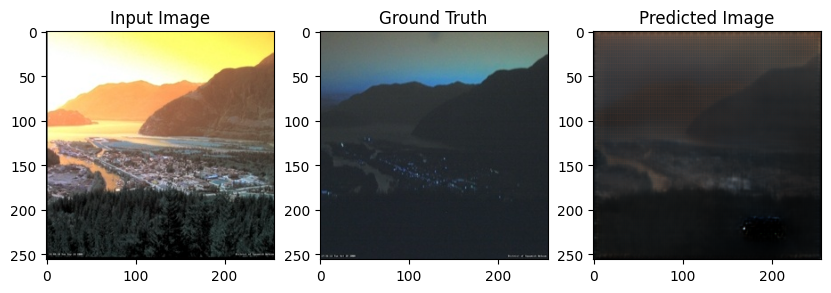

Models saved : gmodel_5000 , dmodel_5000


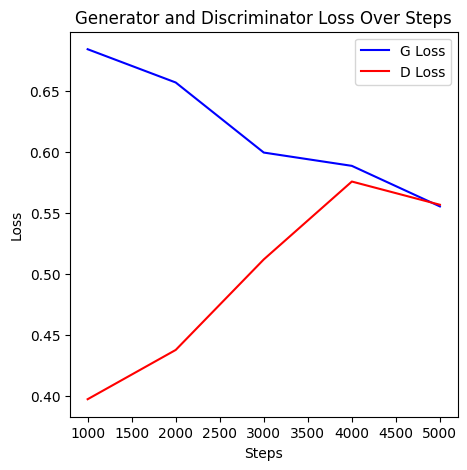

Step 5000/127560  Gen_loss: 0.37  Dis_loss: 0.279 Time: 21ms
Step 5001/127560  Gen_loss: 0.809  Dis_loss: 0.047 Time: 21ms
Step 5002/127560  Gen_loss: 0.628  Dis_loss: 0.968 Time: 20ms
Step 5003/127560  Gen_loss: 0.827  Dis_loss: 0.192 Time: 19ms
Step 5004/127560  Gen_loss: 0.875  Dis_loss: 0.052 Time: 20ms
Step 5005/127560  Gen_loss: 0.277  Dis_loss: 0.06 Time: 20ms
Step 5006/127560  Gen_loss: 0.249  Dis_loss: 2.205 Time: 19ms
Step 5007/127560  Gen_loss: 0.415  Dis_loss: 0.71 Time: 20ms
Step 5008/127560  Gen_loss: 0.603  Dis_loss: 0.792 Time: 19ms
Step 5009/127560  Gen_loss: 0.781  Dis_loss: 0.48 Time: 20ms
Step 5010/127560  Gen_loss: 0.564  Dis_loss: 0.166 Time: 20ms
Step 5011/127560  Gen_loss: 0.632  Dis_loss: 0.463 Time: 20ms
Step 5012/127560  Gen_loss: 0.925  Dis_loss: 0.101 Time: 20ms
Step 5013/127560  Gen_loss: 0.424  Dis_loss: 1.573 Time: 21ms
Step 5014/127560  Gen_loss: 0.657  Dis_loss: 0.117 Time: 21ms
Step 5015/127560  Gen_loss: 0.724  Dis_loss: 0.531 Time: 22ms
Step 5016/12

Step 5133/127560  Gen_loss: 0.315  Dis_loss: 1.446 Time: 19ms
Step 5134/127560  Gen_loss: 0.874  Dis_loss: 0.614 Time: 20ms
Step 5135/127560  Gen_loss: 0.522  Dis_loss: 0.238 Time: 18ms
Step 5136/127560  Gen_loss: 0.584  Dis_loss: 0.386 Time: 19ms
Step 5137/127560  Gen_loss: 0.873  Dis_loss: 0.241 Time: 20ms
Step 5138/127560  Gen_loss: 0.574  Dis_loss: 0.103 Time: 19ms
Step 5139/127560  Gen_loss: 0.853  Dis_loss: 0.175 Time: 18ms
Step 5140/127560  Gen_loss: 0.759  Dis_loss: 0.794 Time: 19ms
Step 5141/127560  Gen_loss: 0.507  Dis_loss: 0.17 Time: 19ms
Step 5142/127560  Gen_loss: 0.244  Dis_loss: 1.816 Time: 20ms
Step 5143/127560  Gen_loss: 0.57  Dis_loss: 0.47 Time: 18ms
Step 5144/127560  Gen_loss: 0.902  Dis_loss: 0.04 Time: 20ms
Step 5145/127560  Gen_loss: 0.659  Dis_loss: 0.224 Time: 20ms
Step 5146/127560  Gen_loss: 0.629  Dis_loss: 0.287 Time: 20ms
Step 5147/127560  Gen_loss: 0.351  Dis_loss: 1.274 Time: 21ms
Step 5148/127560  Gen_loss: 0.868  Dis_loss: 0.481 Time: 19ms
Step 5149/12

Step 5266/127560  Gen_loss: 0.335  Dis_loss: 0.969 Time: 22ms
Step 5267/127560  Gen_loss: 0.719  Dis_loss: 0.081 Time: 21ms
Step 5268/127560  Gen_loss: 0.57  Dis_loss: 0.689 Time: 20ms
Step 5269/127560  Gen_loss: 0.61  Dis_loss: 0.301 Time: 21ms
Step 5270/127560  Gen_loss: 0.534  Dis_loss: 0.094 Time: 21ms
Step 5271/127560  Gen_loss: 0.42  Dis_loss: 1.519 Time: 21ms
Step 5272/127560  Gen_loss: 0.733  Dis_loss: 0.588 Time: 22ms
Step 5273/127560  Gen_loss: 0.544  Dis_loss: 0.081 Time: 20ms
Step 5274/127560  Gen_loss: 0.602  Dis_loss: 0.24 Time: 22ms
Step 5275/127560  Gen_loss: 0.648  Dis_loss: 0.809 Time: 21ms
Step 5276/127560  Gen_loss: 0.571  Dis_loss: 0.231 Time: 21ms
Step 5277/127560  Gen_loss: 0.685  Dis_loss: 0.098 Time: 21ms
Step 5278/127560  Gen_loss: 0.377  Dis_loss: 1.841 Time: 21ms
Step 5279/127560  Gen_loss: 0.514  Dis_loss: 2.011 Time: 21ms
Step 5280/127560  Gen_loss: 0.237  Dis_loss: 3.36 Time: 21ms
Step 5281/127560  Gen_loss: 0.499  Dis_loss: 1.01 Time: 21ms
Step 5282/1275

Step 5399/127560  Gen_loss: 0.58  Dis_loss: 1.72 Time: 19ms
Step 5400/127560  Gen_loss: 0.636  Dis_loss: 0.697 Time: 19ms
Step 5401/127560  Gen_loss: 0.933  Dis_loss: 0.074 Time: 19ms
Step 5402/127560  Gen_loss: 0.851  Dis_loss: 0.831 Time: 19ms
Step 5403/127560  Gen_loss: 0.57  Dis_loss: 0.271 Time: 19ms
Step 5404/127560  Gen_loss: 0.469  Dis_loss: 0.319 Time: 19ms
Step 5405/127560  Gen_loss: 0.456  Dis_loss: 0.527 Time: 19ms
Step 5406/127560  Gen_loss: 0.562  Dis_loss: 0.228 Time: 19ms
Step 5407/127560  Gen_loss: 0.721  Dis_loss: 0.87 Time: 20ms
Step 5408/127560  Gen_loss: 0.525  Dis_loss: 0.15 Time: 19ms
Step 5409/127560  Gen_loss: 0.614  Dis_loss: 0.712 Time: 19ms
Step 5410/127560  Gen_loss: 0.598  Dis_loss: 0.263 Time: 18ms
Step 5411/127560  Gen_loss: 0.606  Dis_loss: 0.105 Time: 19ms
Step 5412/127560  Gen_loss: 0.467  Dis_loss: 0.555 Time: 21ms
Step 5413/127560  Gen_loss: 0.505  Dis_loss: 0.548 Time: 19ms
Step 5414/127560  Gen_loss: 0.538  Dis_loss: 0.194 Time: 19ms
Step 5415/127

Step 5532/127560  Gen_loss: 0.569  Dis_loss: 1.198 Time: 19ms
Step 5533/127560  Gen_loss: 0.882  Dis_loss: 0.242 Time: 19ms
Step 5534/127560  Gen_loss: 0.375  Dis_loss: 0.617 Time: 19ms
Step 5535/127560  Gen_loss: 0.515  Dis_loss: 0.298 Time: 19ms
Step 5536/127560  Gen_loss: 0.502  Dis_loss: 2.963 Time: 20ms
Step 5537/127560  Gen_loss: 0.582  Dis_loss: 0.4 Time: 19ms
Step 5538/127560  Gen_loss: 0.693  Dis_loss: 4.531 Time: 18ms
Step 5539/127560  Gen_loss: 0.848  Dis_loss: 0.2 Time: 20ms
Step 5540/127560  Gen_loss: 0.562  Dis_loss: 0.931 Time: 20ms
Step 5541/127560  Gen_loss: 0.81  Dis_loss: 1.302 Time: 19ms
Step 5542/127560  Gen_loss: 0.914  Dis_loss: 0.448 Time: 19ms
Step 5543/127560  Gen_loss: 0.702  Dis_loss: 0.352 Time: 20ms
Step 5544/127560  Gen_loss: 0.248  Dis_loss: 0.835 Time: 19ms
Step 5545/127560  Gen_loss: 0.842  Dis_loss: 1.012 Time: 18ms
Step 5546/127560  Gen_loss: 0.402  Dis_loss: 0.707 Time: 19ms
Step 5547/127560  Gen_loss: 0.576  Dis_loss: 0.391 Time: 19ms
Step 5548/127

Step 5665/127560  Gen_loss: 0.344  Dis_loss: 0.809 Time: 19ms
Step 5666/127560  Gen_loss: 0.387  Dis_loss: 0.683 Time: 20ms
Step 5667/127560  Gen_loss: 0.448  Dis_loss: 0.464 Time: 20ms
Step 5668/127560  Gen_loss: 0.585  Dis_loss: 0.879 Time: 20ms
Step 5669/127560  Gen_loss: 0.423  Dis_loss: 0.153 Time: 20ms
Step 5670/127560  Gen_loss: 0.422  Dis_loss: 0.589 Time: 20ms
Step 5671/127560  Gen_loss: 0.757  Dis_loss: 0.252 Time: 20ms
Step 5672/127560  Gen_loss: 0.397  Dis_loss: 0.541 Time: 19ms
Step 5673/127560  Gen_loss: 0.931  Dis_loss: 0.344 Time: 19ms
Step 5674/127560  Gen_loss: 0.428  Dis_loss: 0.299 Time: 20ms
Step 5675/127560  Gen_loss: 0.293  Dis_loss: 0.556 Time: 19ms
Step 5676/127560  Gen_loss: 0.638  Dis_loss: 0.311 Time: 19ms
Step 5677/127560  Gen_loss: 0.582  Dis_loss: 0.241 Time: 20ms
Step 5678/127560  Gen_loss: 0.565  Dis_loss: 0.388 Time: 20ms
Step 5679/127560  Gen_loss: 0.625  Dis_loss: 0.19 Time: 20ms
Step 5680/127560  Gen_loss: 0.498  Dis_loss: 0.183 Time: 19ms
Step 5681

Step 5798/127560  Gen_loss: 0.602  Dis_loss: 0.131 Time: 19ms
Step 5799/127560  Gen_loss: 0.624  Dis_loss: 1.306 Time: 20ms
Step 5800/127560  Gen_loss: 0.69  Dis_loss: 0.401 Time: 18ms
Step 5801/127560  Gen_loss: 0.461  Dis_loss: 0.497 Time: 19ms
Step 5802/127560  Gen_loss: 0.384  Dis_loss: 1.513 Time: 19ms
Step 5803/127560  Gen_loss: 0.283  Dis_loss: 1.038 Time: 21ms
Step 5804/127560  Gen_loss: 0.573  Dis_loss: 1.169 Time: 21ms
Step 5805/127560  Gen_loss: 0.194  Dis_loss: 0.653 Time: 22ms
Step 5806/127560  Gen_loss: 0.528  Dis_loss: 0.21 Time: 21ms
Step 5807/127560  Gen_loss: 0.509  Dis_loss: 0.194 Time: 20ms
Step 5808/127560  Gen_loss: 0.43  Dis_loss: 0.423 Time: 21ms
Step 5809/127560  Gen_loss: 0.432  Dis_loss: 0.096 Time: 21ms
Step 5810/127560  Gen_loss: 0.526  Dis_loss: 0.212 Time: 21ms
Step 5811/127560  Gen_loss: 0.371  Dis_loss: 0.398 Time: 22ms
Step 5812/127560  Gen_loss: 0.463  Dis_loss: 2.494 Time: 20ms
Step 5813/127560  Gen_loss: 0.423  Dis_loss: 1.087 Time: 22ms
Step 5814/1

Step 5931/127560  Gen_loss: 0.666  Dis_loss: 0.241 Time: 19ms
Step 5932/127560  Gen_loss: 0.415  Dis_loss: 0.096 Time: 19ms
Step 5933/127560  Gen_loss: 0.394  Dis_loss: 1.315 Time: 19ms
Step 5934/127560  Gen_loss: 0.632  Dis_loss: 0.039 Time: 19ms
Step 5935/127560  Gen_loss: 0.408  Dis_loss: 0.698 Time: 18ms
Step 5936/127560  Gen_loss: 0.358  Dis_loss: 0.673 Time: 19ms
Step 5937/127560  Gen_loss: 0.681  Dis_loss: 0.319 Time: 19ms
Step 5938/127560  Gen_loss: 0.702  Dis_loss: 0.118 Time: 18ms
Step 5939/127560  Gen_loss: 0.633  Dis_loss: 0.471 Time: 19ms
Step 5940/127560  Gen_loss: 0.458  Dis_loss: 0.412 Time: 20ms
Step 5941/127560  Gen_loss: 0.574  Dis_loss: 0.274 Time: 19ms
Step 5942/127560  Gen_loss: 0.531  Dis_loss: 0.053 Time: 19ms
Step 5943/127560  Gen_loss: 0.512  Dis_loss: 0.418 Time: 19ms
Step 5944/127560  Gen_loss: 0.548  Dis_loss: 0.857 Time: 20ms
Step 5945/127560  Gen_loss: 0.474  Dis_loss: 1.408 Time: 18ms
Step 5946/127560  Gen_loss: 0.427  Dis_loss: 0.602 Time: 19ms
Step 594

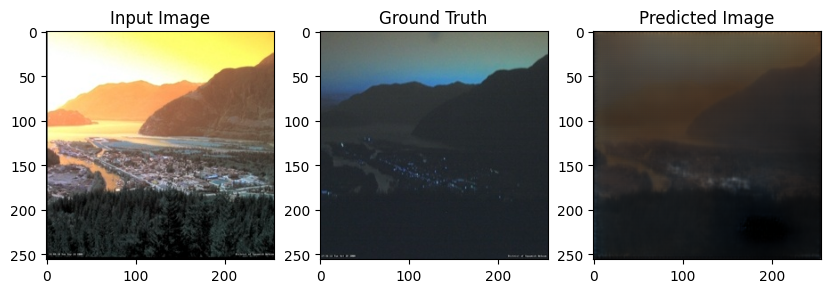

Models saved : gmodel_6000 , dmodel_6000


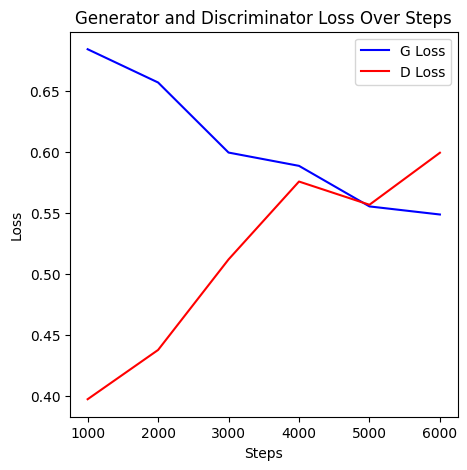

Step 6000/127560  Gen_loss: 0.83  Dis_loss: 0.139 Time: 20ms
Step 6001/127560  Gen_loss: 0.199  Dis_loss: 0.49 Time: 20ms
Step 6002/127560  Gen_loss: 0.645  Dis_loss: 0.089 Time: 20ms
Step 6003/127560  Gen_loss: 0.54  Dis_loss: 0.265 Time: 19ms
Step 6004/127560  Gen_loss: 0.416  Dis_loss: 0.612 Time: 19ms
Step 6005/127560  Gen_loss: 0.939  Dis_loss: 0.607 Time: 19ms
Step 6006/127560  Gen_loss: 0.425  Dis_loss: 0.277 Time: 19ms
Step 6007/127560  Gen_loss: 0.615  Dis_loss: 0.369 Time: 19ms
Step 6008/127560  Gen_loss: 0.656  Dis_loss: 0.583 Time: 19ms
Step 6009/127560  Gen_loss: 0.612  Dis_loss: 0.563 Time: 20ms
Step 6010/127560  Gen_loss: 0.631  Dis_loss: 0.358 Time: 20ms
Step 6011/127560  Gen_loss: 0.629  Dis_loss: 0.423 Time: 19ms
Step 6012/127560  Gen_loss: 0.588  Dis_loss: 0.297 Time: 20ms
Step 6013/127560  Gen_loss: 0.529  Dis_loss: 0.038 Time: 20ms
Step 6014/127560  Gen_loss: 0.459  Dis_loss: 1.713 Time: 20ms
Step 6015/127560  Gen_loss: 0.645  Dis_loss: 0.383 Time: 20ms
Step 6016/1

Step 6133/127560  Gen_loss: 0.537  Dis_loss: 0.216 Time: 19ms
Step 6134/127560  Gen_loss: 0.498  Dis_loss: 0.2 Time: 20ms
Step 6135/127560  Gen_loss: 0.71  Dis_loss: 0.238 Time: 19ms
Step 6136/127560  Gen_loss: 0.524  Dis_loss: 0.38 Time: 19ms
Step 6137/127560  Gen_loss: 0.408  Dis_loss: 1.956 Time: 19ms
Step 6138/127560  Gen_loss: 0.479  Dis_loss: 0.398 Time: 20ms
Step 6139/127560  Gen_loss: 0.51  Dis_loss: 1.3 Time: 20ms
Step 6140/127560  Gen_loss: 0.665  Dis_loss: 1.214 Time: 19ms
Step 6141/127560  Gen_loss: 0.223  Dis_loss: 0.154 Time: 20ms
Step 6142/127560  Gen_loss: 0.496  Dis_loss: 0.338 Time: 20ms
Step 6143/127560  Gen_loss: 0.307  Dis_loss: 0.502 Time: 19ms
Step 6144/127560  Gen_loss: 0.566  Dis_loss: 0.331 Time: 19ms
Step 6145/127560  Gen_loss: 0.608  Dis_loss: 0.102 Time: 20ms
Step 6146/127560  Gen_loss: 0.325  Dis_loss: 0.199 Time: 19ms
Step 6147/127560  Gen_loss: 0.994  Dis_loss: 0.455 Time: 19ms
Step 6148/127560  Gen_loss: 0.638  Dis_loss: 0.371 Time: 19ms
Step 6149/12756

Step 6266/127560  Gen_loss: 0.402  Dis_loss: 0.16 Time: 21ms
Step 6267/127560  Gen_loss: 0.977  Dis_loss: 0.269 Time: 19ms
Step 6268/127560  Gen_loss: 0.504  Dis_loss: 0.176 Time: 19ms
Step 6269/127560  Gen_loss: 0.558  Dis_loss: 0.206 Time: 19ms
Step 6270/127560  Gen_loss: 0.904  Dis_loss: 0.066 Time: 19ms
Step 6271/127560  Gen_loss: 0.353  Dis_loss: 1.541 Time: 18ms
Step 6272/127560  Gen_loss: 0.481  Dis_loss: 0.139 Time: 20ms
Step 6273/127560  Gen_loss: 0.716  Dis_loss: 0.722 Time: 19ms
Step 6274/127560  Gen_loss: 0.287  Dis_loss: 1.41 Time: 19ms
Step 6275/127560  Gen_loss: 0.547  Dis_loss: 0.678 Time: 19ms
Step 6276/127560  Gen_loss: 0.405  Dis_loss: 1.01 Time: 19ms
Step 6277/127560  Gen_loss: 0.523  Dis_loss: 0.618 Time: 19ms
Step 6278/127560  Gen_loss: 0.637  Dis_loss: 0.202 Time: 19ms
Step 6279/127560  Gen_loss: 0.595  Dis_loss: 0.176 Time: 19ms
Step 6280/127560  Gen_loss: 0.545  Dis_loss: 0.507 Time: 19ms
Step 6281/127560  Gen_loss: 0.285  Dis_loss: 0.65 Time: 19ms
Step 6282/12

Step 6399/127560  Gen_loss: 0.565  Dis_loss: 0.389 Time: 19ms
Step 6400/127560  Gen_loss: 0.383  Dis_loss: 0.348 Time: 19ms
Step 6401/127560  Gen_loss: 0.505  Dis_loss: 0.593 Time: 19ms
Step 6402/127560  Gen_loss: 0.246  Dis_loss: 0.81 Time: 19ms
Step 6403/127560  Gen_loss: 0.494  Dis_loss: 0.079 Time: 19ms
Step 6404/127560  Gen_loss: 0.256  Dis_loss: 0.79 Time: 19ms
Step 6405/127560  Gen_loss: 0.425  Dis_loss: 0.369 Time: 18ms
Step 6406/127560  Gen_loss: 0.591  Dis_loss: 1.198 Time: 19ms
Step 6407/127560  Gen_loss: 0.28  Dis_loss: 0.81 Time: 19ms
Step 6408/127560  Gen_loss: 0.62  Dis_loss: 0.634 Time: 19ms
Step 6409/127560  Gen_loss: 0.569  Dis_loss: 0.379 Time: 20ms
Step 6410/127560  Gen_loss: 0.601  Dis_loss: 0.28 Time: 19ms
Step 6411/127560  Gen_loss: 0.992  Dis_loss: 0.081 Time: 19ms
Step 6412/127560  Gen_loss: 0.588  Dis_loss: 1.224 Time: 19ms
Step 6413/127560  Gen_loss: 0.691  Dis_loss: 0.978 Time: 19ms
Step 6414/127560  Gen_loss: 0.347  Dis_loss: 1.385 Time: 18ms
Step 6415/1275

Step 6532/127560  Gen_loss: 0.408  Dis_loss: 0.966 Time: 19ms
Step 6533/127560  Gen_loss: 0.782  Dis_loss: 0.489 Time: 19ms
Step 6534/127560  Gen_loss: 0.186  Dis_loss: 0.717 Time: 20ms
Step 6535/127560  Gen_loss: 0.55  Dis_loss: 0.13 Time: 19ms
Step 6536/127560  Gen_loss: 0.234  Dis_loss: 0.052 Time: 19ms
Step 6537/127560  Gen_loss: 0.746  Dis_loss: 0.089 Time: 20ms
Step 6538/127560  Gen_loss: 0.544  Dis_loss: 0.189 Time: 19ms
Step 6539/127560  Gen_loss: 0.534  Dis_loss: 0.174 Time: 20ms
Step 6540/127560  Gen_loss: 0.626  Dis_loss: 0.147 Time: 21ms
Step 6541/127560  Gen_loss: 0.609  Dis_loss: 0.242 Time: 19ms
Step 6542/127560  Gen_loss: 0.946  Dis_loss: 0.134 Time: 19ms
Step 6543/127560  Gen_loss: 0.573  Dis_loss: 0.344 Time: 19ms
Step 6544/127560  Gen_loss: 0.686  Dis_loss: 0.115 Time: 19ms
Step 6545/127560  Gen_loss: 0.951  Dis_loss: 0.098 Time: 19ms
Step 6546/127560  Gen_loss: 0.772  Dis_loss: 0.513 Time: 20ms
Step 6547/127560  Gen_loss: 0.417  Dis_loss: 0.851 Time: 19ms
Step 6548/

Step 6665/127560  Gen_loss: 0.427  Dis_loss: 0.426 Time: 19ms
Step 6666/127560  Gen_loss: 0.44  Dis_loss: 0.53 Time: 19ms
Step 6667/127560  Gen_loss: 0.481  Dis_loss: 0.31 Time: 20ms
Step 6668/127560  Gen_loss: 0.173  Dis_loss: 0.713 Time: 21ms
Step 6669/127560  Gen_loss: 0.841  Dis_loss: 0.282 Time: 20ms
Step 6670/127560  Gen_loss: 0.463  Dis_loss: 0.355 Time: 19ms
Step 6671/127560  Gen_loss: 0.567  Dis_loss: 0.306 Time: 19ms
Step 6672/127560  Gen_loss: 0.51  Dis_loss: 0.184 Time: 19ms
Step 6673/127560  Gen_loss: 0.574  Dis_loss: 0.324 Time: 19ms
Step 6674/127560  Gen_loss: 0.758  Dis_loss: 0.217 Time: 19ms
Step 6675/127560  Gen_loss: 0.504  Dis_loss: 2.016 Time: 19ms
Step 6676/127560  Gen_loss: 0.698  Dis_loss: 0.312 Time: 20ms
Step 6677/127560  Gen_loss: 0.48  Dis_loss: 0.468 Time: 20ms
Step 6678/127560  Gen_loss: 0.504  Dis_loss: 0.647 Time: 19ms
Step 6679/127560  Gen_loss: 0.378  Dis_loss: 1.271 Time: 19ms
Step 6680/127560  Gen_loss: 0.581  Dis_loss: 0.398 Time: 19ms
Step 6681/127

Step 6798/127560  Gen_loss: 0.741  Dis_loss: 0.092 Time: 20ms
Step 6799/127560  Gen_loss: 0.315  Dis_loss: 1.42 Time: 19ms
Step 6800/127560  Gen_loss: 0.832  Dis_loss: 3.353 Time: 20ms
Step 6801/127560  Gen_loss: 0.809  Dis_loss: 0.436 Time: 20ms
Step 6802/127560  Gen_loss: 0.298  Dis_loss: 4.809 Time: 19ms
Step 6803/127560  Gen_loss: 0.401  Dis_loss: 1.836 Time: 20ms
Step 6804/127560  Gen_loss: 0.614  Dis_loss: 0.433 Time: 20ms
Step 6805/127560  Gen_loss: 0.178  Dis_loss: 2.658 Time: 20ms
Step 6806/127560  Gen_loss: 0.561  Dis_loss: 1.679 Time: 19ms
Step 6807/127560  Gen_loss: 0.418  Dis_loss: 1.625 Time: 20ms
Step 6808/127560  Gen_loss: 0.848  Dis_loss: 0.979 Time: 19ms
Step 6809/127560  Gen_loss: 0.452  Dis_loss: 1.021 Time: 19ms
Step 6810/127560  Gen_loss: 0.562  Dis_loss: 0.234 Time: 19ms
Step 6811/127560  Gen_loss: 0.54  Dis_loss: 0.286 Time: 19ms
Step 6812/127560  Gen_loss: 0.579  Dis_loss: 0.267 Time: 21ms
Step 6813/127560  Gen_loss: 0.495  Dis_loss: 1.277 Time: 20ms
Step 6814/

Step 6931/127560  Gen_loss: 0.618  Dis_loss: 0.411 Time: 20ms
Step 6932/127560  Gen_loss: 0.382  Dis_loss: 0.667 Time: 19ms
Step 6933/127560  Gen_loss: 0.509  Dis_loss: 0.5 Time: 19ms
Step 6934/127560  Gen_loss: 0.434  Dis_loss: 0.435 Time: 19ms
Step 6935/127560  Gen_loss: 0.297  Dis_loss: 0.396 Time: 20ms
Step 6936/127560  Gen_loss: 0.761  Dis_loss: 0.134 Time: 19ms
Step 6937/127560  Gen_loss: 0.44  Dis_loss: 0.821 Time: 20ms
Step 6938/127560  Gen_loss: 0.2  Dis_loss: 0.903 Time: 19ms
Step 6939/127560  Gen_loss: 0.814  Dis_loss: 0.295 Time: 20ms
Step 6940/127560  Gen_loss: 0.478  Dis_loss: 1.628 Time: 19ms
Step 6941/127560  Gen_loss: 0.598  Dis_loss: 0.14 Time: 19ms
Step 6942/127560  Gen_loss: 0.672  Dis_loss: 0.183 Time: 20ms
Step 6943/127560  Gen_loss: 0.592  Dis_loss: 1.721 Time: 19ms
Step 6944/127560  Gen_loss: 0.634  Dis_loss: 0.217 Time: 19ms
Step 6945/127560  Gen_loss: 0.652  Dis_loss: 0.761 Time: 20ms
Step 6946/127560  Gen_loss: 0.536  Dis_loss: 0.287 Time: 19ms
Step 6947/1275

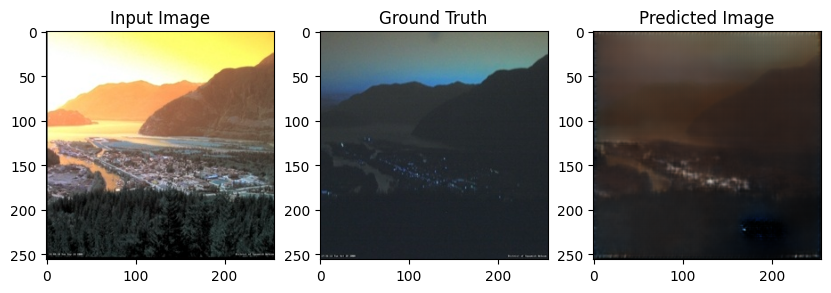

Models saved : gmodel_7000 , dmodel_7000


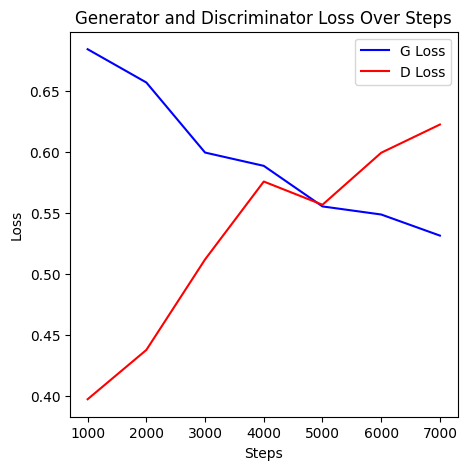

Step 7000/127560  Gen_loss: 0.63  Dis_loss: 0.22 Time: 19ms
Step 7001/127560  Gen_loss: 0.534  Dis_loss: 0.825 Time: 21ms
Step 7002/127560  Gen_loss: 0.502  Dis_loss: 1.426 Time: 20ms
Step 7003/127560  Gen_loss: 0.526  Dis_loss: 0.302 Time: 19ms
Step 7004/127560  Gen_loss: 0.653  Dis_loss: 0.13 Time: 21ms
Step 7005/127560  Gen_loss: 0.19  Dis_loss: 1.018 Time: 19ms
Step 7006/127560  Gen_loss: 0.608  Dis_loss: 0.108 Time: 19ms
Step 7007/127560  Gen_loss: 0.551  Dis_loss: 0.043 Time: 20ms
Step 7008/127560  Gen_loss: 0.577  Dis_loss: 0.527 Time: 20ms
Step 7009/127560  Gen_loss: 0.836  Dis_loss: 0.223 Time: 21ms
Step 7010/127560  Gen_loss: 0.94  Dis_loss: 0.053 Time: 19ms
Step 7011/127560  Gen_loss: 0.983  Dis_loss: 0.988 Time: 19ms
Step 7012/127560  Gen_loss: 0.477  Dis_loss: 0.4 Time: 19ms
Step 7013/127560  Gen_loss: 0.432  Dis_loss: 0.15 Time: 20ms
Step 7014/127560  Gen_loss: 0.68  Dis_loss: 0.235 Time: 20ms
Step 7015/127560  Gen_loss: 0.281  Dis_loss: 0.869 Time: 19ms
Step 7016/127560 

Step 7133/127560  Gen_loss: 0.682  Dis_loss: 0.338 Time: 19ms
Step 7134/127560  Gen_loss: 0.442  Dis_loss: 2.413 Time: 19ms
Step 7135/127560  Gen_loss: 0.327  Dis_loss: 0.653 Time: 20ms
Step 7136/127560  Gen_loss: 0.765  Dis_loss: 0.213 Time: 19ms
Step 7137/127560  Gen_loss: 0.405  Dis_loss: 0.342 Time: 19ms
Step 7138/127560  Gen_loss: 0.463  Dis_loss: 0.44 Time: 20ms
Step 7139/127560  Gen_loss: 0.525  Dis_loss: 0.7 Time: 19ms
Step 7140/127560  Gen_loss: 0.277  Dis_loss: 0.646 Time: 19ms
Step 7141/127560  Gen_loss: 0.726  Dis_loss: 0.196 Time: 19ms
Step 7142/127560  Gen_loss: 0.5  Dis_loss: 0.134 Time: 19ms
Step 7143/127560  Gen_loss: 0.511  Dis_loss: 0.154 Time: 19ms
Step 7144/127560  Gen_loss: 0.207  Dis_loss: 1.115 Time: 20ms
Step 7145/127560  Gen_loss: 0.245  Dis_loss: 0.288 Time: 19ms
Step 7146/127560  Gen_loss: 0.497  Dis_loss: 0.362 Time: 19ms
Step 7147/127560  Gen_loss: 0.589  Dis_loss: 0.187 Time: 18ms
Step 7148/127560  Gen_loss: 0.267  Dis_loss: 0.76 Time: 19ms
Step 7149/1275

Step 7266/127560  Gen_loss: 0.228  Dis_loss: 0.714 Time: 20ms
Step 7267/127560  Gen_loss: 0.629  Dis_loss: 0.361 Time: 19ms
Step 7268/127560  Gen_loss: 0.459  Dis_loss: 0.109 Time: 19ms
Step 7269/127560  Gen_loss: 0.618  Dis_loss: 0.75 Time: 19ms
Step 7270/127560  Gen_loss: 0.733  Dis_loss: 0.085 Time: 19ms
Step 7271/127560  Gen_loss: 0.859  Dis_loss: 0.193 Time: 19ms
Step 7272/127560  Gen_loss: 0.177  Dis_loss: 1.016 Time: 19ms
Step 7273/127560  Gen_loss: 0.919  Dis_loss: 0.053 Time: 18ms
Step 7274/127560  Gen_loss: 0.832  Dis_loss: 0.482 Time: 20ms
Step 7275/127560  Gen_loss: 0.571  Dis_loss: 0.811 Time: 18ms
Step 7276/127560  Gen_loss: 0.279  Dis_loss: 1.242 Time: 19ms
Step 7277/127560  Gen_loss: 0.277  Dis_loss: 0.731 Time: 20ms
Step 7278/127560  Gen_loss: 0.526  Dis_loss: 0.631 Time: 20ms
Step 7279/127560  Gen_loss: 0.667  Dis_loss: 1.661 Time: 19ms
Step 7280/127560  Gen_loss: 0.837  Dis_loss: 0.432 Time: 20ms
Step 7281/127560  Gen_loss: 0.638  Dis_loss: 0.041 Time: 19ms
Step 7282

Step 7399/127560  Gen_loss: 0.419  Dis_loss: 0.134 Time: 19ms
Step 7400/127560  Gen_loss: 0.671  Dis_loss: 1.177 Time: 20ms
Step 7401/127560  Gen_loss: 0.631  Dis_loss: 0.304 Time: 19ms
Step 7402/127560  Gen_loss: 0.492  Dis_loss: 0.968 Time: 20ms
Step 7403/127560  Gen_loss: 0.495  Dis_loss: 0.78 Time: 19ms
Step 7404/127560  Gen_loss: 0.518  Dis_loss: 0.805 Time: 20ms
Step 7405/127560  Gen_loss: 0.425  Dis_loss: 0.174 Time: 19ms
Step 7406/127560  Gen_loss: 0.193  Dis_loss: 0.36 Time: 20ms
Step 7407/127560  Gen_loss: 0.667  Dis_loss: 0.602 Time: 20ms
Step 7408/127560  Gen_loss: 0.957  Dis_loss: 0.047 Time: 20ms
Step 7409/127560  Gen_loss: 0.44  Dis_loss: 0.91 Time: 19ms
Step 7410/127560  Gen_loss: 0.42  Dis_loss: 0.676 Time: 19ms
Step 7411/127560  Gen_loss: 0.206  Dis_loss: 1.14 Time: 19ms
Step 7412/127560  Gen_loss: 0.404  Dis_loss: 0.866 Time: 19ms
Step 7413/127560  Gen_loss: 0.598  Dis_loss: 0.651 Time: 19ms
Step 7414/127560  Gen_loss: 0.368  Dis_loss: 0.264 Time: 19ms
Step 7415/1275

Step 7532/127560  Gen_loss: 0.448  Dis_loss: 1.347 Time: 19ms
Step 7533/127560  Gen_loss: 0.148  Dis_loss: 0.549 Time: 19ms
Step 7534/127560  Gen_loss: 0.428  Dis_loss: 0.879 Time: 19ms
Step 7535/127560  Gen_loss: 0.731  Dis_loss: 0.78 Time: 20ms
Step 7536/127560  Gen_loss: 0.181  Dis_loss: 0.741 Time: 19ms
Step 7537/127560  Gen_loss: 0.839  Dis_loss: 0.115 Time: 19ms
Step 7538/127560  Gen_loss: 0.505  Dis_loss: 0.037 Time: 19ms
Step 7539/127560  Gen_loss: 0.682  Dis_loss: 0.41 Time: 20ms
Step 7540/127560  Gen_loss: 0.799  Dis_loss: 0.394 Time: 19ms
Step 7541/127560  Gen_loss: 0.778  Dis_loss: 0.048 Time: 19ms
Step 7542/127560  Gen_loss: 0.542  Dis_loss: 0.492 Time: 19ms
Step 7543/127560  Gen_loss: 0.701  Dis_loss: 0.241 Time: 19ms
Step 7544/127560  Gen_loss: 0.427  Dis_loss: 0.293 Time: 20ms
Step 7545/127560  Gen_loss: 0.566  Dis_loss: 0.31 Time: 19ms
Step 7546/127560  Gen_loss: 0.385  Dis_loss: 0.946 Time: 19ms
Step 7547/127560  Gen_loss: 0.788  Dis_loss: 0.25 Time: 19ms
Step 7548/12

Step 7665/127560  Gen_loss: 0.417  Dis_loss: 0.643 Time: 20ms
Step 7666/127560  Gen_loss: 0.67  Dis_loss: 1.742 Time: 20ms
Step 7667/127560  Gen_loss: 0.626  Dis_loss: 1.127 Time: 19ms
Step 7668/127560  Gen_loss: 0.256  Dis_loss: 1.275 Time: 19ms
Step 7669/127560  Gen_loss: 0.568  Dis_loss: 0.225 Time: 18ms
Step 7670/127560  Gen_loss: 0.495  Dis_loss: 0.081 Time: 19ms
Step 7671/127560  Gen_loss: 0.812  Dis_loss: 0.46 Time: 19ms
Step 7672/127560  Gen_loss: 0.384  Dis_loss: 1.448 Time: 19ms
Step 7673/127560  Gen_loss: 0.451  Dis_loss: 0.16 Time: 19ms
Step 7674/127560  Gen_loss: 0.946  Dis_loss: 0.239 Time: 19ms
Step 7675/127560  Gen_loss: 0.691  Dis_loss: 0.688 Time: 20ms
Step 7676/127560  Gen_loss: 0.466  Dis_loss: 1.509 Time: 19ms
Step 7677/127560  Gen_loss: 0.543  Dis_loss: 0.397 Time: 20ms
Step 7678/127560  Gen_loss: 0.631  Dis_loss: 1.049 Time: 18ms
Step 7679/127560  Gen_loss: 0.325  Dis_loss: 1.144 Time: 19ms
Step 7680/127560  Gen_loss: 0.91  Dis_loss: 0.172 Time: 19ms
Step 7681/12

Step 7798/127560  Gen_loss: 0.178  Dis_loss: 0.617 Time: 20ms
Step 7799/127560  Gen_loss: 0.378  Dis_loss: 0.465 Time: 21ms
Step 7800/127560  Gen_loss: 0.434  Dis_loss: 0.37 Time: 21ms
Step 7801/127560  Gen_loss: 0.174  Dis_loss: 0.269 Time: 21ms
Step 7802/127560  Gen_loss: 0.562  Dis_loss: 0.476 Time: 21ms
Step 7803/127560  Gen_loss: 0.653  Dis_loss: 0.128 Time: 20ms
Step 7804/127560  Gen_loss: 0.629  Dis_loss: 0.245 Time: 20ms
Step 7805/127560  Gen_loss: 0.393  Dis_loss: 0.199 Time: 21ms
Step 7806/127560  Gen_loss: 0.516  Dis_loss: 0.07 Time: 20ms
Step 7807/127560  Gen_loss: 0.527  Dis_loss: 0.086 Time: 22ms
Step 7808/127560  Gen_loss: 0.498  Dis_loss: 0.535 Time: 21ms
Step 7809/127560  Gen_loss: 0.493  Dis_loss: 0.59 Time: 21ms
Step 7810/127560  Gen_loss: 0.435  Dis_loss: 0.142 Time: 22ms
Step 7811/127560  Gen_loss: 0.587  Dis_loss: 0.11 Time: 20ms
Step 7812/127560  Gen_loss: 0.556  Dis_loss: 0.32 Time: 22ms
Step 7813/127560  Gen_loss: 0.283  Dis_loss: 1.278 Time: 21ms
Step 7814/127

Step 7931/127560  Gen_loss: 0.82  Dis_loss: 0.992 Time: 19ms
Step 7932/127560  Gen_loss: 0.431  Dis_loss: 0.216 Time: 19ms
Step 7933/127560  Gen_loss: 0.539  Dis_loss: 0.722 Time: 20ms
Step 7934/127560  Gen_loss: 0.716  Dis_loss: 0.186 Time: 19ms
Step 7935/127560  Gen_loss: 0.801  Dis_loss: 1.041 Time: 20ms
Step 7936/127560  Gen_loss: 0.47  Dis_loss: 0.457 Time: 21ms
Step 7937/127560  Gen_loss: 0.452  Dis_loss: 0.263 Time: 20ms
Step 7938/127560  Gen_loss: 0.618  Dis_loss: 0.178 Time: 21ms
Step 7939/127560  Gen_loss: 0.444  Dis_loss: 0.915 Time: 19ms
Step 7940/127560  Gen_loss: 0.558  Dis_loss: 0.359 Time: 21ms
Step 7941/127560  Gen_loss: 0.394  Dis_loss: 0.643 Time: 20ms
Step 7942/127560  Gen_loss: 0.549  Dis_loss: 0.201 Time: 20ms
Step 7943/127560  Gen_loss: 0.62  Dis_loss: 0.4 Time: 21ms
Step 7944/127560  Gen_loss: 0.44  Dis_loss: 1.626 Time: 20ms
Step 7945/127560  Gen_loss: 0.462  Dis_loss: 2.107 Time: 20ms
Step 7946/127560  Gen_loss: 0.395  Dis_loss: 0.066 Time: 19ms
Step 7947/1275

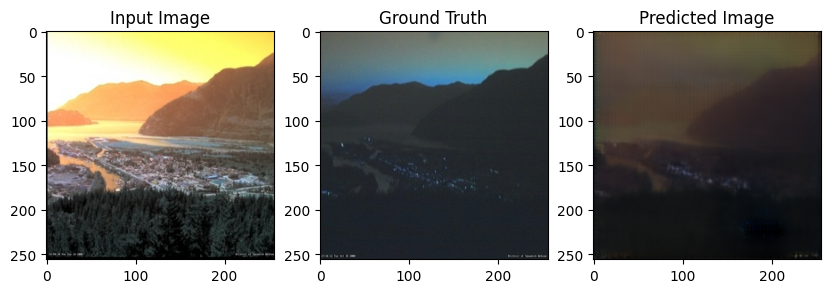

Models saved : gmodel_8000 , dmodel_8000


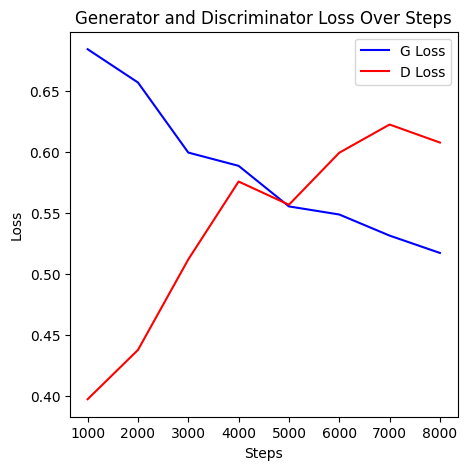

Step 8000/127560  Gen_loss: 0.394  Dis_loss: 0.37 Time: 19ms
Step 8001/127560  Gen_loss: 0.521  Dis_loss: 0.655 Time: 19ms
Step 8002/127560  Gen_loss: 0.852  Dis_loss: 1.025 Time: 20ms
Step 8003/127560  Gen_loss: 0.65  Dis_loss: 0.168 Time: 20ms
Step 8004/127560  Gen_loss: 0.207  Dis_loss: 1.098 Time: 19ms
Step 8005/127560  Gen_loss: 0.705  Dis_loss: 0.588 Time: 19ms
Step 8006/127560  Gen_loss: 0.48  Dis_loss: 0.07 Time: 19ms
Step 8007/127560  Gen_loss: 0.554  Dis_loss: 0.143 Time: 20ms
Step 8008/127560  Gen_loss: 0.522  Dis_loss: 0.501 Time: 20ms
Step 8009/127560  Gen_loss: 0.534  Dis_loss: 0.369 Time: 19ms
Step 8010/127560  Gen_loss: 0.53  Dis_loss: 0.137 Time: 19ms
Step 8011/127560  Gen_loss: 0.486  Dis_loss: 0.691 Time: 19ms
Step 8012/127560  Gen_loss: 0.492  Dis_loss: 2.035 Time: 19ms
Step 8013/127560  Gen_loss: 0.518  Dis_loss: 0.265 Time: 20ms
Step 8014/127560  Gen_loss: 0.601  Dis_loss: 0.529 Time: 19ms
Step 8015/127560  Gen_loss: 0.514  Dis_loss: 1.282 Time: 20ms
Step 8016/127

Step 8133/127560  Gen_loss: 0.815  Dis_loss: 0.202 Time: 20ms
Step 8134/127560  Gen_loss: 0.544  Dis_loss: 0.238 Time: 21ms
Step 8135/127560  Gen_loss: 0.185  Dis_loss: 1.0 Time: 20ms
Step 8136/127560  Gen_loss: 0.668  Dis_loss: 0.244 Time: 20ms
Step 8137/127560  Gen_loss: 0.544  Dis_loss: 0.233 Time: 19ms
Step 8138/127560  Gen_loss: 0.533  Dis_loss: 0.076 Time: 20ms
Step 8139/127560  Gen_loss: 0.577  Dis_loss: 0.71 Time: 19ms
Step 8140/127560  Gen_loss: 0.402  Dis_loss: 0.574 Time: 20ms
Step 8141/127560  Gen_loss: 0.355  Dis_loss: 0.537 Time: 19ms
Step 8142/127560  Gen_loss: 0.696  Dis_loss: 0.46 Time: 19ms
Step 8143/127560  Gen_loss: 0.443  Dis_loss: 0.338 Time: 19ms
Step 8144/127560  Gen_loss: 0.547  Dis_loss: 0.047 Time: 20ms
Step 8145/127560  Gen_loss: 0.337  Dis_loss: 1.547 Time: 20ms
Step 8146/127560  Gen_loss: 0.995  Dis_loss: 0.138 Time: 19ms
Step 8147/127560  Gen_loss: 0.517  Dis_loss: 0.286 Time: 20ms
Step 8148/127560  Gen_loss: 0.534  Dis_loss: 0.368 Time: 20ms
Step 8149/12

Step 8266/127560  Gen_loss: 0.234  Dis_loss: 0.745 Time: 19ms
Step 8267/127560  Gen_loss: 0.411  Dis_loss: 1.21 Time: 19ms
Step 8268/127560  Gen_loss: 0.165  Dis_loss: 1.644 Time: 20ms
Step 8269/127560  Gen_loss: 0.185  Dis_loss: 0.715 Time: 19ms
Step 8270/127560  Gen_loss: 0.565  Dis_loss: 0.412 Time: 20ms
Step 8271/127560  Gen_loss: 0.424  Dis_loss: 0.292 Time: 19ms
Step 8272/127560  Gen_loss: 0.562  Dis_loss: 0.018 Time: 19ms
Step 8273/127560  Gen_loss: 0.633  Dis_loss: 0.05 Time: 19ms
Step 8274/127560  Gen_loss: 0.502  Dis_loss: 0.381 Time: 19ms
Step 8275/127560  Gen_loss: 0.319  Dis_loss: 2.631 Time: 19ms
Step 8276/127560  Gen_loss: 0.715  Dis_loss: 0.854 Time: 20ms
Step 8277/127560  Gen_loss: 0.644  Dis_loss: 0.6 Time: 19ms
Step 8278/127560  Gen_loss: 0.716  Dis_loss: 0.163 Time: 20ms
Step 8279/127560  Gen_loss: 0.581  Dis_loss: 0.401 Time: 20ms
Step 8280/127560  Gen_loss: 0.831  Dis_loss: 0.109 Time: 20ms
Step 8281/127560  Gen_loss: 0.808  Dis_loss: 0.278 Time: 19ms
Step 8282/12

Step 8399/127560  Gen_loss: 0.618  Dis_loss: 0.366 Time: 19ms
Step 8400/127560  Gen_loss: 0.699  Dis_loss: 0.909 Time: 19ms
Step 8401/127560  Gen_loss: 0.414  Dis_loss: 0.829 Time: 19ms
Step 8402/127560  Gen_loss: 0.541  Dis_loss: 0.772 Time: 19ms
Step 8403/127560  Gen_loss: 0.456  Dis_loss: 1.049 Time: 19ms
Step 8404/127560  Gen_loss: 0.425  Dis_loss: 0.516 Time: 20ms
Step 8405/127560  Gen_loss: 0.188  Dis_loss: 0.864 Time: 19ms
Step 8406/127560  Gen_loss: 0.245  Dis_loss: 0.548 Time: 20ms
Step 8407/127560  Gen_loss: 0.466  Dis_loss: 0.181 Time: 19ms
Step 8408/127560  Gen_loss: 0.548  Dis_loss: 2.024 Time: 20ms
Step 8409/127560  Gen_loss: 0.144  Dis_loss: 0.552 Time: 19ms
Step 8410/127560  Gen_loss: 0.73  Dis_loss: 0.435 Time: 20ms
Step 8411/127560  Gen_loss: 0.512  Dis_loss: 0.542 Time: 19ms
Step 8412/127560  Gen_loss: 0.657  Dis_loss: 1.21 Time: 20ms
Step 8413/127560  Gen_loss: 0.208  Dis_loss: 0.899 Time: 19ms
Step 8414/127560  Gen_loss: 0.561  Dis_loss: 0.623 Time: 19ms
Step 8415/

Step 8532/127560  Gen_loss: 0.436  Dis_loss: 0.347 Time: 20ms
Step 8533/127560  Gen_loss: 0.772  Dis_loss: 0.172 Time: 21ms
Step 8534/127560  Gen_loss: 0.426  Dis_loss: 0.45 Time: 21ms
Step 8535/127560  Gen_loss: 0.647  Dis_loss: 0.048 Time: 22ms
Step 8536/127560  Gen_loss: 0.495  Dis_loss: 0.178 Time: 21ms
Step 8537/127560  Gen_loss: 0.411  Dis_loss: 0.847 Time: 21ms
Step 8538/127560  Gen_loss: 0.522  Dis_loss: 0.841 Time: 21ms
Step 8539/127560  Gen_loss: 0.54  Dis_loss: 0.073 Time: 20ms
Step 8540/127560  Gen_loss: 0.412  Dis_loss: 0.223 Time: 21ms
Step 8541/127560  Gen_loss: 0.488  Dis_loss: 0.492 Time: 21ms
Step 8542/127560  Gen_loss: 0.504  Dis_loss: 0.671 Time: 22ms
Step 8543/127560  Gen_loss: 0.423  Dis_loss: 0.273 Time: 21ms
Step 8544/127560  Gen_loss: 0.248  Dis_loss: 0.485 Time: 21ms
Step 8545/127560  Gen_loss: 0.176  Dis_loss: 1.0 Time: 21ms
Step 8546/127560  Gen_loss: 0.251  Dis_loss: 0.482 Time: 21ms
Step 8547/127560  Gen_loss: 0.383  Dis_loss: 1.388 Time: 21ms
Step 8548/12

Step 8665/127560  Gen_loss: 0.316  Dis_loss: 0.165 Time: 20ms
Step 8666/127560  Gen_loss: 0.566  Dis_loss: 0.413 Time: 19ms
Step 8667/127560  Gen_loss: 0.367  Dis_loss: 0.117 Time: 20ms
Step 8668/127560  Gen_loss: 0.616  Dis_loss: 0.265 Time: 20ms
Step 8669/127560  Gen_loss: 0.848  Dis_loss: 0.818 Time: 19ms
Step 8670/127560  Gen_loss: 0.537  Dis_loss: 0.545 Time: 21ms
Step 8671/127560  Gen_loss: 0.814  Dis_loss: 0.171 Time: 20ms
Step 8672/127560  Gen_loss: 0.457  Dis_loss: 2.384 Time: 19ms
Step 8673/127560  Gen_loss: 0.596  Dis_loss: 0.295 Time: 19ms
Step 8674/127560  Gen_loss: 0.563  Dis_loss: 1.665 Time: 19ms
Step 8675/127560  Gen_loss: 0.532  Dis_loss: 0.212 Time: 21ms
Step 8676/127560  Gen_loss: 0.41  Dis_loss: 0.461 Time: 19ms
Step 8677/127560  Gen_loss: 0.22  Dis_loss: 0.182 Time: 18ms
Step 8678/127560  Gen_loss: 0.555  Dis_loss: 0.43 Time: 19ms
Step 8679/127560  Gen_loss: 0.436  Dis_loss: 1.389 Time: 19ms
Step 8680/127560  Gen_loss: 0.563  Dis_loss: 0.134 Time: 19ms
Step 8681/1

Step 8798/127560  Gen_loss: 0.359  Dis_loss: 0.499 Time: 19ms
Step 8799/127560  Gen_loss: 0.585  Dis_loss: 0.34 Time: 21ms
Step 8800/127560  Gen_loss: 0.688  Dis_loss: 0.792 Time: 19ms
Step 8801/127560  Gen_loss: 0.638  Dis_loss: 0.306 Time: 19ms
Step 8802/127560  Gen_loss: 0.485  Dis_loss: 0.917 Time: 19ms
Step 8803/127560  Gen_loss: 0.324  Dis_loss: 0.619 Time: 19ms
Step 8804/127560  Gen_loss: 0.563  Dis_loss: 0.781 Time: 19ms
Step 8805/127560  Gen_loss: 0.515  Dis_loss: 0.626 Time: 20ms
Step 8806/127560  Gen_loss: 0.87  Dis_loss: 0.12 Time: 20ms
Step 8807/127560  Gen_loss: 0.243  Dis_loss: 0.854 Time: 20ms
Step 8808/127560  Gen_loss: 0.229  Dis_loss: 1.345 Time: 19ms
Step 8809/127560  Gen_loss: 0.532  Dis_loss: 0.392 Time: 19ms
Step 8810/127560  Gen_loss: 0.408  Dis_loss: 0.432 Time: 20ms
Step 8811/127560  Gen_loss: 0.831  Dis_loss: 0.141 Time: 19ms
Step 8812/127560  Gen_loss: 0.797  Dis_loss: 0.746 Time: 19ms
Step 8813/127560  Gen_loss: 0.451  Dis_loss: 0.473 Time: 19ms
Step 8814/1

Step 8931/127560  Gen_loss: 0.514  Dis_loss: 0.792 Time: 19ms
Step 8932/127560  Gen_loss: 0.472  Dis_loss: 0.099 Time: 20ms
Step 8933/127560  Gen_loss: 0.626  Dis_loss: 0.624 Time: 19ms
Step 8934/127560  Gen_loss: 0.51  Dis_loss: 0.628 Time: 20ms
Step 8935/127560  Gen_loss: 0.172  Dis_loss: 0.314 Time: 19ms
Step 8936/127560  Gen_loss: 0.235  Dis_loss: 0.746 Time: 19ms
Step 8937/127560  Gen_loss: 0.232  Dis_loss: 0.794 Time: 19ms
Step 8938/127560  Gen_loss: 0.539  Dis_loss: 0.097 Time: 20ms
Step 8939/127560  Gen_loss: 0.54  Dis_loss: 0.125 Time: 19ms
Step 8940/127560  Gen_loss: 0.494  Dis_loss: 0.279 Time: 20ms
Step 8941/127560  Gen_loss: 0.51  Dis_loss: 0.122 Time: 19ms
Step 8942/127560  Gen_loss: 0.845  Dis_loss: 0.157 Time: 19ms
Step 8943/127560  Gen_loss: 0.529  Dis_loss: 0.317 Time: 20ms
Step 8944/127560  Gen_loss: 0.314  Dis_loss: 0.173 Time: 19ms
Step 8945/127560  Gen_loss: 0.408  Dis_loss: 1.483 Time: 20ms
Step 8946/127560  Gen_loss: 0.46  Dis_loss: 0.251 Time: 19ms
Step 8947/12

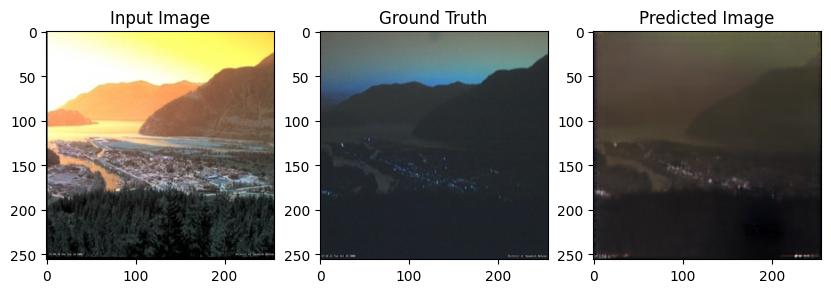

Models saved : gmodel_9000 , dmodel_9000


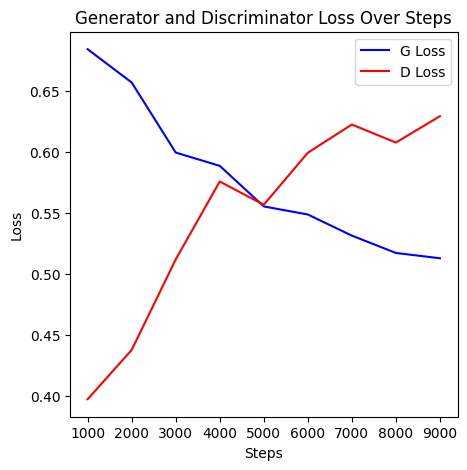

Step 9000/127560  Gen_loss: 0.619  Dis_loss: 0.128 Time: 20ms
Step 9001/127560  Gen_loss: 0.446  Dis_loss: 1.009 Time: 20ms
Step 9002/127560  Gen_loss: 0.688  Dis_loss: 0.354 Time: 20ms
Step 9003/127560  Gen_loss: 0.435  Dis_loss: 0.818 Time: 20ms
Step 9004/127560  Gen_loss: 0.63  Dis_loss: 0.331 Time: 20ms
Step 9005/127560  Gen_loss: 0.495  Dis_loss: 0.176 Time: 19ms
Step 9006/127560  Gen_loss: 0.168  Dis_loss: 0.818 Time: 18ms
Step 9007/127560  Gen_loss: 0.469  Dis_loss: 0.57 Time: 19ms
Step 9008/127560  Gen_loss: 0.453  Dis_loss: 0.307 Time: 19ms
Step 9009/127560  Gen_loss: 0.592  Dis_loss: 1.411 Time: 20ms
Step 9010/127560  Gen_loss: 0.842  Dis_loss: 0.367 Time: 20ms
Step 9011/127560  Gen_loss: 0.232  Dis_loss: 1.323 Time: 19ms
Step 9012/127560  Gen_loss: 0.427  Dis_loss: 1.67 Time: 19ms
Step 9013/127560  Gen_loss: 0.496  Dis_loss: 0.53 Time: 20ms
Step 9014/127560  Gen_loss: 1.092  Dis_loss: 0.527 Time: 19ms
Step 9015/127560  Gen_loss: 0.511  Dis_loss: 0.948 Time: 19ms
Step 9016/12

Step 9133/127560  Gen_loss: 0.56  Dis_loss: 0.342 Time: 20ms
Step 9134/127560  Gen_loss: 0.241  Dis_loss: 1.381 Time: 19ms
Step 9135/127560  Gen_loss: 0.161  Dis_loss: 0.844 Time: 19ms
Step 9136/127560  Gen_loss: 0.973  Dis_loss: 0.241 Time: 104ms
Step 9137/127560  Gen_loss: 0.658  Dis_loss: 0.228 Time: 21ms
Step 9138/127560  Gen_loss: 0.261  Dis_loss: 0.791 Time: 19ms
Step 9139/127560  Gen_loss: 0.467  Dis_loss: 0.789 Time: 22ms
Step 9140/127560  Gen_loss: 0.547  Dis_loss: 0.6 Time: 20ms
Step 9141/127560  Gen_loss: 0.488  Dis_loss: 0.238 Time: 19ms
Step 9142/127560  Gen_loss: 0.506  Dis_loss: 0.403 Time: 19ms
Step 9143/127560  Gen_loss: 0.83  Dis_loss: 0.926 Time: 19ms
Step 9144/127560  Gen_loss: 0.377  Dis_loss: 0.794 Time: 20ms
Step 9145/127560  Gen_loss: 0.422  Dis_loss: 0.37 Time: 22ms
Step 9146/127560  Gen_loss: 0.78  Dis_loss: 1.096 Time: 19ms
Step 9147/127560  Gen_loss: 0.511  Dis_loss: 1.197 Time: 21ms
Step 9148/127560  Gen_loss: 0.155  Dis_loss: 1.108 Time: 19ms
Step 9149/127

Step 9266/127560  Gen_loss: 0.501  Dis_loss: 0.033 Time: 18ms
Step 9267/127560  Gen_loss: 0.444  Dis_loss: 0.677 Time: 20ms
Step 9268/127560  Gen_loss: 0.71  Dis_loss: 1.102 Time: 20ms
Step 9269/127560  Gen_loss: 0.331  Dis_loss: 0.469 Time: 20ms
Step 9270/127560  Gen_loss: 0.803  Dis_loss: 0.128 Time: 20ms
Step 9271/127560  Gen_loss: 0.717  Dis_loss: 0.195 Time: 19ms
Step 9272/127560  Gen_loss: 0.47  Dis_loss: 0.133 Time: 20ms
Step 9273/127560  Gen_loss: 0.316  Dis_loss: 0.423 Time: 21ms
Step 9274/127560  Gen_loss: 0.436  Dis_loss: 2.727 Time: 19ms
Step 9275/127560  Gen_loss: 0.162  Dis_loss: 1.903 Time: 20ms
Step 9276/127560  Gen_loss: 0.74  Dis_loss: 0.566 Time: 20ms
Step 9277/127560  Gen_loss: 0.662  Dis_loss: 0.295 Time: 20ms
Step 9278/127560  Gen_loss: 0.225  Dis_loss: 0.837 Time: 19ms
Step 9279/127560  Gen_loss: 0.686  Dis_loss: 0.112 Time: 19ms
Step 9280/127560  Gen_loss: 0.542  Dis_loss: 0.318 Time: 18ms
Step 9281/127560  Gen_loss: 0.466  Dis_loss: 0.086 Time: 19ms
Step 9282/1

Step 9399/127560  Gen_loss: 0.559  Dis_loss: 0.184 Time: 20ms
Step 9400/127560  Gen_loss: 0.881  Dis_loss: 0.243 Time: 20ms
Step 9401/127560  Gen_loss: 0.712  Dis_loss: 0.176 Time: 20ms
Step 9402/127560  Gen_loss: 0.823  Dis_loss: 0.051 Time: 19ms
Step 9403/127560  Gen_loss: 0.509  Dis_loss: 0.179 Time: 20ms
Step 9404/127560  Gen_loss: 0.533  Dis_loss: 1.014 Time: 21ms
Step 9405/127560  Gen_loss: 0.63  Dis_loss: 0.317 Time: 20ms
Step 9406/127560  Gen_loss: 0.433  Dis_loss: 1.032 Time: 20ms
Step 9407/127560  Gen_loss: 0.473  Dis_loss: 0.545 Time: 20ms
Step 9408/127560  Gen_loss: 0.554  Dis_loss: 1.004 Time: 19ms
Step 9409/127560  Gen_loss: 0.474  Dis_loss: 0.563 Time: 20ms
Step 9410/127560  Gen_loss: 0.409  Dis_loss: 1.077 Time: 21ms
Step 9411/127560  Gen_loss: 0.613  Dis_loss: 1.587 Time: 20ms
Step 9412/127560  Gen_loss: 0.592  Dis_loss: 0.38 Time: 21ms
Step 9413/127560  Gen_loss: 0.456  Dis_loss: 0.909 Time: 21ms
Step 9414/127560  Gen_loss: 0.543  Dis_loss: 0.044 Time: 20ms
Step 9415/

Step 9532/127560  Gen_loss: 0.705  Dis_loss: 0.449 Time: 19ms
Step 9533/127560  Gen_loss: 0.433  Dis_loss: 0.819 Time: 19ms
Step 9534/127560  Gen_loss: 0.232  Dis_loss: 0.458 Time: 20ms
Step 9535/127560  Gen_loss: 0.212  Dis_loss: 0.475 Time: 19ms
Step 9536/127560  Gen_loss: 0.549  Dis_loss: 0.554 Time: 19ms
Step 9537/127560  Gen_loss: 0.723  Dis_loss: 0.234 Time: 19ms
Step 9538/127560  Gen_loss: 0.472  Dis_loss: 0.155 Time: 19ms
Step 9539/127560  Gen_loss: 0.206  Dis_loss: 1.092 Time: 18ms
Step 9540/127560  Gen_loss: 0.709  Dis_loss: 0.509 Time: 18ms
Step 9541/127560  Gen_loss: 0.672  Dis_loss: 0.077 Time: 18ms
Step 9542/127560  Gen_loss: 0.157  Dis_loss: 1.246 Time: 19ms
Step 9543/127560  Gen_loss: 0.553  Dis_loss: 0.387 Time: 19ms
Step 9544/127560  Gen_loss: 0.308  Dis_loss: 0.458 Time: 19ms
Step 9545/127560  Gen_loss: 0.692  Dis_loss: 0.363 Time: 19ms
Step 9546/127560  Gen_loss: 0.877  Dis_loss: 0.236 Time: 19ms
Step 9547/127560  Gen_loss: 0.516  Dis_loss: 0.319 Time: 20ms
Step 954

Step 9665/127560  Gen_loss: 0.538  Dis_loss: 0.396 Time: 20ms
Step 9666/127560  Gen_loss: 0.433  Dis_loss: 1.082 Time: 19ms
Step 9667/127560  Gen_loss: 0.542  Dis_loss: 0.167 Time: 18ms
Step 9668/127560  Gen_loss: 0.502  Dis_loss: 0.589 Time: 20ms
Step 9669/127560  Gen_loss: 0.716  Dis_loss: 0.385 Time: 19ms
Step 9670/127560  Gen_loss: 0.373  Dis_loss: 0.639 Time: 19ms
Step 9671/127560  Gen_loss: 0.479  Dis_loss: 0.911 Time: 19ms
Step 9672/127560  Gen_loss: 0.36  Dis_loss: 0.917 Time: 19ms
Step 9673/127560  Gen_loss: 0.166  Dis_loss: 0.935 Time: 19ms
Step 9674/127560  Gen_loss: 0.512  Dis_loss: 0.713 Time: 20ms
Step 9675/127560  Gen_loss: 0.543  Dis_loss: 0.258 Time: 20ms
Step 9676/127560  Gen_loss: 0.503  Dis_loss: 0.996 Time: 20ms
Step 9677/127560  Gen_loss: 0.216  Dis_loss: 0.255 Time: 20ms
Step 9678/127560  Gen_loss: 0.384  Dis_loss: 0.242 Time: 20ms
Step 9679/127560  Gen_loss: 0.437  Dis_loss: 0.577 Time: 19ms
Step 9680/127560  Gen_loss: 0.61  Dis_loss: 0.348 Time: 19ms
Step 9681/

Step 9798/127560  Gen_loss: 0.543  Dis_loss: 0.196 Time: 20ms
Step 9799/127560  Gen_loss: 0.4  Dis_loss: 0.441 Time: 19ms
Step 9800/127560  Gen_loss: 0.769  Dis_loss: 0.092 Time: 20ms
Step 9801/127560  Gen_loss: 0.252  Dis_loss: 1.279 Time: 19ms
Step 9802/127560  Gen_loss: 0.224  Dis_loss: 0.732 Time: 19ms
Step 9803/127560  Gen_loss: 0.535  Dis_loss: 0.582 Time: 20ms
Step 9804/127560  Gen_loss: 0.8  Dis_loss: 1.037 Time: 19ms
Step 9805/127560  Gen_loss: 0.601  Dis_loss: 0.448 Time: 20ms
Step 9806/127560  Gen_loss: 0.198  Dis_loss: 0.508 Time: 19ms
Step 9807/127560  Gen_loss: 0.498  Dis_loss: 0.067 Time: 19ms
Step 9808/127560  Gen_loss: 0.255  Dis_loss: 0.999 Time: 20ms
Step 9809/127560  Gen_loss: 0.789  Dis_loss: 0.55 Time: 19ms
Step 9810/127560  Gen_loss: 0.465  Dis_loss: 1.021 Time: 20ms
Step 9811/127560  Gen_loss: 0.592  Dis_loss: 0.393 Time: 20ms
Step 9812/127560  Gen_loss: 0.364  Dis_loss: 1.738 Time: 19ms
Step 9813/127560  Gen_loss: 0.75  Dis_loss: 0.319 Time: 19ms
Step 9814/1275

Step 9931/127560  Gen_loss: 1.0  Dis_loss: 0.307 Time: 20ms
Step 9932/127560  Gen_loss: 0.495  Dis_loss: 0.981 Time: 19ms
Step 9933/127560  Gen_loss: 0.649  Dis_loss: 0.415 Time: 19ms
Step 9934/127560  Gen_loss: 0.585  Dis_loss: 0.911 Time: 20ms
Step 9935/127560  Gen_loss: 0.466  Dis_loss: 0.594 Time: 20ms
Step 9936/127560  Gen_loss: 0.445  Dis_loss: 1.619 Time: 19ms
Step 9937/127560  Gen_loss: 0.529  Dis_loss: 0.35 Time: 19ms
Step 9938/127560  Gen_loss: 0.677  Dis_loss: 0.69 Time: 18ms
Step 9939/127560  Gen_loss: 0.324  Dis_loss: 0.805 Time: 20ms
Step 9940/127560  Gen_loss: 0.46  Dis_loss: 0.096 Time: 19ms
Step 9941/127560  Gen_loss: 0.304  Dis_loss: 0.736 Time: 19ms
Step 9942/127560  Gen_loss: 0.528  Dis_loss: 2.066 Time: 19ms
Step 9943/127560  Gen_loss: 0.569  Dis_loss: 0.208 Time: 19ms
Step 9944/127560  Gen_loss: 0.448  Dis_loss: 0.415 Time: 20ms
Step 9945/127560  Gen_loss: 0.554  Dis_loss: 0.043 Time: 19ms
Step 9946/127560  Gen_loss: 1.015  Dis_loss: 4.373 Time: 19ms
Step 9947/127

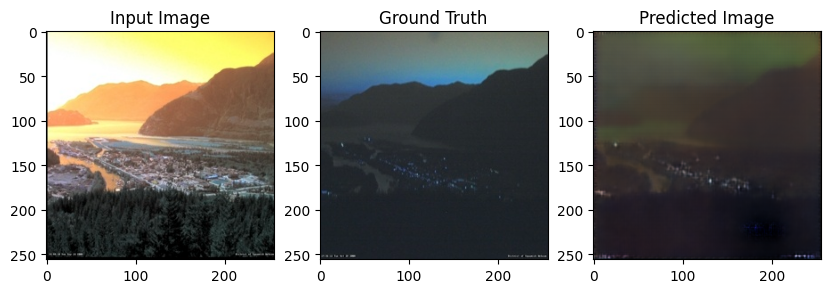

Models saved : gmodel_10000 , dmodel_10000


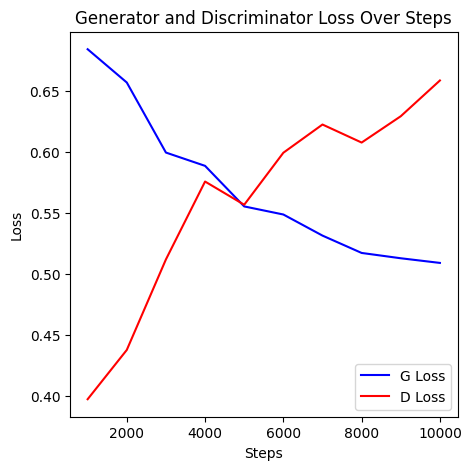

Step 10000/127560  Gen_loss: 0.427  Dis_loss: 1.496 Time: 19ms
Step 10001/127560  Gen_loss: 0.203  Dis_loss: 0.253 Time: 21ms
Step 10002/127560  Gen_loss: 0.8  Dis_loss: 1.536 Time: 19ms
Step 10003/127560  Gen_loss: 0.528  Dis_loss: 0.763 Time: 19ms
Step 10004/127560  Gen_loss: 0.42  Dis_loss: 0.812 Time: 19ms
Step 10005/127560  Gen_loss: 0.439  Dis_loss: 0.557 Time: 20ms
Step 10006/127560  Gen_loss: 0.738  Dis_loss: 0.072 Time: 19ms
Step 10007/127560  Gen_loss: 0.524  Dis_loss: 0.592 Time: 20ms
Step 10008/127560  Gen_loss: 0.523  Dis_loss: 0.107 Time: 19ms
Step 10009/127560  Gen_loss: 0.706  Dis_loss: 0.885 Time: 19ms
Step 10010/127560  Gen_loss: 0.179  Dis_loss: 1.673 Time: 19ms
Step 10011/127560  Gen_loss: 1.013  Dis_loss: 1.398 Time: 18ms
Step 10012/127560  Gen_loss: 0.77  Dis_loss: 2.165 Time: 19ms
Step 10013/127560  Gen_loss: 0.272  Dis_loss: 1.727 Time: 20ms
Step 10014/127560  Gen_loss: 0.207  Dis_loss: 1.815 Time: 20ms
Step 10015/127560  Gen_loss: 0.75  Dis_loss: 0.155 Time: 19

Step 10131/127560  Gen_loss: 0.546  Dis_loss: 0.481 Time: 19ms
Step 10132/127560  Gen_loss: 0.553  Dis_loss: 0.468 Time: 19ms
Step 10133/127560  Gen_loss: 0.759  Dis_loss: 0.085 Time: 19ms
Step 10134/127560  Gen_loss: 0.337  Dis_loss: 0.173 Time: 19ms
Step 10135/127560  Gen_loss: 0.186  Dis_loss: 3.061 Time: 19ms
Step 10136/127560  Gen_loss: 0.254  Dis_loss: 1.41 Time: 19ms
Step 10137/127560  Gen_loss: 0.623  Dis_loss: 0.145 Time: 19ms
Step 10138/127560  Gen_loss: 0.422  Dis_loss: 0.438 Time: 19ms
Step 10139/127560  Gen_loss: 0.39  Dis_loss: 0.358 Time: 19ms
Step 10140/127560  Gen_loss: 0.39  Dis_loss: 0.889 Time: 19ms
Step 10141/127560  Gen_loss: 0.215  Dis_loss: 0.578 Time: 19ms
Step 10142/127560  Gen_loss: 0.618  Dis_loss: 0.11 Time: 19ms
Step 10143/127560  Gen_loss: 0.524  Dis_loss: 0.405 Time: 19ms
Step 10144/127560  Gen_loss: 0.64  Dis_loss: 0.318 Time: 18ms
Step 10145/127560  Gen_loss: 0.236  Dis_loss: 1.792 Time: 19ms
Step 10146/127560  Gen_loss: 0.208  Dis_loss: 2.215 Time: 19

Step 10262/127560  Gen_loss: 0.299  Dis_loss: 0.307 Time: 20ms
Step 10263/127560  Gen_loss: 0.45  Dis_loss: 0.914 Time: 19ms
Step 10264/127560  Gen_loss: 0.383  Dis_loss: 0.455 Time: 19ms
Step 10265/127560  Gen_loss: 0.738  Dis_loss: 0.19 Time: 19ms
Step 10266/127560  Gen_loss: 0.617  Dis_loss: 0.163 Time: 19ms
Step 10267/127560  Gen_loss: 0.737  Dis_loss: 0.019 Time: 19ms
Step 10268/127560  Gen_loss: 0.477  Dis_loss: 0.106 Time: 19ms
Step 10269/127560  Gen_loss: 0.44  Dis_loss: 0.153 Time: 20ms
Step 10270/127560  Gen_loss: 0.178  Dis_loss: 2.075 Time: 20ms
Step 10271/127560  Gen_loss: 0.65  Dis_loss: 0.038 Time: 19ms
Step 10272/127560  Gen_loss: 0.319  Dis_loss: 0.122 Time: 20ms
Step 10273/127560  Gen_loss: 0.437  Dis_loss: 2.095 Time: 19ms
Step 10274/127560  Gen_loss: 0.237  Dis_loss: 1.986 Time: 32ms
Step 10275/127560  Gen_loss: 0.606  Dis_loss: 0.193 Time: 20ms
Step 10276/127560  Gen_loss: 0.647  Dis_loss: 2.199 Time: 20ms
Step 10277/127560  Gen_loss: 0.644  Dis_loss: 0.721 Time: 1

Step 10393/127560  Gen_loss: 0.465  Dis_loss: 0.275 Time: 20ms
Step 10394/127560  Gen_loss: 0.656  Dis_loss: 0.224 Time: 19ms
Step 10395/127560  Gen_loss: 0.416  Dis_loss: 0.457 Time: 19ms
Step 10396/127560  Gen_loss: 0.495  Dis_loss: 0.439 Time: 19ms
Step 10397/127560  Gen_loss: 0.428  Dis_loss: 0.38 Time: 20ms
Step 10398/127560  Gen_loss: 0.398  Dis_loss: 0.215 Time: 20ms
Step 10399/127560  Gen_loss: 0.765  Dis_loss: 0.113 Time: 21ms
Step 10400/127560  Gen_loss: 0.527  Dis_loss: 0.582 Time: 20ms
Step 10401/127560  Gen_loss: 0.743  Dis_loss: 0.178 Time: 20ms
Step 10402/127560  Gen_loss: 0.755  Dis_loss: 0.144 Time: 21ms
Step 10403/127560  Gen_loss: 0.421  Dis_loss: 0.356 Time: 21ms
Step 10404/127560  Gen_loss: 0.392  Dis_loss: 0.611 Time: 21ms
Step 10405/127560  Gen_loss: 0.475  Dis_loss: 0.11 Time: 21ms
Step 10406/127560  Gen_loss: 0.319  Dis_loss: 0.374 Time: 21ms
Step 10407/127560  Gen_loss: 0.273  Dis_loss: 0.059 Time: 22ms
Step 10408/127560  Gen_loss: 0.619  Dis_loss: 0.134 Time:

Step 10524/127560  Gen_loss: 0.551  Dis_loss: 0.619 Time: 19ms
Step 10525/127560  Gen_loss: 0.517  Dis_loss: 0.501 Time: 19ms
Step 10526/127560  Gen_loss: 0.597  Dis_loss: 0.967 Time: 20ms
Step 10527/127560  Gen_loss: 0.152  Dis_loss: 1.048 Time: 20ms
Step 10528/127560  Gen_loss: 0.242  Dis_loss: 0.57 Time: 19ms
Step 10529/127560  Gen_loss: 0.762  Dis_loss: 0.376 Time: 19ms
Step 10530/127560  Gen_loss: 0.255  Dis_loss: 0.08 Time: 19ms
Step 10531/127560  Gen_loss: 0.522  Dis_loss: 0.072 Time: 19ms
Step 10532/127560  Gen_loss: 0.362  Dis_loss: 0.525 Time: 19ms
Step 10533/127560  Gen_loss: 0.367  Dis_loss: 1.41 Time: 19ms
Step 10534/127560  Gen_loss: 0.47  Dis_loss: 0.062 Time: 19ms
Step 10535/127560  Gen_loss: 0.373  Dis_loss: 0.077 Time: 19ms
Step 10536/127560  Gen_loss: 0.506  Dis_loss: 1.57 Time: 20ms
Step 10537/127560  Gen_loss: 0.644  Dis_loss: 1.36 Time: 19ms
Step 10538/127560  Gen_loss: 0.395  Dis_loss: 0.394 Time: 20ms
Step 10539/127560  Gen_loss: 0.54  Dis_loss: 3.479 Time: 20ms

Step 10655/127560  Gen_loss: 0.561  Dis_loss: 1.868 Time: 19ms
Step 10656/127560  Gen_loss: 0.567  Dis_loss: 0.119 Time: 19ms
Step 10657/127560  Gen_loss: 0.281  Dis_loss: 1.805 Time: 19ms
Step 10658/127560  Gen_loss: 0.367  Dis_loss: 0.492 Time: 20ms
Step 10659/127560  Gen_loss: 0.533  Dis_loss: 0.264 Time: 19ms
Step 10660/127560  Gen_loss: 0.886  Dis_loss: 0.596 Time: 19ms
Step 10661/127560  Gen_loss: 0.555  Dis_loss: 0.216 Time: 20ms
Step 10662/127560  Gen_loss: 0.504  Dis_loss: 0.397 Time: 19ms
Step 10663/127560  Gen_loss: 0.42  Dis_loss: 0.154 Time: 19ms
Step 10664/127560  Gen_loss: 0.507  Dis_loss: 0.139 Time: 19ms
Step 10665/127560  Gen_loss: 0.539  Dis_loss: 0.141 Time: 19ms
Step 10666/127560  Gen_loss: 0.189  Dis_loss: 0.584 Time: 19ms
Step 10667/127560  Gen_loss: 0.565  Dis_loss: 0.213 Time: 20ms
Step 10668/127560  Gen_loss: 0.462  Dis_loss: 0.746 Time: 19ms
Step 10669/127560  Gen_loss: 0.381  Dis_loss: 0.934 Time: 20ms
Step 10670/127560  Gen_loss: 0.781  Dis_loss: 1.051 Time

Step 10786/127560  Gen_loss: 0.802  Dis_loss: 0.428 Time: 19ms
Step 10787/127560  Gen_loss: 0.418  Dis_loss: 1.131 Time: 19ms
Step 10788/127560  Gen_loss: 0.486  Dis_loss: 0.233 Time: 19ms
Step 10789/127560  Gen_loss: 0.416  Dis_loss: 0.698 Time: 20ms
Step 10790/127560  Gen_loss: 0.361  Dis_loss: 0.513 Time: 19ms
Step 10791/127560  Gen_loss: 0.543  Dis_loss: 0.661 Time: 19ms
Step 10792/127560  Gen_loss: 0.855  Dis_loss: 0.107 Time: 20ms
Step 10793/127560  Gen_loss: 0.655  Dis_loss: 0.676 Time: 19ms
Step 10794/127560  Gen_loss: 0.311  Dis_loss: 0.297 Time: 19ms
Step 10795/127560  Gen_loss: 0.364  Dis_loss: 0.415 Time: 20ms
Step 10796/127560  Gen_loss: 0.587  Dis_loss: 0.489 Time: 21ms
Step 10797/127560  Gen_loss: 0.523  Dis_loss: 0.756 Time: 20ms
Step 10798/127560  Gen_loss: 0.496  Dis_loss: 0.44 Time: 19ms
Step 10799/127560  Gen_loss: 0.795  Dis_loss: 0.153 Time: 20ms
Step 10800/127560  Gen_loss: 0.505  Dis_loss: 2.155 Time: 19ms
Step 10801/127560  Gen_loss: 0.574  Dis_loss: 0.128 Time

Step 10917/127560  Gen_loss: 0.392  Dis_loss: 0.199 Time: 19ms
Step 10918/127560  Gen_loss: 0.546  Dis_loss: 0.336 Time: 20ms
Step 10919/127560  Gen_loss: 0.464  Dis_loss: 0.04 Time: 20ms
Step 10920/127560  Gen_loss: 0.61  Dis_loss: 0.272 Time: 19ms
Step 10921/127560  Gen_loss: 0.501  Dis_loss: 0.699 Time: 19ms
Step 10922/127560  Gen_loss: 0.49  Dis_loss: 0.818 Time: 19ms
Step 10923/127560  Gen_loss: 0.303  Dis_loss: 0.385 Time: 19ms
Step 10924/127560  Gen_loss: 0.577  Dis_loss: 0.385 Time: 19ms
Step 10925/127560  Gen_loss: 0.384  Dis_loss: 0.165 Time: 19ms
Step 10926/127560  Gen_loss: 0.448  Dis_loss: 0.04 Time: 19ms
Step 10927/127560  Gen_loss: 0.485  Dis_loss: 0.117 Time: 20ms
Step 10928/127560  Gen_loss: 0.35  Dis_loss: 0.232 Time: 19ms
Step 10929/127560  Gen_loss: 0.643  Dis_loss: 1.079 Time: 20ms
Step 10930/127560  Gen_loss: 0.763  Dis_loss: 0.249 Time: 19ms
Step 10931/127560  Gen_loss: 0.314  Dis_loss: 0.567 Time: 20ms
Step 10932/127560  Gen_loss: 0.178  Dis_loss: 0.363 Time: 21

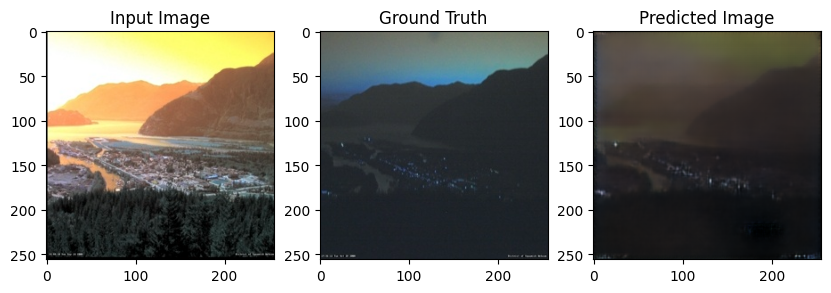

Models saved : gmodel_11000 , dmodel_11000


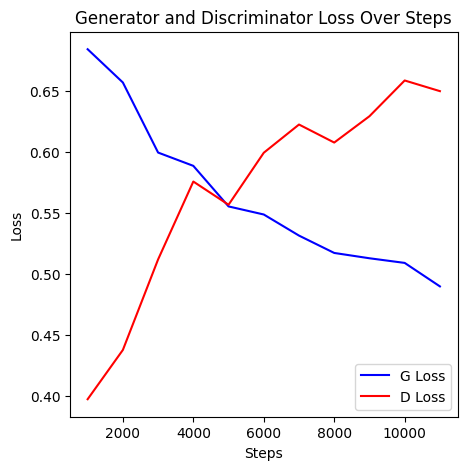

Step 11000/127560  Gen_loss: 0.712  Dis_loss: 2.051 Time: 19ms
Step 11001/127560  Gen_loss: 0.538  Dis_loss: 0.231 Time: 20ms
Step 11002/127560  Gen_loss: 0.507  Dis_loss: 0.43 Time: 20ms
Step 11003/127560  Gen_loss: 0.479  Dis_loss: 1.857 Time: 19ms
Step 11004/127560  Gen_loss: 0.449  Dis_loss: 0.305 Time: 20ms
Step 11005/127560  Gen_loss: 0.189  Dis_loss: 0.596 Time: 19ms
Step 11006/127560  Gen_loss: 0.432  Dis_loss: 0.24 Time: 20ms
Step 11007/127560  Gen_loss: 0.205  Dis_loss: 1.869 Time: 19ms
Step 11008/127560  Gen_loss: 0.51  Dis_loss: 0.565 Time: 19ms
Step 11009/127560  Gen_loss: 0.37  Dis_loss: 0.771 Time: 19ms
Step 11010/127560  Gen_loss: 0.371  Dis_loss: 0.356 Time: 20ms
Step 11011/127560  Gen_loss: 0.785  Dis_loss: 0.266 Time: 19ms
Step 11012/127560  Gen_loss: 0.551  Dis_loss: 0.162 Time: 19ms
Step 11013/127560  Gen_loss: 0.476  Dis_loss: 0.697 Time: 20ms
Step 11014/127560  Gen_loss: 0.387  Dis_loss: 0.785 Time: 20ms
Step 11015/127560  Gen_loss: 0.399  Dis_loss: 0.698 Time: 1

Step 11131/127560  Gen_loss: 0.241  Dis_loss: 0.801 Time: 20ms
Step 11132/127560  Gen_loss: 0.658  Dis_loss: 0.279 Time: 20ms
Step 11133/127560  Gen_loss: 0.19  Dis_loss: 0.534 Time: 19ms
Step 11134/127560  Gen_loss: 0.935  Dis_loss: 0.308 Time: 19ms
Step 11135/127560  Gen_loss: 0.527  Dis_loss: 0.196 Time: 20ms
Step 11136/127560  Gen_loss: 0.142  Dis_loss: 0.995 Time: 20ms
Step 11137/127560  Gen_loss: 0.555  Dis_loss: 0.404 Time: 19ms
Step 11138/127560  Gen_loss: 0.506  Dis_loss: 0.152 Time: 19ms
Step 11139/127560  Gen_loss: 0.373  Dis_loss: 3.389 Time: 19ms
Step 11140/127560  Gen_loss: 0.236  Dis_loss: 1.778 Time: 20ms
Step 11141/127560  Gen_loss: 0.314  Dis_loss: 0.263 Time: 19ms
Step 11142/127560  Gen_loss: 0.471  Dis_loss: 0.152 Time: 19ms
Step 11143/127560  Gen_loss: 0.417  Dis_loss: 1.051 Time: 20ms
Step 11144/127560  Gen_loss: 0.456  Dis_loss: 1.86 Time: 20ms
Step 11145/127560  Gen_loss: 0.145  Dis_loss: 1.035 Time: 19ms
Step 11146/127560  Gen_loss: 0.821  Dis_loss: 0.917 Time:

Step 11262/127560  Gen_loss: 0.245  Dis_loss: 0.794 Time: 20ms
Step 11263/127560  Gen_loss: 0.443  Dis_loss: 0.26 Time: 20ms
Step 11264/127560  Gen_loss: 0.54  Dis_loss: 1.204 Time: 19ms
Step 11265/127560  Gen_loss: 0.464  Dis_loss: 0.572 Time: 19ms
Step 11266/127560  Gen_loss: 0.302  Dis_loss: 0.944 Time: 20ms
Step 11267/127560  Gen_loss: 0.445  Dis_loss: 1.918 Time: 19ms
Step 11268/127560  Gen_loss: 0.649  Dis_loss: 0.205 Time: 20ms
Step 11269/127560  Gen_loss: 0.375  Dis_loss: 0.844 Time: 20ms
Step 11270/127560  Gen_loss: 0.352  Dis_loss: 2.495 Time: 19ms
Step 11271/127560  Gen_loss: 0.506  Dis_loss: 0.639 Time: 19ms
Step 11272/127560  Gen_loss: 0.458  Dis_loss: 0.782 Time: 19ms
Step 11273/127560  Gen_loss: 0.656  Dis_loss: 0.131 Time: 19ms
Step 11274/127560  Gen_loss: 1.041  Dis_loss: 0.974 Time: 20ms
Step 11275/127560  Gen_loss: 0.523  Dis_loss: 0.226 Time: 19ms
Step 11276/127560  Gen_loss: 0.242  Dis_loss: 0.618 Time: 22ms
Step 11277/127560  Gen_loss: 0.414  Dis_loss: 0.157 Time:

Step 11393/127560  Gen_loss: 0.664  Dis_loss: 0.255 Time: 18ms
Step 11394/127560  Gen_loss: 0.524  Dis_loss: 0.271 Time: 19ms
Step 11395/127560  Gen_loss: 0.876  Dis_loss: 0.117 Time: 19ms
Step 11396/127560  Gen_loss: 0.576  Dis_loss: 0.703 Time: 19ms
Step 11397/127560  Gen_loss: 0.397  Dis_loss: 0.169 Time: 19ms
Step 11398/127560  Gen_loss: 0.789  Dis_loss: 1.26 Time: 19ms
Step 11399/127560  Gen_loss: 0.411  Dis_loss: 1.455 Time: 19ms
Step 11400/127560  Gen_loss: 0.522  Dis_loss: 0.364 Time: 19ms
Step 11401/127560  Gen_loss: 0.629  Dis_loss: 0.515 Time: 19ms
Step 11402/127560  Gen_loss: 0.521  Dis_loss: 0.407 Time: 20ms
Step 11403/127560  Gen_loss: 0.71  Dis_loss: 0.317 Time: 19ms
Step 11404/127560  Gen_loss: 0.507  Dis_loss: 0.22 Time: 20ms
Step 11405/127560  Gen_loss: 0.471  Dis_loss: 1.154 Time: 19ms
Step 11406/127560  Gen_loss: 0.942  Dis_loss: 0.012 Time: 20ms
Step 11407/127560  Gen_loss: 0.308  Dis_loss: 0.248 Time: 19ms
Step 11408/127560  Gen_loss: 0.371  Dis_loss: 0.306 Time: 

Step 11524/127560  Gen_loss: 0.475  Dis_loss: 0.312 Time: 19ms
Step 11525/127560  Gen_loss: 0.756  Dis_loss: 0.433 Time: 20ms
Step 11526/127560  Gen_loss: 0.543  Dis_loss: 0.31 Time: 20ms
Step 11527/127560  Gen_loss: 0.239  Dis_loss: 0.83 Time: 19ms
Step 11528/127560  Gen_loss: 0.551  Dis_loss: 0.375 Time: 20ms
Step 11529/127560  Gen_loss: 0.843  Dis_loss: 0.429 Time: 19ms
Step 11530/127560  Gen_loss: 0.555  Dis_loss: 0.182 Time: 19ms
Step 11531/127560  Gen_loss: 0.289  Dis_loss: 0.587 Time: 20ms
Step 11532/127560  Gen_loss: 0.372  Dis_loss: 0.162 Time: 20ms
Step 11533/127560  Gen_loss: 0.242  Dis_loss: 1.919 Time: 19ms
Step 11534/127560  Gen_loss: 0.372  Dis_loss: 0.43 Time: 19ms
Step 11535/127560  Gen_loss: 0.398  Dis_loss: 1.185 Time: 19ms
Step 11536/127560  Gen_loss: 0.477  Dis_loss: 0.761 Time: 19ms
Step 11537/127560  Gen_loss: 0.366  Dis_loss: 0.043 Time: 20ms
Step 11538/127560  Gen_loss: 0.596  Dis_loss: 0.567 Time: 20ms
Step 11539/127560  Gen_loss: 0.667  Dis_loss: 0.128 Time: 

Step 11655/127560  Gen_loss: 0.508  Dis_loss: 0.407 Time: 20ms
Step 11656/127560  Gen_loss: 0.333  Dis_loss: 0.327 Time: 19ms
Step 11657/127560  Gen_loss: 0.153  Dis_loss: 1.864 Time: 19ms
Step 11658/127560  Gen_loss: 0.572  Dis_loss: 0.339 Time: 20ms
Step 11659/127560  Gen_loss: 0.372  Dis_loss: 0.61 Time: 20ms
Step 11660/127560  Gen_loss: 0.252  Dis_loss: 0.067 Time: 19ms
Step 11661/127560  Gen_loss: 0.502  Dis_loss: 1.083 Time: 20ms
Step 11662/127560  Gen_loss: 0.521  Dis_loss: 0.179 Time: 20ms
Step 11663/127560  Gen_loss: 0.381  Dis_loss: 0.494 Time: 19ms
Step 11664/127560  Gen_loss: 0.498  Dis_loss: 0.516 Time: 19ms
Step 11665/127560  Gen_loss: 0.512  Dis_loss: 0.176 Time: 19ms
Step 11666/127560  Gen_loss: 0.655  Dis_loss: 0.301 Time: 20ms
Step 11667/127560  Gen_loss: 0.38  Dis_loss: 0.321 Time: 20ms
Step 11668/127560  Gen_loss: 0.51  Dis_loss: 0.085 Time: 19ms
Step 11669/127560  Gen_loss: 0.358  Dis_loss: 0.547 Time: 20ms
Step 11670/127560  Gen_loss: 0.185  Dis_loss: 0.913 Time: 

Step 11786/127560  Gen_loss: 0.51  Dis_loss: 0.964 Time: 19ms
Step 11787/127560  Gen_loss: 0.4  Dis_loss: 0.459 Time: 19ms
Step 11788/127560  Gen_loss: 0.394  Dis_loss: 0.801 Time: 19ms
Step 11789/127560  Gen_loss: 0.564  Dis_loss: 0.516 Time: 20ms
Step 11790/127560  Gen_loss: 0.461  Dis_loss: 0.813 Time: 19ms
Step 11791/127560  Gen_loss: 0.2  Dis_loss: 0.771 Time: 19ms
Step 11792/127560  Gen_loss: 0.592  Dis_loss: 0.515 Time: 19ms
Step 11793/127560  Gen_loss: 0.158  Dis_loss: 0.37 Time: 20ms
Step 11794/127560  Gen_loss: 0.735  Dis_loss: 0.174 Time: 19ms
Step 11795/127560  Gen_loss: 0.67  Dis_loss: 0.468 Time: 19ms
Step 11796/127560  Gen_loss: 0.27  Dis_loss: 1.243 Time: 19ms
Step 11797/127560  Gen_loss: 0.505  Dis_loss: 0.561 Time: 20ms
Step 11798/127560  Gen_loss: 0.252  Dis_loss: 0.603 Time: 20ms
Step 11799/127560  Gen_loss: 0.178  Dis_loss: 0.582 Time: 19ms
Step 11800/127560  Gen_loss: 0.755  Dis_loss: 0.639 Time: 19ms
Step 11801/127560  Gen_loss: 0.484  Dis_loss: 0.475 Time: 19ms


Step 11917/127560  Gen_loss: 0.272  Dis_loss: 1.846 Time: 19ms
Step 11918/127560  Gen_loss: 0.331  Dis_loss: 0.682 Time: 20ms
Step 11919/127560  Gen_loss: 0.501  Dis_loss: 0.675 Time: 19ms
Step 11920/127560  Gen_loss: 0.245  Dis_loss: 0.76 Time: 19ms
Step 11921/127560  Gen_loss: 0.465  Dis_loss: 0.087 Time: 19ms
Step 11922/127560  Gen_loss: 0.524  Dis_loss: 0.124 Time: 19ms
Step 11923/127560  Gen_loss: 0.232  Dis_loss: 1.226 Time: 19ms
Step 11924/127560  Gen_loss: 0.386  Dis_loss: 0.15 Time: 20ms
Step 11925/127560  Gen_loss: 0.49  Dis_loss: 0.558 Time: 20ms
Step 11926/127560  Gen_loss: 0.769  Dis_loss: 0.194 Time: 19ms
Step 11927/127560  Gen_loss: 0.364  Dis_loss: 0.071 Time: 19ms
Step 11928/127560  Gen_loss: 0.412  Dis_loss: 0.606 Time: 19ms
Step 11929/127560  Gen_loss: 0.354  Dis_loss: 0.126 Time: 19ms
Step 11930/127560  Gen_loss: 0.875  Dis_loss: 0.272 Time: 19ms
Step 11931/127560  Gen_loss: 0.36  Dis_loss: 0.503 Time: 19ms
Step 11932/127560  Gen_loss: 0.529  Dis_loss: 1.27 Time: 19

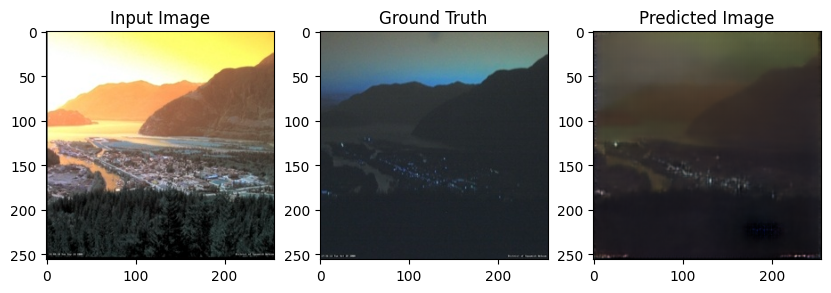

Models saved : gmodel_12000 , dmodel_12000


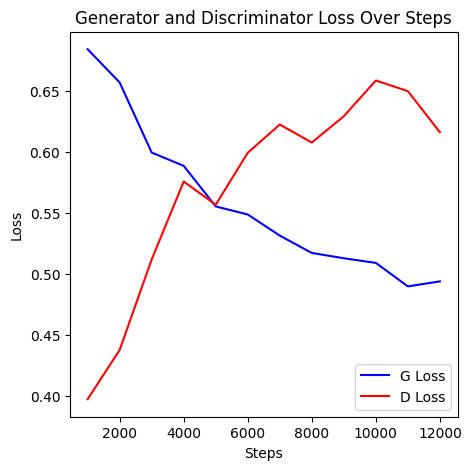

Step 12000/127560  Gen_loss: 0.593  Dis_loss: 0.024 Time: 19ms
Step 12001/127560  Gen_loss: 0.157  Dis_loss: 0.959 Time: 20ms
Step 12002/127560  Gen_loss: 0.586  Dis_loss: 0.179 Time: 20ms
Step 12003/127560  Gen_loss: 0.498  Dis_loss: 0.431 Time: 20ms
Step 12004/127560  Gen_loss: 0.437  Dis_loss: 0.659 Time: 19ms
Step 12005/127560  Gen_loss: 0.812  Dis_loss: 0.251 Time: 19ms
Step 12006/127560  Gen_loss: 0.761  Dis_loss: 0.157 Time: 19ms
Step 12007/127560  Gen_loss: 0.238  Dis_loss: 0.826 Time: 19ms
Step 12008/127560  Gen_loss: 0.369  Dis_loss: 0.67 Time: 20ms
Step 12009/127560  Gen_loss: 0.723  Dis_loss: 0.144 Time: 19ms
Step 12010/127560  Gen_loss: 0.345  Dis_loss: 0.16 Time: 19ms
Step 12011/127560  Gen_loss: 0.355  Dis_loss: 0.364 Time: 19ms
Step 12012/127560  Gen_loss: 0.219  Dis_loss: 0.66 Time: 19ms
Step 12013/127560  Gen_loss: 0.615  Dis_loss: 0.329 Time: 19ms
Step 12014/127560  Gen_loss: 0.516  Dis_loss: 0.223 Time: 20ms
Step 12015/127560  Gen_loss: 0.2  Dis_loss: 0.948 Time: 19

Step 12131/127560  Gen_loss: 0.347  Dis_loss: 0.698 Time: 19ms
Step 12132/127560  Gen_loss: 0.502  Dis_loss: 0.54 Time: 20ms
Step 12133/127560  Gen_loss: 0.614  Dis_loss: 0.081 Time: 19ms
Step 12134/127560  Gen_loss: 0.516  Dis_loss: 0.789 Time: 19ms
Step 12135/127560  Gen_loss: 0.452  Dis_loss: 1.005 Time: 19ms
Step 12136/127560  Gen_loss: 0.442  Dis_loss: 0.145 Time: 20ms
Step 12137/127560  Gen_loss: 0.727  Dis_loss: 0.251 Time: 19ms
Step 12138/127560  Gen_loss: 0.463  Dis_loss: 0.249 Time: 20ms
Step 12139/127560  Gen_loss: 0.406  Dis_loss: 0.116 Time: 20ms
Step 12140/127560  Gen_loss: 0.425  Dis_loss: 1.15 Time: 20ms
Step 12141/127560  Gen_loss: 0.501  Dis_loss: 1.195 Time: 19ms
Step 12142/127560  Gen_loss: 0.544  Dis_loss: 0.669 Time: 20ms
Step 12143/127560  Gen_loss: 0.235  Dis_loss: 1.077 Time: 19ms
Step 12144/127560  Gen_loss: 0.454  Dis_loss: 0.123 Time: 20ms
Step 12145/127560  Gen_loss: 0.218  Dis_loss: 0.704 Time: 20ms
Step 12146/127560  Gen_loss: 0.57  Dis_loss: 0.735 Time: 

Step 12262/127560  Gen_loss: 0.274  Dis_loss: 1.055 Time: 20ms
Step 12263/127560  Gen_loss: 0.461  Dis_loss: 0.43 Time: 19ms
Step 12264/127560  Gen_loss: 0.512  Dis_loss: 0.029 Time: 19ms
Step 12265/127560  Gen_loss: 0.517  Dis_loss: 0.204 Time: 20ms
Step 12266/127560  Gen_loss: 0.567  Dis_loss: 0.246 Time: 20ms
Step 12267/127560  Gen_loss: 0.301  Dis_loss: 0.216 Time: 19ms
Step 12268/127560  Gen_loss: 1.052  Dis_loss: 1.282 Time: 19ms
Step 12269/127560  Gen_loss: 0.447  Dis_loss: 1.218 Time: 19ms
Step 12270/127560  Gen_loss: 0.746  Dis_loss: 3.472 Time: 20ms
Step 12271/127560  Gen_loss: 0.386  Dis_loss: 0.372 Time: 20ms
Step 12272/127560  Gen_loss: 0.802  Dis_loss: 0.078 Time: 19ms
Step 12273/127560  Gen_loss: 0.418  Dis_loss: 0.574 Time: 19ms
Step 12274/127560  Gen_loss: 0.626  Dis_loss: 0.189 Time: 19ms
Step 12275/127560  Gen_loss: 0.728  Dis_loss: 2.004 Time: 19ms
Step 12276/127560  Gen_loss: 0.302  Dis_loss: 0.732 Time: 19ms
Step 12277/127560  Gen_loss: 0.486  Dis_loss: 0.344 Time

Step 12393/127560  Gen_loss: 0.397  Dis_loss: 0.648 Time: 20ms
Step 12394/127560  Gen_loss: 0.656  Dis_loss: 0.263 Time: 19ms
Step 12395/127560  Gen_loss: 0.164  Dis_loss: 1.054 Time: 19ms
Step 12396/127560  Gen_loss: 0.516  Dis_loss: 0.176 Time: 19ms
Step 12397/127560  Gen_loss: 0.424  Dis_loss: 0.382 Time: 21ms
Step 12398/127560  Gen_loss: 0.27  Dis_loss: 2.512 Time: 19ms
Step 12399/127560  Gen_loss: 0.514  Dis_loss: 1.342 Time: 20ms
Step 12400/127560  Gen_loss: 0.382  Dis_loss: 0.581 Time: 19ms
Step 12401/127560  Gen_loss: 0.457  Dis_loss: 1.733 Time: 19ms
Step 12402/127560  Gen_loss: 0.442  Dis_loss: 0.093 Time: 20ms
Step 12403/127560  Gen_loss: 0.443  Dis_loss: 0.035 Time: 19ms
Step 12404/127560  Gen_loss: 0.487  Dis_loss: 0.642 Time: 20ms
Step 12405/127560  Gen_loss: 0.242  Dis_loss: 0.522 Time: 19ms
Step 12406/127560  Gen_loss: 0.784  Dis_loss: 0.042 Time: 21ms
Step 12407/127560  Gen_loss: 0.516  Dis_loss: 0.032 Time: 20ms
Step 12408/127560  Gen_loss: 0.428  Dis_loss: 0.203 Time

Step 12524/127560  Gen_loss: 0.606  Dis_loss: 0.102 Time: 20ms
Step 12525/127560  Gen_loss: 0.624  Dis_loss: 1.179 Time: 19ms
Step 12526/127560  Gen_loss: 0.324  Dis_loss: 0.478 Time: 19ms
Step 12527/127560  Gen_loss: 0.67  Dis_loss: 0.038 Time: 20ms
Step 12528/127560  Gen_loss: 0.515  Dis_loss: 0.018 Time: 20ms
Step 12529/127560  Gen_loss: 0.355  Dis_loss: 0.376 Time: 19ms
Step 12530/127560  Gen_loss: 0.737  Dis_loss: 0.081 Time: 19ms
Step 12531/127560  Gen_loss: 0.71  Dis_loss: 0.329 Time: 20ms
Step 12532/127560  Gen_loss: 0.485  Dis_loss: 0.581 Time: 20ms
Step 12533/127560  Gen_loss: 0.445  Dis_loss: 0.692 Time: 19ms
Step 12534/127560  Gen_loss: 0.392  Dis_loss: 0.448 Time: 19ms
Step 12535/127560  Gen_loss: 0.575  Dis_loss: 0.183 Time: 20ms
Step 12536/127560  Gen_loss: 0.239  Dis_loss: 1.557 Time: 19ms
Step 12537/127560  Gen_loss: 0.169  Dis_loss: 0.904 Time: 19ms
Step 12538/127560  Gen_loss: 0.23  Dis_loss: 6.199 Time: 19ms
Step 12539/127560  Gen_loss: 0.154  Dis_loss: 0.521 Time: 

Step 12655/127560  Gen_loss: 0.423  Dis_loss: 1.114 Time: 19ms
Step 12656/127560  Gen_loss: 0.541  Dis_loss: 0.596 Time: 19ms
Step 12657/127560  Gen_loss: 0.488  Dis_loss: 0.192 Time: 19ms
Step 12658/127560  Gen_loss: 0.538  Dis_loss: 0.203 Time: 19ms
Step 12659/127560  Gen_loss: 0.441  Dis_loss: 0.493 Time: 18ms
Step 12660/127560  Gen_loss: 0.683  Dis_loss: 0.182 Time: 20ms
Step 12661/127560  Gen_loss: 0.165  Dis_loss: 1.311 Time: 20ms
Step 12662/127560  Gen_loss: 0.126  Dis_loss: 0.304 Time: 20ms
Step 12663/127560  Gen_loss: 0.238  Dis_loss: 0.463 Time: 20ms
Step 12664/127560  Gen_loss: 0.634  Dis_loss: 0.754 Time: 20ms
Step 12665/127560  Gen_loss: 0.392  Dis_loss: 0.389 Time: 19ms
Step 12666/127560  Gen_loss: 0.466  Dis_loss: 0.193 Time: 20ms
Step 12667/127560  Gen_loss: 0.219  Dis_loss: 0.479 Time: 20ms
Step 12668/127560  Gen_loss: 0.327  Dis_loss: 0.356 Time: 20ms
Step 12669/127560  Gen_loss: 0.455  Dis_loss: 0.027 Time: 21ms
Step 12670/127560  Gen_loss: 0.186  Dis_loss: 0.206 Tim

Step 12786/127560  Gen_loss: 0.4  Dis_loss: 1.368 Time: 20ms
Step 12787/127560  Gen_loss: 0.447  Dis_loss: 1.051 Time: 20ms
Step 12788/127560  Gen_loss: 0.785  Dis_loss: 0.652 Time: 19ms
Step 12789/127560  Gen_loss: 0.505  Dis_loss: 0.254 Time: 19ms
Step 12790/127560  Gen_loss: 0.441  Dis_loss: 0.354 Time: 19ms
Step 12791/127560  Gen_loss: 0.564  Dis_loss: 0.414 Time: 20ms
Step 12792/127560  Gen_loss: 0.304  Dis_loss: 0.22 Time: 19ms
Step 12793/127560  Gen_loss: 0.422  Dis_loss: 0.349 Time: 20ms
Step 12794/127560  Gen_loss: 0.486  Dis_loss: 0.608 Time: 20ms
Step 12795/127560  Gen_loss: 0.466  Dis_loss: 0.856 Time: 19ms
Step 12796/127560  Gen_loss: 0.147  Dis_loss: 0.8 Time: 20ms
Step 12797/127560  Gen_loss: 0.389  Dis_loss: 0.52 Time: 19ms
Step 12798/127560  Gen_loss: 0.145  Dis_loss: 1.621 Time: 19ms
Step 12799/127560  Gen_loss: 0.364  Dis_loss: 0.873 Time: 20ms
Step 12800/127560  Gen_loss: 0.518  Dis_loss: 1.156 Time: 20ms
Step 12801/127560  Gen_loss: 0.487  Dis_loss: 0.11 Time: 19ms

Step 12917/127560  Gen_loss: 0.431  Dis_loss: 0.548 Time: 19ms
Step 12918/127560  Gen_loss: 0.309  Dis_loss: 0.849 Time: 19ms
Step 12919/127560  Gen_loss: 0.758  Dis_loss: 0.241 Time: 19ms
Step 12920/127560  Gen_loss: 0.454  Dis_loss: 0.279 Time: 20ms
Step 12921/127560  Gen_loss: 0.792  Dis_loss: 1.214 Time: 20ms
Step 12922/127560  Gen_loss: 0.808  Dis_loss: 0.141 Time: 19ms
Step 12923/127560  Gen_loss: 0.538  Dis_loss: 0.044 Time: 19ms
Step 12924/127560  Gen_loss: 0.477  Dis_loss: 0.02 Time: 19ms
Step 12925/127560  Gen_loss: 0.447  Dis_loss: 1.526 Time: 19ms
Step 12926/127560  Gen_loss: 0.817  Dis_loss: 0.15 Time: 20ms
Step 12927/127560  Gen_loss: 0.835  Dis_loss: 0.014 Time: 20ms
Step 12928/127560  Gen_loss: 0.534  Dis_loss: 0.42 Time: 19ms
Step 12929/127560  Gen_loss: 0.504  Dis_loss: 0.918 Time: 19ms
Step 12930/127560  Gen_loss: 0.465  Dis_loss: 0.44 Time: 19ms
Step 12931/127560  Gen_loss: 0.546  Dis_loss: 0.129 Time: 19ms
Step 12932/127560  Gen_loss: 0.257  Dis_loss: 1.632 Time: 2

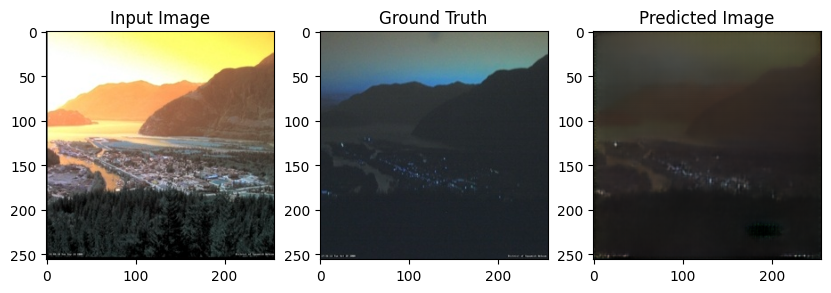

Models saved : gmodel_13000 , dmodel_13000


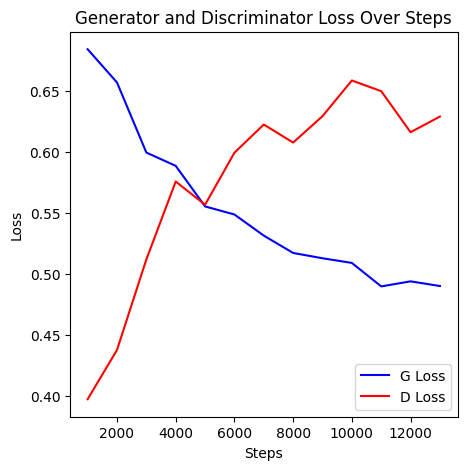

Step 13000/127560  Gen_loss: 0.342  Dis_loss: 0.352 Time: 20ms
Step 13001/127560  Gen_loss: 0.608  Dis_loss: 1.225 Time: 21ms
Step 13002/127560  Gen_loss: 0.372  Dis_loss: 0.307 Time: 20ms
Step 13003/127560  Gen_loss: 0.47  Dis_loss: 0.969 Time: 19ms
Step 13004/127560  Gen_loss: 0.482  Dis_loss: 1.111 Time: 19ms
Step 13005/127560  Gen_loss: 0.463  Dis_loss: 0.747 Time: 20ms
Step 13006/127560  Gen_loss: 0.491  Dis_loss: 0.053 Time: 20ms
Step 13007/127560  Gen_loss: 0.317  Dis_loss: 0.268 Time: 20ms
Step 13008/127560  Gen_loss: 0.324  Dis_loss: 0.229 Time: 20ms
Step 13009/127560  Gen_loss: 0.589  Dis_loss: 0.422 Time: 20ms
Step 13010/127560  Gen_loss: 0.511  Dis_loss: 0.53 Time: 19ms
Step 13011/127560  Gen_loss: 0.192  Dis_loss: 0.223 Time: 23ms
Step 13012/127560  Gen_loss: 0.609  Dis_loss: 0.059 Time: 19ms
Step 13013/127560  Gen_loss: 0.547  Dis_loss: 0.509 Time: 20ms
Step 13014/127560  Gen_loss: 0.353  Dis_loss: 0.079 Time: 19ms
Step 13015/127560  Gen_loss: 0.463  Dis_loss: 1.03 Time: 

Step 13131/127560  Gen_loss: 0.443  Dis_loss: 1.065 Time: 19ms
Step 13132/127560  Gen_loss: 0.609  Dis_loss: 0.152 Time: 20ms
Step 13133/127560  Gen_loss: 0.358  Dis_loss: 0.884 Time: 20ms
Step 13134/127560  Gen_loss: 0.807  Dis_loss: 0.304 Time: 19ms
Step 13135/127560  Gen_loss: 0.137  Dis_loss: 0.952 Time: 19ms
Step 13136/127560  Gen_loss: 0.509  Dis_loss: 0.253 Time: 20ms
Step 13137/127560  Gen_loss: 0.38  Dis_loss: 1.273 Time: 19ms
Step 13138/127560  Gen_loss: 0.696  Dis_loss: 0.393 Time: 20ms
Step 13139/127560  Gen_loss: 0.532  Dis_loss: 0.321 Time: 20ms
Step 13140/127560  Gen_loss: 0.367  Dis_loss: 0.524 Time: 19ms
Step 13141/127560  Gen_loss: 0.475  Dis_loss: 0.014 Time: 20ms
Step 13142/127560  Gen_loss: 0.517  Dis_loss: 0.409 Time: 19ms
Step 13143/127560  Gen_loss: 0.491  Dis_loss: 0.248 Time: 19ms
Step 13144/127560  Gen_loss: 0.431  Dis_loss: 0.55 Time: 20ms
Step 13145/127560  Gen_loss: 0.432  Dis_loss: 0.691 Time: 19ms
Step 13146/127560  Gen_loss: 0.444  Dis_loss: 0.062 Time:

Step 13262/127560  Gen_loss: 0.369  Dis_loss: 1.204 Time: 20ms
Step 13263/127560  Gen_loss: 0.274  Dis_loss: 0.512 Time: 19ms
Step 13264/127560  Gen_loss: 0.564  Dis_loss: 0.522 Time: 19ms
Step 13265/127560  Gen_loss: 0.815  Dis_loss: 0.311 Time: 19ms
Step 13266/127560  Gen_loss: 0.52  Dis_loss: 0.478 Time: 20ms
Step 13267/127560  Gen_loss: 0.385  Dis_loss: 0.456 Time: 20ms
Step 13268/127560  Gen_loss: 0.713  Dis_loss: 0.267 Time: 20ms
Step 13269/127560  Gen_loss: 0.367  Dis_loss: 1.127 Time: 20ms
Step 13270/127560  Gen_loss: 0.33  Dis_loss: 0.289 Time: 20ms
Step 13271/127560  Gen_loss: 0.708  Dis_loss: 1.068 Time: 20ms
Step 13272/127560  Gen_loss: 0.349  Dis_loss: 1.043 Time: 19ms
Step 13273/127560  Gen_loss: 0.743  Dis_loss: 0.883 Time: 20ms
Step 13274/127560  Gen_loss: 0.743  Dis_loss: 0.322 Time: 19ms
Step 13275/127560  Gen_loss: 0.414  Dis_loss: 0.846 Time: 20ms
Step 13276/127560  Gen_loss: 0.445  Dis_loss: 1.341 Time: 19ms
Step 13277/127560  Gen_loss: 0.274  Dis_loss: 0.214 Time:

Step 13393/127560  Gen_loss: 0.295  Dis_loss: 0.299 Time: 19ms
Step 13394/127560  Gen_loss: 0.595  Dis_loss: 0.824 Time: 20ms
Step 13395/127560  Gen_loss: 0.688  Dis_loss: 0.268 Time: 19ms
Step 13396/127560  Gen_loss: 0.738  Dis_loss: 0.427 Time: 19ms
Step 13397/127560  Gen_loss: 0.492  Dis_loss: 0.041 Time: 19ms
Step 13398/127560  Gen_loss: 0.773  Dis_loss: 0.156 Time: 19ms
Step 13399/127560  Gen_loss: 0.342  Dis_loss: 0.234 Time: 19ms
Step 13400/127560  Gen_loss: 0.701  Dis_loss: 0.157 Time: 19ms
Step 13401/127560  Gen_loss: 0.311  Dis_loss: 0.172 Time: 20ms
Step 13402/127560  Gen_loss: 0.535  Dis_loss: 0.354 Time: 19ms
Step 13403/127560  Gen_loss: 0.615  Dis_loss: 0.155 Time: 20ms
Step 13404/127560  Gen_loss: 0.349  Dis_loss: 3.486 Time: 20ms
Step 13405/127560  Gen_loss: 0.654  Dis_loss: 0.1 Time: 19ms
Step 13406/127560  Gen_loss: 0.628  Dis_loss: 0.662 Time: 20ms
Step 13407/127560  Gen_loss: 0.393  Dis_loss: 0.981 Time: 19ms
Step 13408/127560  Gen_loss: 0.327  Dis_loss: 0.36 Time: 

Step 13524/127560  Gen_loss: 0.491  Dis_loss: 0.092 Time: 19ms
Step 13525/127560  Gen_loss: 0.406  Dis_loss: 0.251 Time: 19ms
Step 13526/127560  Gen_loss: 0.488  Dis_loss: 0.4 Time: 19ms
Step 13527/127560  Gen_loss: 0.847  Dis_loss: 0.042 Time: 19ms
Step 13528/127560  Gen_loss: 0.578  Dis_loss: 0.342 Time: 20ms
Step 13529/127560  Gen_loss: 0.207  Dis_loss: 2.132 Time: 20ms
Step 13530/127560  Gen_loss: 0.503  Dis_loss: 0.319 Time: 20ms
Step 13531/127560  Gen_loss: 0.469  Dis_loss: 0.431 Time: 19ms
Step 13532/127560  Gen_loss: 0.625  Dis_loss: 0.93 Time: 20ms
Step 13533/127560  Gen_loss: 0.477  Dis_loss: 0.489 Time: 19ms
Step 13534/127560  Gen_loss: 0.592  Dis_loss: 0.198 Time: 19ms
Step 13535/127560  Gen_loss: 0.547  Dis_loss: 0.456 Time: 20ms
Step 13536/127560  Gen_loss: 0.392  Dis_loss: 0.661 Time: 20ms
Step 13537/127560  Gen_loss: 0.595  Dis_loss: 0.214 Time: 20ms
Step 13538/127560  Gen_loss: 0.185  Dis_loss: 1.615 Time: 19ms
Step 13539/127560  Gen_loss: 0.399  Dis_loss: 0.9 Time: 19

Step 13655/127560  Gen_loss: 0.481  Dis_loss: 0.731 Time: 19ms
Step 13656/127560  Gen_loss: 0.455  Dis_loss: 0.635 Time: 19ms
Step 13657/127560  Gen_loss: 0.202  Dis_loss: 1.224 Time: 19ms
Step 13658/127560  Gen_loss: 0.536  Dis_loss: 0.103 Time: 20ms
Step 13659/127560  Gen_loss: 0.659  Dis_loss: 1.316 Time: 20ms
Step 13660/127560  Gen_loss: 0.512  Dis_loss: 2.571 Time: 19ms
Step 13661/127560  Gen_loss: 0.42  Dis_loss: 0.023 Time: 19ms
Step 13662/127560  Gen_loss: 0.479  Dis_loss: 0.442 Time: 20ms
Step 13663/127560  Gen_loss: 0.615  Dis_loss: 0.087 Time: 20ms
Step 13664/127560  Gen_loss: 0.157  Dis_loss: 2.213 Time: 19ms
Step 13665/127560  Gen_loss: 0.446  Dis_loss: 3.786 Time: 19ms
Step 13666/127560  Gen_loss: 0.616  Dis_loss: 0.371 Time: 20ms
Step 13667/127560  Gen_loss: 0.482  Dis_loss: 0.903 Time: 19ms
Step 13668/127560  Gen_loss: 0.455  Dis_loss: 0.781 Time: 19ms
Step 13669/127560  Gen_loss: 0.532  Dis_loss: 0.219 Time: 18ms
Step 13670/127560  Gen_loss: 0.354  Dis_loss: 0.537 Time

Step 13786/127560  Gen_loss: 0.85  Dis_loss: 0.14 Time: 19ms
Step 13787/127560  Gen_loss: 0.338  Dis_loss: 0.452 Time: 20ms
Step 13788/127560  Gen_loss: 0.202  Dis_loss: 1.184 Time: 19ms
Step 13789/127560  Gen_loss: 0.486  Dis_loss: 0.89 Time: 20ms
Step 13790/127560  Gen_loss: 0.492  Dis_loss: 0.213 Time: 19ms
Step 13791/127560  Gen_loss: 0.799  Dis_loss: 0.337 Time: 19ms
Step 13792/127560  Gen_loss: 0.71  Dis_loss: 1.019 Time: 19ms
Step 13793/127560  Gen_loss: 0.347  Dis_loss: 0.3 Time: 19ms
Step 13794/127560  Gen_loss: 0.193  Dis_loss: 0.755 Time: 20ms
Step 13795/127560  Gen_loss: 0.494  Dis_loss: 0.682 Time: 20ms
Step 13796/127560  Gen_loss: 0.523  Dis_loss: 0.538 Time: 20ms
Step 13797/127560  Gen_loss: 0.773  Dis_loss: 0.144 Time: 20ms
Step 13798/127560  Gen_loss: 0.161  Dis_loss: 1.136 Time: 20ms
Step 13799/127560  Gen_loss: 0.526  Dis_loss: 0.632 Time: 20ms
Step 13800/127560  Gen_loss: 0.512  Dis_loss: 0.246 Time: 19ms
Step 13801/127560  Gen_loss: 0.946  Dis_loss: 0.054 Time: 19m

Step 13917/127560  Gen_loss: 0.485  Dis_loss: 0.441 Time: 19ms
Step 13918/127560  Gen_loss: 0.37  Dis_loss: 0.369 Time: 19ms
Step 13919/127560  Gen_loss: 0.155  Dis_loss: 0.516 Time: 19ms
Step 13920/127560  Gen_loss: 0.555  Dis_loss: 0.168 Time: 19ms
Step 13921/127560  Gen_loss: 0.714  Dis_loss: 1.354 Time: 19ms
Step 13922/127560  Gen_loss: 0.361  Dis_loss: 0.467 Time: 19ms
Step 13923/127560  Gen_loss: 0.487  Dis_loss: 0.254 Time: 20ms
Step 13924/127560  Gen_loss: 0.407  Dis_loss: 0.511 Time: 19ms
Step 13925/127560  Gen_loss: 0.32  Dis_loss: 0.49 Time: 19ms
Step 13926/127560  Gen_loss: 0.515  Dis_loss: 0.114 Time: 19ms
Step 13927/127560  Gen_loss: 0.398  Dis_loss: 1.034 Time: 20ms
Step 13928/127560  Gen_loss: 0.722  Dis_loss: 0.428 Time: 20ms
Step 13929/127560  Gen_loss: 0.366  Dis_loss: 0.257 Time: 19ms
Step 13930/127560  Gen_loss: 0.176  Dis_loss: 2.677 Time: 20ms
Step 13931/127560  Gen_loss: 0.386  Dis_loss: 0.373 Time: 19ms
Step 13932/127560  Gen_loss: 0.371  Dis_loss: 0.163 Time: 

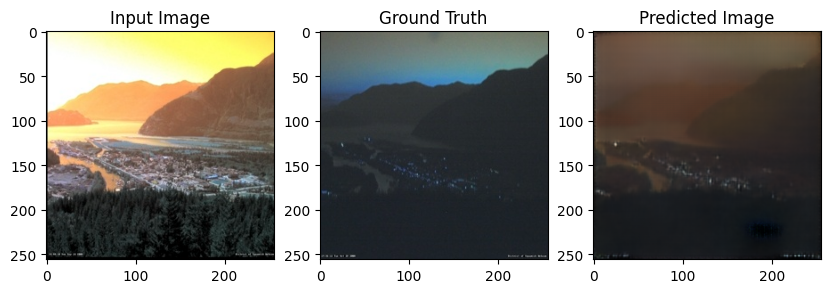

Models saved : gmodel_14000 , dmodel_14000


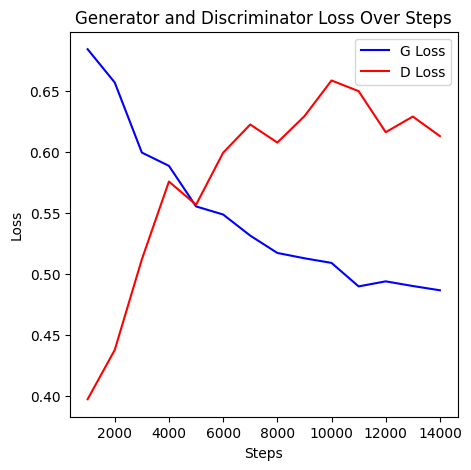

Step 14000/127560  Gen_loss: 0.353  Dis_loss: 0.749 Time: 20ms
Step 14001/127560  Gen_loss: 0.507  Dis_loss: 0.134 Time: 19ms
Step 14002/127560  Gen_loss: 0.301  Dis_loss: 0.627 Time: 22ms
Step 14003/127560  Gen_loss: 0.494  Dis_loss: 0.243 Time: 20ms
Step 14004/127560  Gen_loss: 0.862  Dis_loss: 0.37 Time: 20ms
Step 14005/127560  Gen_loss: 0.234  Dis_loss: 1.126 Time: 20ms
Step 14006/127560  Gen_loss: 0.378  Dis_loss: 0.48 Time: 19ms
Step 14007/127560  Gen_loss: 0.337  Dis_loss: 2.116 Time: 19ms
Step 14008/127560  Gen_loss: 0.59  Dis_loss: 0.329 Time: 21ms
Step 14009/127560  Gen_loss: 0.421  Dis_loss: 0.604 Time: 20ms
Step 14010/127560  Gen_loss: 0.495  Dis_loss: 0.743 Time: 20ms
Step 14011/127560  Gen_loss: 0.601  Dis_loss: 0.251 Time: 19ms
Step 14012/127560  Gen_loss: 0.286  Dis_loss: 0.876 Time: 19ms
Step 14013/127560  Gen_loss: 0.143  Dis_loss: 0.561 Time: 20ms
Step 14014/127560  Gen_loss: 0.484  Dis_loss: 0.2 Time: 20ms
Step 14015/127560  Gen_loss: 0.373  Dis_loss: 1.322 Time: 20

Step 14131/127560  Gen_loss: 0.504  Dis_loss: 0.464 Time: 19ms
Step 14132/127560  Gen_loss: 0.657  Dis_loss: 0.31 Time: 19ms
Step 14133/127560  Gen_loss: 0.738  Dis_loss: 0.873 Time: 20ms
Step 14134/127560  Gen_loss: 0.485  Dis_loss: 0.816 Time: 20ms
Step 14135/127560  Gen_loss: 0.745  Dis_loss: 0.471 Time: 20ms
Step 14136/127560  Gen_loss: 0.618  Dis_loss: 0.691 Time: 20ms
Step 14137/127560  Gen_loss: 0.87  Dis_loss: 0.791 Time: 19ms
Step 14138/127560  Gen_loss: 0.59  Dis_loss: 0.353 Time: 19ms
Step 14139/127560  Gen_loss: 0.796  Dis_loss: 0.375 Time: 20ms
Step 14140/127560  Gen_loss: 0.594  Dis_loss: 0.323 Time: 19ms
Step 14141/127560  Gen_loss: 0.277  Dis_loss: 0.73 Time: 19ms
Step 14142/127560  Gen_loss: 0.598  Dis_loss: 0.214 Time: 19ms
Step 14143/127560  Gen_loss: 0.313  Dis_loss: 0.373 Time: 19ms
Step 14144/127560  Gen_loss: 0.416  Dis_loss: 0.398 Time: 19ms
Step 14145/127560  Gen_loss: 0.451  Dis_loss: 0.899 Time: 19ms
Step 14146/127560  Gen_loss: 0.218  Dis_loss: 0.68 Time: 20

Step 14262/127560  Gen_loss: 0.239  Dis_loss: 0.108 Time: 19ms
Step 14263/127560  Gen_loss: 0.919  Dis_loss: 0.862 Time: 20ms
Step 14264/127560  Gen_loss: 0.397  Dis_loss: 1.338 Time: 20ms
Step 14265/127560  Gen_loss: 0.459  Dis_loss: 0.845 Time: 19ms
Step 14266/127560  Gen_loss: 0.424  Dis_loss: 0.176 Time: 20ms
Step 14267/127560  Gen_loss: 0.635  Dis_loss: 0.512 Time: 20ms
Step 14268/127560  Gen_loss: 0.399  Dis_loss: 0.549 Time: 21ms
Step 14269/127560  Gen_loss: 0.393  Dis_loss: 1.251 Time: 19ms
Step 14270/127560  Gen_loss: 0.412  Dis_loss: 0.109 Time: 19ms
Step 14271/127560  Gen_loss: 0.49  Dis_loss: 0.924 Time: 19ms
Step 14272/127560  Gen_loss: 0.229  Dis_loss: 0.504 Time: 20ms
Step 14273/127560  Gen_loss: 0.697  Dis_loss: 0.302 Time: 19ms
Step 14274/127560  Gen_loss: 0.423  Dis_loss: 0.146 Time: 19ms
Step 14275/127560  Gen_loss: 0.735  Dis_loss: 0.655 Time: 20ms
Step 14276/127560  Gen_loss: 0.378  Dis_loss: 0.679 Time: 21ms
Step 14277/127560  Gen_loss: 0.341  Dis_loss: 1.165 Time

Step 14393/127560  Gen_loss: 0.366  Dis_loss: 0.265 Time: 20ms
Step 14394/127560  Gen_loss: 0.537  Dis_loss: 0.213 Time: 19ms
Step 14395/127560  Gen_loss: 0.509  Dis_loss: 0.771 Time: 19ms
Step 14396/127560  Gen_loss: 0.459  Dis_loss: 0.066 Time: 19ms
Step 14397/127560  Gen_loss: 0.657  Dis_loss: 0.141 Time: 19ms
Step 14398/127560  Gen_loss: 0.415  Dis_loss: 0.88 Time: 19ms
Step 14399/127560  Gen_loss: 0.68  Dis_loss: 0.308 Time: 19ms
Step 14400/127560  Gen_loss: 0.37  Dis_loss: 0.14 Time: 20ms
Step 14401/127560  Gen_loss: 0.702  Dis_loss: 0.219 Time: 19ms
Step 14402/127560  Gen_loss: 0.549  Dis_loss: 0.863 Time: 19ms
Step 14403/127560  Gen_loss: 0.492  Dis_loss: 0.469 Time: 20ms
Step 14404/127560  Gen_loss: 0.543  Dis_loss: 0.374 Time: 19ms
Step 14405/127560  Gen_loss: 0.576  Dis_loss: 0.368 Time: 19ms
Step 14406/127560  Gen_loss: 0.487  Dis_loss: 0.14 Time: 19ms
Step 14407/127560  Gen_loss: 0.221  Dis_loss: 1.584 Time: 19ms
Step 14408/127560  Gen_loss: 0.482  Dis_loss: 0.271 Time: 20

Step 14524/127560  Gen_loss: 0.2  Dis_loss: 1.1 Time: 19ms
Step 14525/127560  Gen_loss: 0.365  Dis_loss: 1.074 Time: 19ms
Step 14526/127560  Gen_loss: 0.453  Dis_loss: 0.81 Time: 19ms
Step 14527/127560  Gen_loss: 0.639  Dis_loss: 0.536 Time: 20ms
Step 14528/127560  Gen_loss: 0.181  Dis_loss: 2.988 Time: 19ms
Step 14529/127560  Gen_loss: 0.862  Dis_loss: 0.416 Time: 19ms
Step 14530/127560  Gen_loss: 0.509  Dis_loss: 0.932 Time: 19ms
Step 14531/127560  Gen_loss: 0.515  Dis_loss: 0.75 Time: 20ms
Step 14532/127560  Gen_loss: 0.224  Dis_loss: 1.021 Time: 19ms
Step 14533/127560  Gen_loss: 0.213  Dis_loss: 0.582 Time: 20ms
Step 14534/127560  Gen_loss: 0.592  Dis_loss: 0.252 Time: 19ms
Step 14535/127560  Gen_loss: 0.456  Dis_loss: 0.474 Time: 19ms
Step 14536/127560  Gen_loss: 0.475  Dis_loss: 0.187 Time: 20ms
Step 14537/127560  Gen_loss: 0.509  Dis_loss: 1.006 Time: 19ms
Step 14538/127560  Gen_loss: 0.191  Dis_loss: 1.627 Time: 19ms
Step 14539/127560  Gen_loss: 0.536  Dis_loss: 0.175 Time: 19m

Step 14655/127560  Gen_loss: 0.481  Dis_loss: 0.421 Time: 19ms
Step 14656/127560  Gen_loss: 0.225  Dis_loss: 0.287 Time: 20ms
Step 14657/127560  Gen_loss: 0.398  Dis_loss: 1.541 Time: 19ms
Step 14658/127560  Gen_loss: 0.905  Dis_loss: 2.958 Time: 20ms
Step 14659/127560  Gen_loss: 0.204  Dis_loss: 1.782 Time: 19ms
Step 14660/127560  Gen_loss: 0.388  Dis_loss: 0.529 Time: 19ms
Step 14661/127560  Gen_loss: 0.714  Dis_loss: 1.518 Time: 19ms
Step 14662/127560  Gen_loss: 0.165  Dis_loss: 0.888 Time: 20ms
Step 14663/127560  Gen_loss: 0.693  Dis_loss: 0.873 Time: 19ms
Step 14664/127560  Gen_loss: 0.979  Dis_loss: 0.399 Time: 19ms
Step 14665/127560  Gen_loss: 0.37  Dis_loss: 0.429 Time: 19ms
Step 14666/127560  Gen_loss: 0.523  Dis_loss: 0.607 Time: 19ms
Step 14667/127560  Gen_loss: 0.661  Dis_loss: 0.361 Time: 19ms
Step 14668/127560  Gen_loss: 0.522  Dis_loss: 0.327 Time: 20ms
Step 14669/127560  Gen_loss: 0.412  Dis_loss: 0.538 Time: 20ms
Step 14670/127560  Gen_loss: 0.458  Dis_loss: 0.469 Time

Step 14786/127560  Gen_loss: 0.383  Dis_loss: 0.356 Time: 19ms
Step 14787/127560  Gen_loss: 0.893  Dis_loss: 0.098 Time: 19ms
Step 14788/127560  Gen_loss: 0.549  Dis_loss: 0.346 Time: 18ms
Step 14789/127560  Gen_loss: 1.022  Dis_loss: 1.707 Time: 19ms
Step 14790/127560  Gen_loss: 0.521  Dis_loss: 0.139 Time: 19ms
Step 14791/127560  Gen_loss: 0.758  Dis_loss: 0.119 Time: 19ms
Step 14792/127560  Gen_loss: 0.352  Dis_loss: 0.437 Time: 19ms
Step 14793/127560  Gen_loss: 0.189  Dis_loss: 0.666 Time: 19ms
Step 14794/127560  Gen_loss: 0.419  Dis_loss: 0.134 Time: 20ms
Step 14795/127560  Gen_loss: 0.492  Dis_loss: 0.06 Time: 19ms
Step 14796/127560  Gen_loss: 0.383  Dis_loss: 0.401 Time: 18ms
Step 14797/127560  Gen_loss: 0.655  Dis_loss: 0.209 Time: 19ms
Step 14798/127560  Gen_loss: 0.54  Dis_loss: 0.528 Time: 19ms
Step 14799/127560  Gen_loss: 0.352  Dis_loss: 0.663 Time: 19ms
Step 14800/127560  Gen_loss: 0.517  Dis_loss: 0.172 Time: 20ms
Step 14801/127560  Gen_loss: 0.588  Dis_loss: 0.407 Time:

Step 14917/127560  Gen_loss: 0.321  Dis_loss: 0.838 Time: 18ms
Step 14918/127560  Gen_loss: 0.467  Dis_loss: 0.217 Time: 20ms
Step 14919/127560  Gen_loss: 0.896  Dis_loss: 0.045 Time: 19ms
Step 14920/127560  Gen_loss: 0.512  Dis_loss: 0.565 Time: 19ms
Step 14921/127560  Gen_loss: 0.351  Dis_loss: 1.488 Time: 20ms
Step 14922/127560  Gen_loss: 0.366  Dis_loss: 0.275 Time: 20ms
Step 14923/127560  Gen_loss: 0.344  Dis_loss: 4.189 Time: 19ms
Step 14924/127560  Gen_loss: 0.646  Dis_loss: 0.103 Time: 19ms
Step 14925/127560  Gen_loss: 0.57  Dis_loss: 2.158 Time: 19ms
Step 14926/127560  Gen_loss: 0.546  Dis_loss: 0.339 Time: 19ms
Step 14927/127560  Gen_loss: 0.196  Dis_loss: 1.11 Time: 19ms
Step 14928/127560  Gen_loss: 0.226  Dis_loss: 0.782 Time: 19ms
Step 14929/127560  Gen_loss: 0.247  Dis_loss: 1.571 Time: 19ms
Step 14930/127560  Gen_loss: 0.518  Dis_loss: 0.863 Time: 20ms
Step 14931/127560  Gen_loss: 0.401  Dis_loss: 1.066 Time: 18ms
Step 14932/127560  Gen_loss: 0.798  Dis_loss: 0.231 Time:

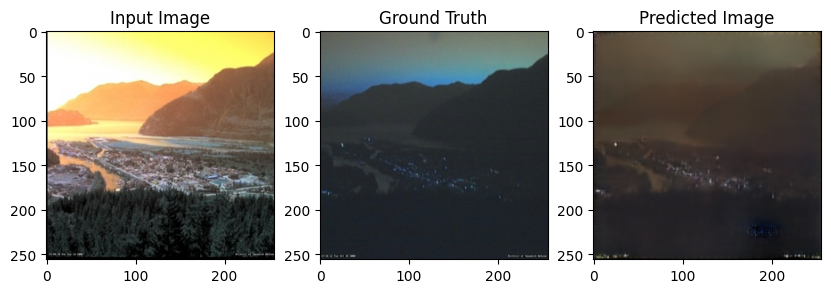

Models saved : gmodel_15000 , dmodel_15000


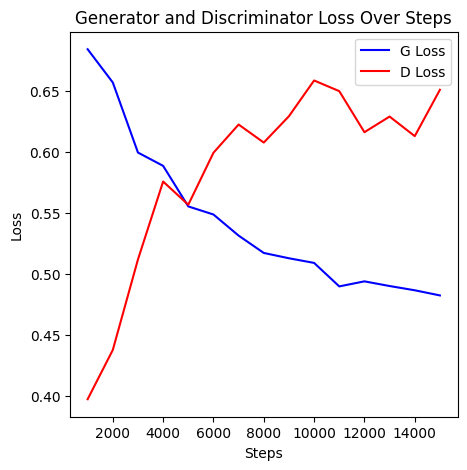

Step 15000/127560  Gen_loss: 0.359  Dis_loss: 0.098 Time: 20ms
Step 15001/127560  Gen_loss: 0.736  Dis_loss: 0.559 Time: 20ms
Step 15002/127560  Gen_loss: 0.407  Dis_loss: 0.353 Time: 19ms
Step 15003/127560  Gen_loss: 0.409  Dis_loss: 0.589 Time: 19ms
Step 15004/127560  Gen_loss: 0.289  Dis_loss: 0.2 Time: 19ms
Step 15005/127560  Gen_loss: 0.436  Dis_loss: 0.313 Time: 18ms
Step 15006/127560  Gen_loss: 0.338  Dis_loss: 0.555 Time: 19ms
Step 15007/127560  Gen_loss: 0.536  Dis_loss: 0.323 Time: 20ms
Step 15008/127560  Gen_loss: 0.416  Dis_loss: 0.608 Time: 19ms
Step 15009/127560  Gen_loss: 0.489  Dis_loss: 0.051 Time: 19ms
Step 15010/127560  Gen_loss: 0.302  Dis_loss: 0.422 Time: 20ms
Step 15011/127560  Gen_loss: 0.389  Dis_loss: 0.909 Time: 20ms
Step 15012/127560  Gen_loss: 0.436  Dis_loss: 0.804 Time: 19ms
Step 15013/127560  Gen_loss: 0.492  Dis_loss: 0.149 Time: 19ms
Step 15014/127560  Gen_loss: 0.659  Dis_loss: 0.03 Time: 20ms
Step 15015/127560  Gen_loss: 0.304  Dis_loss: 0.589 Time: 

Step 15131/127560  Gen_loss: 0.938  Dis_loss: 0.081 Time: 19ms
Step 15132/127560  Gen_loss: 0.183  Dis_loss: 1.366 Time: 19ms
Step 15133/127560  Gen_loss: 0.318  Dis_loss: 0.311 Time: 19ms
Step 15134/127560  Gen_loss: 0.493  Dis_loss: 0.009 Time: 19ms
Step 15135/127560  Gen_loss: 0.692  Dis_loss: 2.64 Time: 19ms
Step 15136/127560  Gen_loss: 0.736  Dis_loss: 0.487 Time: 19ms
Step 15137/127560  Gen_loss: 0.809  Dis_loss: 1.556 Time: 19ms
Step 15138/127560  Gen_loss: 0.595  Dis_loss: 0.435 Time: 20ms
Step 15139/127560  Gen_loss: 0.308  Dis_loss: 0.176 Time: 20ms
Step 15140/127560  Gen_loss: 0.474  Dis_loss: 0.149 Time: 19ms
Step 15141/127560  Gen_loss: 0.541  Dis_loss: 0.226 Time: 19ms
Step 15142/127560  Gen_loss: 0.302  Dis_loss: 0.879 Time: 19ms
Step 15143/127560  Gen_loss: 0.711  Dis_loss: 0.383 Time: 19ms
Step 15144/127560  Gen_loss: 0.484  Dis_loss: 0.246 Time: 20ms
Step 15145/127560  Gen_loss: 0.213  Dis_loss: 0.592 Time: 19ms
Step 15146/127560  Gen_loss: 0.701  Dis_loss: 0.706 Time

Step 15262/127560  Gen_loss: 0.587  Dis_loss: 0.164 Time: 21ms
Step 15263/127560  Gen_loss: 0.421  Dis_loss: 1.577 Time: 19ms
Step 15264/127560  Gen_loss: 0.615  Dis_loss: 0.885 Time: 21ms
Step 15265/127560  Gen_loss: 0.347  Dis_loss: 1.292 Time: 20ms
Step 15266/127560  Gen_loss: 0.824  Dis_loss: 0.766 Time: 21ms
Step 15267/127560  Gen_loss: 0.285  Dis_loss: 0.097 Time: 21ms
Step 15268/127560  Gen_loss: 0.489  Dis_loss: 0.479 Time: 20ms
Step 15269/127560  Gen_loss: 0.703  Dis_loss: 0.34 Time: 20ms
Step 15270/127560  Gen_loss: 0.229  Dis_loss: 0.819 Time: 20ms
Step 15271/127560  Gen_loss: 0.297  Dis_loss: 2.005 Time: 20ms
Step 15272/127560  Gen_loss: 0.283  Dis_loss: 0.844 Time: 21ms
Step 15273/127560  Gen_loss: 0.572  Dis_loss: 1.303 Time: 20ms
Step 15274/127560  Gen_loss: 0.417  Dis_loss: 0.437 Time: 21ms
Step 15275/127560  Gen_loss: 0.916  Dis_loss: 0.167 Time: 20ms
Step 15276/127560  Gen_loss: 0.787  Dis_loss: 0.319 Time: 21ms
Step 15277/127560  Gen_loss: 0.186  Dis_loss: 0.521 Time

Step 15393/127560  Gen_loss: 0.462  Dis_loss: 1.065 Time: 20ms
Step 15394/127560  Gen_loss: 0.534  Dis_loss: 0.126 Time: 19ms
Step 15395/127560  Gen_loss: 0.533  Dis_loss: 0.142 Time: 19ms
Step 15396/127560  Gen_loss: 0.329  Dis_loss: 0.084 Time: 19ms
Step 15397/127560  Gen_loss: 0.979  Dis_loss: 0.201 Time: 20ms
Step 15398/127560  Gen_loss: 0.646  Dis_loss: 0.072 Time: 20ms
Step 15399/127560  Gen_loss: 0.545  Dis_loss: 0.225 Time: 20ms
Step 15400/127560  Gen_loss: 0.374  Dis_loss: 0.187 Time: 19ms
Step 15401/127560  Gen_loss: 0.498  Dis_loss: 0.207 Time: 19ms
Step 15402/127560  Gen_loss: 0.22  Dis_loss: 0.139 Time: 20ms
Step 15403/127560  Gen_loss: 0.465  Dis_loss: 0.203 Time: 19ms
Step 15404/127560  Gen_loss: 0.179  Dis_loss: 0.238 Time: 19ms
Step 15405/127560  Gen_loss: 0.394  Dis_loss: 0.875 Time: 19ms
Step 15406/127560  Gen_loss: 0.43  Dis_loss: 0.101 Time: 19ms
Step 15407/127560  Gen_loss: 0.652  Dis_loss: 0.303 Time: 20ms
Step 15408/127560  Gen_loss: 0.34  Dis_loss: 0.11 Time: 1

Step 15524/127560  Gen_loss: 0.613  Dis_loss: 1.244 Time: 20ms
Step 15525/127560  Gen_loss: 0.5  Dis_loss: 0.338 Time: 19ms
Step 15526/127560  Gen_loss: 0.336  Dis_loss: 0.854 Time: 20ms
Step 15527/127560  Gen_loss: 0.499  Dis_loss: 0.072 Time: 20ms
Step 15528/127560  Gen_loss: 0.284  Dis_loss: 0.283 Time: 19ms
Step 15529/127560  Gen_loss: 0.227  Dis_loss: 1.658 Time: 19ms
Step 15530/127560  Gen_loss: 0.485  Dis_loss: 0.606 Time: 20ms
Step 15531/127560  Gen_loss: 0.371  Dis_loss: 0.882 Time: 19ms
Step 15532/127560  Gen_loss: 0.634  Dis_loss: 0.198 Time: 19ms
Step 15533/127560  Gen_loss: 0.399  Dis_loss: 0.404 Time: 19ms
Step 15534/127560  Gen_loss: 0.367  Dis_loss: 1.585 Time: 19ms
Step 15535/127560  Gen_loss: 0.539  Dis_loss: 0.212 Time: 19ms
Step 15536/127560  Gen_loss: 0.232  Dis_loss: 0.859 Time: 19ms
Step 15537/127560  Gen_loss: 0.224  Dis_loss: 1.608 Time: 19ms
Step 15538/127560  Gen_loss: 0.494  Dis_loss: 1.14 Time: 19ms
Step 15539/127560  Gen_loss: 0.695  Dis_loss: 2.128 Time: 

Step 15655/127560  Gen_loss: 0.503  Dis_loss: 0.251 Time: 19ms
Step 15656/127560  Gen_loss: 0.268  Dis_loss: 2.425 Time: 19ms
Step 15657/127560  Gen_loss: 0.549  Dis_loss: 1.264 Time: 20ms
Step 15658/127560  Gen_loss: 0.505  Dis_loss: 0.316 Time: 20ms
Step 15659/127560  Gen_loss: 0.519  Dis_loss: 1.315 Time: 20ms
Step 15660/127560  Gen_loss: 0.15  Dis_loss: 0.632 Time: 19ms
Step 15661/127560  Gen_loss: 0.392  Dis_loss: 0.692 Time: 19ms
Step 15662/127560  Gen_loss: 0.454  Dis_loss: 0.287 Time: 19ms
Step 15663/127560  Gen_loss: 0.467  Dis_loss: 0.252 Time: 19ms
Step 15664/127560  Gen_loss: 0.45  Dis_loss: 1.159 Time: 20ms
Step 15665/127560  Gen_loss: 0.699  Dis_loss: 1.031 Time: 19ms
Step 15666/127560  Gen_loss: 0.582  Dis_loss: 0.738 Time: 20ms
Step 15667/127560  Gen_loss: 0.337  Dis_loss: 0.194 Time: 19ms
Step 15668/127560  Gen_loss: 0.35  Dis_loss: 0.748 Time: 19ms
Step 15669/127560  Gen_loss: 0.434  Dis_loss: 0.146 Time: 19ms
Step 15670/127560  Gen_loss: 0.49  Dis_loss: 1.044 Time: 2

Step 15786/127560  Gen_loss: 0.522  Dis_loss: 0.387 Time: 19ms
Step 15787/127560  Gen_loss: 0.329  Dis_loss: 0.369 Time: 19ms
Step 15788/127560  Gen_loss: 0.427  Dis_loss: 1.687 Time: 20ms
Step 15789/127560  Gen_loss: 0.707  Dis_loss: 1.476 Time: 19ms
Step 15790/127560  Gen_loss: 0.515  Dis_loss: 0.578 Time: 19ms
Step 15791/127560  Gen_loss: 0.475  Dis_loss: 0.076 Time: 19ms
Step 15792/127560  Gen_loss: 0.523  Dis_loss: 0.168 Time: 20ms
Step 15793/127560  Gen_loss: 0.346  Dis_loss: 1.014 Time: 20ms
Step 15794/127560  Gen_loss: 0.394  Dis_loss: 1.723 Time: 19ms
Step 15795/127560  Gen_loss: 0.853  Dis_loss: 0.569 Time: 20ms
Step 15796/127560  Gen_loss: 0.456  Dis_loss: 0.552 Time: 19ms
Step 15797/127560  Gen_loss: 0.299  Dis_loss: 2.192 Time: 19ms
Step 15798/127560  Gen_loss: 0.479  Dis_loss: 0.743 Time: 19ms
Step 15799/127560  Gen_loss: 0.693  Dis_loss: 1.402 Time: 20ms
Step 15800/127560  Gen_loss: 0.444  Dis_loss: 0.81 Time: 19ms
Step 15801/127560  Gen_loss: 0.486  Dis_loss: 0.314 Time

Step 15917/127560  Gen_loss: 0.337  Dis_loss: 1.731 Time: 21ms
Step 15918/127560  Gen_loss: 0.388  Dis_loss: 0.253 Time: 20ms
Step 15919/127560  Gen_loss: 0.462  Dis_loss: 0.394 Time: 19ms
Step 15920/127560  Gen_loss: 0.199  Dis_loss: 0.339 Time: 19ms
Step 15921/127560  Gen_loss: 0.551  Dis_loss: 0.294 Time: 19ms
Step 15922/127560  Gen_loss: 0.607  Dis_loss: 0.377 Time: 20ms
Step 15923/127560  Gen_loss: 0.455  Dis_loss: 0.437 Time: 20ms
Step 15924/127560  Gen_loss: 0.491  Dis_loss: 0.073 Time: 19ms
Step 15925/127560  Gen_loss: 0.137  Dis_loss: 1.677 Time: 19ms
Step 15926/127560  Gen_loss: 0.126  Dis_loss: 0.342 Time: 20ms
Step 15927/127560  Gen_loss: 0.412  Dis_loss: 0.186 Time: 20ms
Step 15928/127560  Gen_loss: 0.322  Dis_loss: 0.143 Time: 19ms
Step 15929/127560  Gen_loss: 0.443  Dis_loss: 0.502 Time: 19ms
Step 15930/127560  Gen_loss: 0.669  Dis_loss: 1.118 Time: 19ms
Step 15931/127560  Gen_loss: 0.422  Dis_loss: 0.829 Time: 18ms
Step 15932/127560  Gen_loss: 0.26  Dis_loss: 0.561 Time

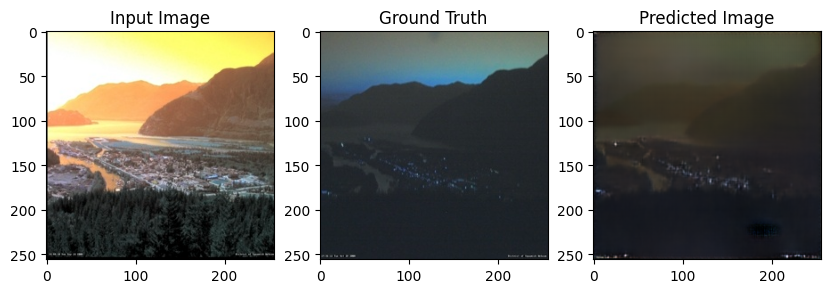

Models saved : gmodel_16000 , dmodel_16000


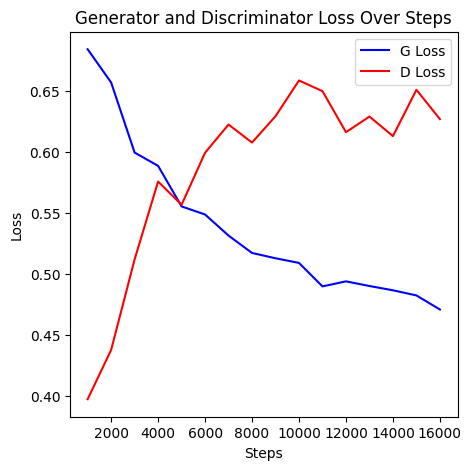

Step 16000/127560  Gen_loss: 0.705  Dis_loss: 0.04 Time: 20ms
Step 16001/127560  Gen_loss: 0.224  Dis_loss: 1.288 Time: 20ms
Step 16002/127560  Gen_loss: 0.771  Dis_loss: 0.548 Time: 19ms
Step 16003/127560  Gen_loss: 0.178  Dis_loss: 2.079 Time: 19ms
Step 16004/127560  Gen_loss: 0.457  Dis_loss: 0.342 Time: 19ms
Step 16005/127560  Gen_loss: 0.532  Dis_loss: 1.024 Time: 19ms
Step 16006/127560  Gen_loss: 0.473  Dis_loss: 0.593 Time: 19ms
Step 16007/127560  Gen_loss: 0.645  Dis_loss: 0.634 Time: 20ms
Step 16008/127560  Gen_loss: 0.6  Dis_loss: 0.188 Time: 19ms
Step 16009/127560  Gen_loss: 0.492  Dis_loss: 0.17 Time: 19ms
Step 16010/127560  Gen_loss: 0.416  Dis_loss: 0.495 Time: 18ms
Step 16011/127560  Gen_loss: 0.477  Dis_loss: 1.46 Time: 19ms
Step 16012/127560  Gen_loss: 0.393  Dis_loss: 0.441 Time: 20ms
Step 16013/127560  Gen_loss: 0.409  Dis_loss: 0.662 Time: 19ms
Step 16014/127560  Gen_loss: 0.218  Dis_loss: 0.359 Time: 19ms
Step 16015/127560  Gen_loss: 0.456  Dis_loss: 1.101 Time: 20

Step 16131/127560  Gen_loss: 0.618  Dis_loss: 0.186 Time: 19ms
Step 16132/127560  Gen_loss: 0.365  Dis_loss: 0.15 Time: 19ms
Step 16133/127560  Gen_loss: 0.615  Dis_loss: 0.135 Time: 20ms
Step 16134/127560  Gen_loss: 0.665  Dis_loss: 0.439 Time: 19ms
Step 16135/127560  Gen_loss: 0.596  Dis_loss: 1.768 Time: 19ms
Step 16136/127560  Gen_loss: 0.285  Dis_loss: 0.332 Time: 19ms
Step 16137/127560  Gen_loss: 0.339  Dis_loss: 0.343 Time: 19ms
Step 16138/127560  Gen_loss: 0.296  Dis_loss: 0.103 Time: 20ms
Step 16139/127560  Gen_loss: 0.442  Dis_loss: 0.651 Time: 19ms
Step 16140/127560  Gen_loss: 0.39  Dis_loss: 0.822 Time: 19ms
Step 16141/127560  Gen_loss: 0.432  Dis_loss: 0.367 Time: 19ms
Step 16142/127560  Gen_loss: 0.39  Dis_loss: 0.605 Time: 20ms
Step 16143/127560  Gen_loss: 0.357  Dis_loss: 0.341 Time: 19ms
Step 16144/127560  Gen_loss: 0.463  Dis_loss: 1.299 Time: 19ms
Step 16145/127560  Gen_loss: 0.377  Dis_loss: 0.727 Time: 19ms
Step 16146/127560  Gen_loss: 0.65  Dis_loss: 0.291 Time: 1

Step 16262/127560  Gen_loss: 0.46  Dis_loss: 0.357 Time: 19ms
Step 16263/127560  Gen_loss: 0.469  Dis_loss: 0.243 Time: 19ms
Step 16264/127560  Gen_loss: 0.478  Dis_loss: 1.787 Time: 19ms
Step 16265/127560  Gen_loss: 0.33  Dis_loss: 0.357 Time: 19ms
Step 16266/127560  Gen_loss: 0.326  Dis_loss: 0.455 Time: 19ms
Step 16267/127560  Gen_loss: 0.181  Dis_loss: 1.209 Time: 19ms
Step 16268/127560  Gen_loss: 0.591  Dis_loss: 0.164 Time: 20ms
Step 16269/127560  Gen_loss: 0.461  Dis_loss: 1.627 Time: 19ms
Step 16270/127560  Gen_loss: 0.68  Dis_loss: 0.456 Time: 20ms
Step 16271/127560  Gen_loss: 0.155  Dis_loss: 1.423 Time: 19ms
Step 16272/127560  Gen_loss: 0.296  Dis_loss: 0.058 Time: 18ms
Step 16273/127560  Gen_loss: 0.371  Dis_loss: 0.34 Time: 19ms
Step 16274/127560  Gen_loss: 0.204  Dis_loss: 0.415 Time: 19ms
Step 16275/127560  Gen_loss: 0.553  Dis_loss: 0.35 Time: 20ms
Step 16276/127560  Gen_loss: 0.496  Dis_loss: 0.23 Time: 19ms
Step 16277/127560  Gen_loss: 0.432  Dis_loss: 0.239 Time: 19m

Step 16393/127560  Gen_loss: 0.324  Dis_loss: 0.47 Time: 19ms
Step 16394/127560  Gen_loss: 0.61  Dis_loss: 0.47 Time: 20ms
Step 16395/127560  Gen_loss: 0.438  Dis_loss: 0.506 Time: 19ms
Step 16396/127560  Gen_loss: 0.204  Dis_loss: 0.709 Time: 19ms
Step 16397/127560  Gen_loss: 0.492  Dis_loss: 0.191 Time: 20ms
Step 16398/127560  Gen_loss: 0.421  Dis_loss: 0.079 Time: 19ms
Step 16399/127560  Gen_loss: 0.242  Dis_loss: 2.801 Time: 19ms
Step 16400/127560  Gen_loss: 0.511  Dis_loss: 0.655 Time: 20ms
Step 16401/127560  Gen_loss: 0.865  Dis_loss: 0.167 Time: 19ms
Step 16402/127560  Gen_loss: 0.334  Dis_loss: 0.631 Time: 20ms
Step 16403/127560  Gen_loss: 0.878  Dis_loss: 1.288 Time: 19ms
Step 16404/127560  Gen_loss: 0.451  Dis_loss: 0.606 Time: 19ms
Step 16405/127560  Gen_loss: 0.543  Dis_loss: 0.617 Time: 19ms
Step 16406/127560  Gen_loss: 0.386  Dis_loss: 1.599 Time: 19ms
Step 16407/127560  Gen_loss: 0.56  Dis_loss: 0.362 Time: 20ms
Step 16408/127560  Gen_loss: 0.456  Dis_loss: 0.902 Time: 1

Step 16524/127560  Gen_loss: 0.4  Dis_loss: 1.266 Time: 19ms
Step 16525/127560  Gen_loss: 0.576  Dis_loss: 0.2 Time: 20ms
Step 16526/127560  Gen_loss: 0.232  Dis_loss: 0.906 Time: 19ms
Step 16527/127560  Gen_loss: 0.881  Dis_loss: 0.615 Time: 20ms
Step 16528/127560  Gen_loss: 0.308  Dis_loss: 1.732 Time: 19ms
Step 16529/127560  Gen_loss: 0.294  Dis_loss: 0.341 Time: 19ms
Step 16530/127560  Gen_loss: 0.303  Dis_loss: 0.503 Time: 20ms
Step 16531/127560  Gen_loss: 0.489  Dis_loss: 0.211 Time: 19ms
Step 16532/127560  Gen_loss: 0.469  Dis_loss: 0.188 Time: 20ms
Step 16533/127560  Gen_loss: 0.409  Dis_loss: 0.173 Time: 19ms
Step 16534/127560  Gen_loss: 0.768  Dis_loss: 0.367 Time: 20ms
Step 16535/127560  Gen_loss: 0.478  Dis_loss: 1.079 Time: 20ms
Step 16536/127560  Gen_loss: 0.458  Dis_loss: 3.028 Time: 19ms
Step 16537/127560  Gen_loss: 0.192  Dis_loss: 1.005 Time: 19ms
Step 16538/127560  Gen_loss: 0.754  Dis_loss: 0.085 Time: 19ms
Step 16539/127560  Gen_loss: 0.387  Dis_loss: 0.517 Time: 2

Step 16655/127560  Gen_loss: 0.157  Dis_loss: 0.58 Time: 20ms
Step 16656/127560  Gen_loss: 0.231  Dis_loss: 1.192 Time: 18ms
Step 16657/127560  Gen_loss: 0.48  Dis_loss: 0.29 Time: 20ms
Step 16658/127560  Gen_loss: 0.287  Dis_loss: 0.228 Time: 19ms
Step 16659/127560  Gen_loss: 0.632  Dis_loss: 0.365 Time: 20ms
Step 16660/127560  Gen_loss: 0.587  Dis_loss: 0.162 Time: 18ms
Step 16661/127560  Gen_loss: 0.617  Dis_loss: 0.193 Time: 19ms
Step 16662/127560  Gen_loss: 0.443  Dis_loss: 0.486 Time: 20ms
Step 16663/127560  Gen_loss: 1.174  Dis_loss: 0.211 Time: 20ms
Step 16664/127560  Gen_loss: 0.204  Dis_loss: 1.288 Time: 19ms
Step 16665/127560  Gen_loss: 0.39  Dis_loss: 0.389 Time: 19ms
Step 16666/127560  Gen_loss: 0.512  Dis_loss: 0.263 Time: 19ms
Step 16667/127560  Gen_loss: 0.415  Dis_loss: 0.414 Time: 20ms
Step 16668/127560  Gen_loss: 0.631  Dis_loss: 0.042 Time: 20ms
Step 16669/127560  Gen_loss: 0.435  Dis_loss: 0.782 Time: 20ms
Step 16670/127560  Gen_loss: 0.64  Dis_loss: 0.704 Time: 19

Step 16786/127560  Gen_loss: 0.282  Dis_loss: 0.05 Time: 19ms
Step 16787/127560  Gen_loss: 0.576  Dis_loss: 0.295 Time: 19ms
Step 16788/127560  Gen_loss: 0.246  Dis_loss: 0.776 Time: 20ms
Step 16789/127560  Gen_loss: 0.099  Dis_loss: 1.161 Time: 19ms
Step 16790/127560  Gen_loss: 0.649  Dis_loss: 0.444 Time: 19ms
Step 16791/127560  Gen_loss: 0.387  Dis_loss: 0.479 Time: 19ms
Step 16792/127560  Gen_loss: 0.715  Dis_loss: 0.475 Time: 20ms
Step 16793/127560  Gen_loss: 0.474  Dis_loss: 0.525 Time: 19ms
Step 16794/127560  Gen_loss: 0.501  Dis_loss: 0.584 Time: 19ms
Step 16795/127560  Gen_loss: 0.215  Dis_loss: 0.596 Time: 19ms
Step 16796/127560  Gen_loss: 0.485  Dis_loss: 1.468 Time: 19ms
Step 16797/127560  Gen_loss: 0.498  Dis_loss: 0.252 Time: 19ms
Step 16798/127560  Gen_loss: 0.456  Dis_loss: 0.38 Time: 20ms
Step 16799/127560  Gen_loss: 0.695  Dis_loss: 0.076 Time: 20ms
Step 16800/127560  Gen_loss: 0.372  Dis_loss: 0.34 Time: 19ms
Step 16801/127560  Gen_loss: 0.349  Dis_loss: 0.724 Time: 

Step 16917/127560  Gen_loss: 0.344  Dis_loss: 0.33 Time: 20ms
Step 16918/127560  Gen_loss: 0.588  Dis_loss: 0.857 Time: 19ms
Step 16919/127560  Gen_loss: 0.623  Dis_loss: 0.179 Time: 19ms
Step 16920/127560  Gen_loss: 0.306  Dis_loss: 1.09 Time: 19ms
Step 16921/127560  Gen_loss: 0.614  Dis_loss: 0.196 Time: 19ms
Step 16922/127560  Gen_loss: 0.806  Dis_loss: 0.063 Time: 19ms
Step 16923/127560  Gen_loss: 0.396  Dis_loss: 1.565 Time: 19ms
Step 16924/127560  Gen_loss: 0.357  Dis_loss: 0.034 Time: 19ms
Step 16925/127560  Gen_loss: 0.39  Dis_loss: 0.122 Time: 19ms
Step 16926/127560  Gen_loss: 0.192  Dis_loss: 1.628 Time: 19ms
Step 16927/127560  Gen_loss: 0.53  Dis_loss: 0.205 Time: 19ms
Step 16928/127560  Gen_loss: 0.737  Dis_loss: 0.103 Time: 19ms
Step 16929/127560  Gen_loss: 0.308  Dis_loss: 0.495 Time: 20ms
Step 16930/127560  Gen_loss: 0.416  Dis_loss: 0.351 Time: 19ms
Step 16931/127560  Gen_loss: 0.928  Dis_loss: 0.889 Time: 19ms
Step 16932/127560  Gen_loss: 0.462  Dis_loss: 0.377 Time: 1

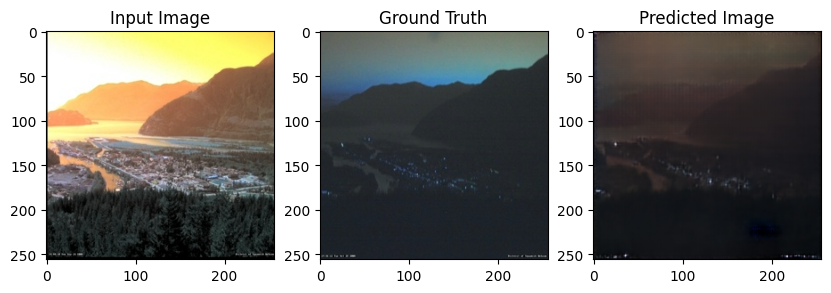

Models saved : gmodel_17000 , dmodel_17000


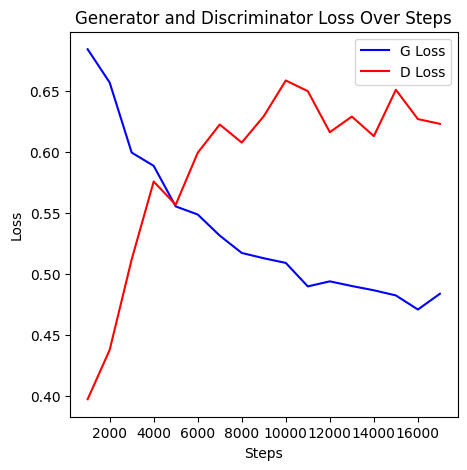

Step 17000/127560  Gen_loss: 0.64  Dis_loss: 0.248 Time: 19ms
Step 17001/127560  Gen_loss: 0.299  Dis_loss: 1.053 Time: 19ms
Step 17002/127560  Gen_loss: 0.572  Dis_loss: 0.131 Time: 19ms
Step 17003/127560  Gen_loss: 0.596  Dis_loss: 0.118 Time: 20ms
Step 17004/127560  Gen_loss: 0.533  Dis_loss: 0.584 Time: 20ms
Step 17005/127560  Gen_loss: 0.502  Dis_loss: 0.208 Time: 19ms
Step 17006/127560  Gen_loss: 0.453  Dis_loss: 0.731 Time: 18ms
Step 17007/127560  Gen_loss: 0.662  Dis_loss: 1.707 Time: 19ms
Step 17008/127560  Gen_loss: 0.795  Dis_loss: 0.353 Time: 52ms
Step 17009/127560  Gen_loss: 0.465  Dis_loss: 0.032 Time: 21ms
Step 17010/127560  Gen_loss: 0.416  Dis_loss: 1.615 Time: 21ms
Step 17011/127560  Gen_loss: 0.452  Dis_loss: 0.087 Time: 20ms
Step 17012/127560  Gen_loss: 0.416  Dis_loss: 0.347 Time: 22ms
Step 17013/127560  Gen_loss: 0.341  Dis_loss: 2.172 Time: 22ms
Step 17014/127560  Gen_loss: 0.495  Dis_loss: 0.256 Time: 21ms
Step 17015/127560  Gen_loss: 0.769  Dis_loss: 2.229 Time

Step 17131/127560  Gen_loss: 0.553  Dis_loss: 0.251 Time: 21ms
Step 17132/127560  Gen_loss: 0.309  Dis_loss: 2.547 Time: 21ms
Step 17133/127560  Gen_loss: 0.29  Dis_loss: 2.587 Time: 21ms
Step 17134/127560  Gen_loss: 0.516  Dis_loss: 1.188 Time: 21ms
Step 17135/127560  Gen_loss: 0.4  Dis_loss: 1.178 Time: 21ms
Step 17136/127560  Gen_loss: 0.473  Dis_loss: 0.334 Time: 21ms
Step 17137/127560  Gen_loss: 0.789  Dis_loss: 0.23 Time: 20ms
Step 17138/127560  Gen_loss: 0.588  Dis_loss: 0.336 Time: 21ms
Step 17139/127560  Gen_loss: 0.454  Dis_loss: 0.199 Time: 21ms
Step 17140/127560  Gen_loss: 0.103  Dis_loss: 1.172 Time: 21ms
Step 17141/127560  Gen_loss: 0.209  Dis_loss: 0.35 Time: 21ms
Step 17142/127560  Gen_loss: 0.447  Dis_loss: 0.24 Time: 20ms
Step 17143/127560  Gen_loss: 0.513  Dis_loss: 0.18 Time: 19ms
Step 17144/127560  Gen_loss: 0.166  Dis_loss: 1.123 Time: 20ms
Step 17145/127560  Gen_loss: 0.487  Dis_loss: 0.45 Time: 20ms
Step 17146/127560  Gen_loss: 0.757  Dis_loss: 0.289 Time: 20ms


Step 17262/127560  Gen_loss: 0.177  Dis_loss: 0.743 Time: 19ms
Step 17263/127560  Gen_loss: 0.401  Dis_loss: 0.25 Time: 19ms
Step 17264/127560  Gen_loss: 0.74  Dis_loss: 0.483 Time: 19ms
Step 17265/127560  Gen_loss: 0.453  Dis_loss: 0.471 Time: 19ms
Step 17266/127560  Gen_loss: 0.473  Dis_loss: 0.469 Time: 19ms
Step 17267/127560  Gen_loss: 0.504  Dis_loss: 0.059 Time: 19ms
Step 17268/127560  Gen_loss: 0.365  Dis_loss: 0.252 Time: 19ms
Step 17269/127560  Gen_loss: 0.299  Dis_loss: 0.377 Time: 19ms
Step 17270/127560  Gen_loss: 0.42  Dis_loss: 0.678 Time: 19ms
Step 17271/127560  Gen_loss: 0.263  Dis_loss: 0.406 Time: 18ms
Step 17272/127560  Gen_loss: 0.204  Dis_loss: 0.658 Time: 20ms
Step 17273/127560  Gen_loss: 0.85  Dis_loss: 0.079 Time: 20ms
Step 17274/127560  Gen_loss: 0.629  Dis_loss: 0.186 Time: 20ms
Step 17275/127560  Gen_loss: 0.682  Dis_loss: 0.177 Time: 19ms
Step 17276/127560  Gen_loss: 0.379  Dis_loss: 0.554 Time: 19ms
Step 17277/127560  Gen_loss: 0.385  Dis_loss: 0.496 Time: 2

Step 17393/127560  Gen_loss: 0.654  Dis_loss: 0.219 Time: 18ms
Step 17394/127560  Gen_loss: 0.764  Dis_loss: 0.65 Time: 19ms
Step 17395/127560  Gen_loss: 0.202  Dis_loss: 1.962 Time: 19ms
Step 17396/127560  Gen_loss: 0.529  Dis_loss: 0.343 Time: 19ms
Step 17397/127560  Gen_loss: 0.634  Dis_loss: 0.762 Time: 19ms
Step 17398/127560  Gen_loss: 0.343  Dis_loss: 0.206 Time: 19ms
Step 17399/127560  Gen_loss: 0.522  Dis_loss: 0.019 Time: 20ms
Step 17400/127560  Gen_loss: 0.617  Dis_loss: 1.337 Time: 20ms
Step 17401/127560  Gen_loss: 0.381  Dis_loss: 0.718 Time: 19ms
Step 17402/127560  Gen_loss: 0.211  Dis_loss: 1.829 Time: 20ms
Step 17403/127560  Gen_loss: 0.615  Dis_loss: 0.19 Time: 19ms
Step 17404/127560  Gen_loss: 0.415  Dis_loss: 0.038 Time: 19ms
Step 17405/127560  Gen_loss: 0.325  Dis_loss: 0.504 Time: 20ms
Step 17406/127560  Gen_loss: 0.506  Dis_loss: 0.317 Time: 20ms
Step 17407/127560  Gen_loss: 0.424  Dis_loss: 0.7 Time: 20ms
Step 17408/127560  Gen_loss: 0.446  Dis_loss: 0.064 Time: 1

Step 17524/127560  Gen_loss: 0.451  Dis_loss: 0.637 Time: 20ms
Step 17525/127560  Gen_loss: 0.524  Dis_loss: 0.407 Time: 20ms
Step 17526/127560  Gen_loss: 0.454  Dis_loss: 0.074 Time: 20ms
Step 17527/127560  Gen_loss: 0.414  Dis_loss: 0.419 Time: 20ms
Step 17528/127560  Gen_loss: 0.449  Dis_loss: 0.449 Time: 20ms
Step 17529/127560  Gen_loss: 0.521  Dis_loss: 0.302 Time: 21ms
Step 17530/127560  Gen_loss: 0.357  Dis_loss: 0.126 Time: 20ms
Step 17531/127560  Gen_loss: 0.423  Dis_loss: 1.287 Time: 19ms
Step 17532/127560  Gen_loss: 0.48  Dis_loss: 0.192 Time: 21ms
Step 17533/127560  Gen_loss: 0.496  Dis_loss: 0.051 Time: 20ms
Step 17534/127560  Gen_loss: 0.524  Dis_loss: 0.333 Time: 20ms
Step 17535/127560  Gen_loss: 0.187  Dis_loss: 0.218 Time: 20ms
Step 17536/127560  Gen_loss: 0.702  Dis_loss: 0.152 Time: 19ms
Step 17537/127560  Gen_loss: 0.598  Dis_loss: 0.08 Time: 19ms
Step 17538/127560  Gen_loss: 0.199  Dis_loss: 0.916 Time: 19ms
Step 17539/127560  Gen_loss: 0.327  Dis_loss: 0.643 Time:

Step 17655/127560  Gen_loss: 0.466  Dis_loss: 0.262 Time: 19ms
Step 17656/127560  Gen_loss: 0.513  Dis_loss: 0.542 Time: 19ms
Step 17657/127560  Gen_loss: 0.423  Dis_loss: 0.703 Time: 19ms
Step 17658/127560  Gen_loss: 0.346  Dis_loss: 0.262 Time: 19ms
Step 17659/127560  Gen_loss: 0.653  Dis_loss: 0.217 Time: 19ms
Step 17660/127560  Gen_loss: 0.487  Dis_loss: 0.313 Time: 20ms
Step 17661/127560  Gen_loss: 0.544  Dis_loss: 0.214 Time: 19ms
Step 17662/127560  Gen_loss: 0.126  Dis_loss: 2.369 Time: 19ms
Step 17663/127560  Gen_loss: 0.656  Dis_loss: 0.082 Time: 20ms
Step 17664/127560  Gen_loss: 0.384  Dis_loss: 0.128 Time: 19ms
Step 17665/127560  Gen_loss: 0.632  Dis_loss: 0.026 Time: 19ms
Step 17666/127560  Gen_loss: 0.45  Dis_loss: 0.898 Time: 18ms
Step 17667/127560  Gen_loss: 0.49  Dis_loss: 0.494 Time: 20ms
Step 17668/127560  Gen_loss: 0.297  Dis_loss: 0.36 Time: 20ms
Step 17669/127560  Gen_loss: 0.614  Dis_loss: 0.125 Time: 19ms
Step 17670/127560  Gen_loss: 0.278  Dis_loss: 0.958 Time: 

Step 17786/127560  Gen_loss: 0.453  Dis_loss: 0.67 Time: 19ms
Step 17787/127560  Gen_loss: 0.299  Dis_loss: 0.582 Time: 19ms
Step 17788/127560  Gen_loss: 0.489  Dis_loss: 0.93 Time: 19ms
Step 17789/127560  Gen_loss: 0.557  Dis_loss: 0.19 Time: 19ms
Step 17790/127560  Gen_loss: 0.45  Dis_loss: 0.148 Time: 20ms
Step 17791/127560  Gen_loss: 0.652  Dis_loss: 0.212 Time: 19ms
Step 17792/127560  Gen_loss: 0.297  Dis_loss: 0.31 Time: 19ms
Step 17793/127560  Gen_loss: 0.373  Dis_loss: 0.269 Time: 19ms
Step 17794/127560  Gen_loss: 0.724  Dis_loss: 0.105 Time: 20ms
Step 17795/127560  Gen_loss: 0.72  Dis_loss: 0.72 Time: 19ms
Step 17796/127560  Gen_loss: 0.618  Dis_loss: 0.079 Time: 19ms
Step 17797/127560  Gen_loss: 0.57  Dis_loss: 0.658 Time: 19ms
Step 17798/127560  Gen_loss: 0.507  Dis_loss: 0.114 Time: 19ms
Step 17799/127560  Gen_loss: 0.706  Dis_loss: 0.625 Time: 19ms
Step 17800/127560  Gen_loss: 0.366  Dis_loss: 0.366 Time: 19ms
Step 17801/127560  Gen_loss: 0.557  Dis_loss: 0.201 Time: 19ms


Step 17917/127560  Gen_loss: 0.237  Dis_loss: 0.899 Time: 19ms
Step 17918/127560  Gen_loss: 0.481  Dis_loss: 0.627 Time: 19ms
Step 17919/127560  Gen_loss: 0.42  Dis_loss: 2.117 Time: 19ms
Step 17920/127560  Gen_loss: 0.475  Dis_loss: 1.002 Time: 19ms
Step 17921/127560  Gen_loss: 0.778  Dis_loss: 0.622 Time: 19ms
Step 17922/127560  Gen_loss: 0.317  Dis_loss: 0.469 Time: 19ms
Step 17923/127560  Gen_loss: 0.716  Dis_loss: 0.225 Time: 19ms
Step 17924/127560  Gen_loss: 0.149  Dis_loss: 0.226 Time: 20ms
Step 17925/127560  Gen_loss: 0.437  Dis_loss: 0.552 Time: 19ms
Step 17926/127560  Gen_loss: 0.488  Dis_loss: 0.939 Time: 19ms
Step 17927/127560  Gen_loss: 0.679  Dis_loss: 0.407 Time: 19ms
Step 17928/127560  Gen_loss: 0.541  Dis_loss: 0.235 Time: 19ms
Step 17929/127560  Gen_loss: 0.93  Dis_loss: 0.031 Time: 20ms
Step 17930/127560  Gen_loss: 0.513  Dis_loss: 0.618 Time: 19ms
Step 17931/127560  Gen_loss: 0.361  Dis_loss: 1.78 Time: 20ms
Step 17932/127560  Gen_loss: 0.657  Dis_loss: 0.572 Time: 

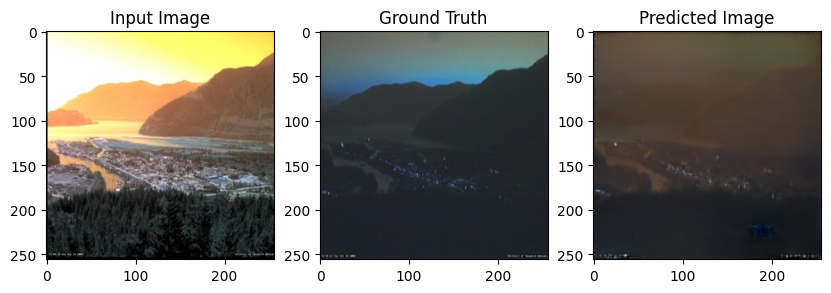

Models saved : gmodel_18000 , dmodel_18000


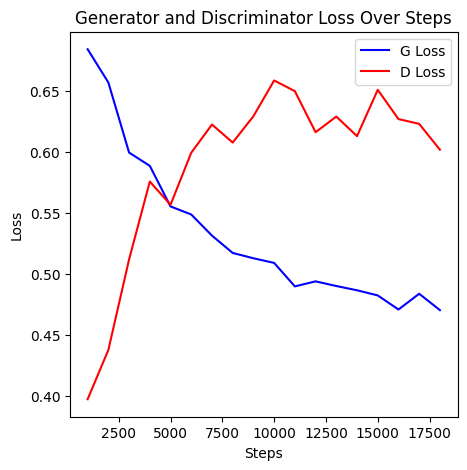

Step 18000/127560  Gen_loss: 0.398  Dis_loss: 0.023 Time: 19ms
Step 18001/127560  Gen_loss: 0.15  Dis_loss: 1.677 Time: 19ms
Step 18002/127560  Gen_loss: 0.629  Dis_loss: 0.285 Time: 20ms
Step 18003/127560  Gen_loss: 0.463  Dis_loss: 0.631 Time: 20ms
Step 18004/127560  Gen_loss: 0.399  Dis_loss: 0.055 Time: 20ms
Step 18005/127560  Gen_loss: 0.468  Dis_loss: 0.346 Time: 19ms
Step 18006/127560  Gen_loss: 0.515  Dis_loss: 0.261 Time: 19ms
Step 18007/127560  Gen_loss: 0.099  Dis_loss: 0.925 Time: 19ms
Step 18008/127560  Gen_loss: 0.347  Dis_loss: 1.479 Time: 19ms
Step 18009/127560  Gen_loss: 0.19  Dis_loss: 1.721 Time: 19ms
Step 18010/127560  Gen_loss: 0.346  Dis_loss: 0.474 Time: 19ms
Step 18011/127560  Gen_loss: 0.447  Dis_loss: 0.084 Time: 19ms
Step 18012/127560  Gen_loss: 0.759  Dis_loss: 0.075 Time: 20ms
Step 18013/127560  Gen_loss: 0.716  Dis_loss: 0.514 Time: 19ms
Step 18014/127560  Gen_loss: 0.178  Dis_loss: 0.813 Time: 19ms
Step 18015/127560  Gen_loss: 0.542  Dis_loss: 0.591 Time:

Step 18131/127560  Gen_loss: 0.248  Dis_loss: 0.216 Time: 19ms
Step 18132/127560  Gen_loss: 0.187  Dis_loss: 0.176 Time: 19ms
Step 18133/127560  Gen_loss: 0.399  Dis_loss: 0.087 Time: 20ms
Step 18134/127560  Gen_loss: 0.192  Dis_loss: 0.148 Time: 19ms
Step 18135/127560  Gen_loss: 0.91  Dis_loss: 0.032 Time: 19ms
Step 18136/127560  Gen_loss: 0.495  Dis_loss: 0.172 Time: 19ms
Step 18137/127560  Gen_loss: 0.726  Dis_loss: 0.356 Time: 19ms
Step 18138/127560  Gen_loss: 0.186  Dis_loss: 1.487 Time: 19ms
Step 18139/127560  Gen_loss: 0.642  Dis_loss: 0.136 Time: 19ms
Step 18140/127560  Gen_loss: 0.724  Dis_loss: 0.213 Time: 19ms
Step 18141/127560  Gen_loss: 0.463  Dis_loss: 0.346 Time: 19ms
Step 18142/127560  Gen_loss: 0.272  Dis_loss: 1.764 Time: 19ms
Step 18143/127560  Gen_loss: 0.717  Dis_loss: 0.997 Time: 19ms
Step 18144/127560  Gen_loss: 0.351  Dis_loss: 0.689 Time: 19ms
Step 18145/127560  Gen_loss: 0.418  Dis_loss: 1.519 Time: 20ms
Step 18146/127560  Gen_loss: 0.421  Dis_loss: 1.082 Time

Step 18262/127560  Gen_loss: 0.647  Dis_loss: 0.527 Time: 20ms
Step 18263/127560  Gen_loss: 0.337  Dis_loss: 0.382 Time: 19ms
Step 18264/127560  Gen_loss: 0.183  Dis_loss: 0.54 Time: 20ms
Step 18265/127560  Gen_loss: 0.339  Dis_loss: 0.63 Time: 19ms
Step 18266/127560  Gen_loss: 0.697  Dis_loss: 0.46 Time: 19ms
Step 18267/127560  Gen_loss: 0.38  Dis_loss: 0.326 Time: 20ms
Step 18268/127560  Gen_loss: 0.577  Dis_loss: 0.255 Time: 20ms
Step 18269/127560  Gen_loss: 0.63  Dis_loss: 0.689 Time: 20ms
Step 18270/127560  Gen_loss: 0.373  Dis_loss: 0.064 Time: 19ms
Step 18271/127560  Gen_loss: 0.231  Dis_loss: 1.342 Time: 18ms
Step 18272/127560  Gen_loss: 0.309  Dis_loss: 1.175 Time: 20ms
Step 18273/127560  Gen_loss: 0.514  Dis_loss: 1.113 Time: 19ms
Step 18274/127560  Gen_loss: 0.971  Dis_loss: 1.295 Time: 19ms
Step 18275/127560  Gen_loss: 0.843  Dis_loss: 0.087 Time: 22ms
Step 18276/127560  Gen_loss: 0.215  Dis_loss: 0.079 Time: 20ms
Step 18277/127560  Gen_loss: 0.41  Dis_loss: 0.213 Time: 19m

Step 18393/127560  Gen_loss: 0.171  Dis_loss: 0.864 Time: 20ms
Step 18394/127560  Gen_loss: 0.734  Dis_loss: 0.922 Time: 22ms
Step 18395/127560  Gen_loss: 0.512  Dis_loss: 0.45 Time: 19ms
Step 18396/127560  Gen_loss: 0.504  Dis_loss: 0.768 Time: 19ms
Step 18397/127560  Gen_loss: 0.377  Dis_loss: 0.241 Time: 19ms
Step 18398/127560  Gen_loss: 0.35  Dis_loss: 0.551 Time: 20ms
Step 18399/127560  Gen_loss: 0.16  Dis_loss: 0.574 Time: 20ms
Step 18400/127560  Gen_loss: 0.208  Dis_loss: 3.965 Time: 20ms
Step 18401/127560  Gen_loss: 0.197  Dis_loss: 1.987 Time: 19ms
Step 18402/127560  Gen_loss: 0.587  Dis_loss: 0.572 Time: 19ms
Step 18403/127560  Gen_loss: 0.87  Dis_loss: 0.289 Time: 20ms
Step 18404/127560  Gen_loss: 0.447  Dis_loss: 0.393 Time: 20ms
Step 18405/127560  Gen_loss: 0.454  Dis_loss: 0.756 Time: 19ms
Step 18406/127560  Gen_loss: 0.737  Dis_loss: 0.24 Time: 19ms
Step 18407/127560  Gen_loss: 0.453  Dis_loss: 0.373 Time: 20ms
Step 18408/127560  Gen_loss: 0.347  Dis_loss: 0.228 Time: 19

Step 18524/127560  Gen_loss: 0.313  Dis_loss: 0.409 Time: 20ms
Step 18525/127560  Gen_loss: 0.329  Dis_loss: 0.561 Time: 20ms
Step 18526/127560  Gen_loss: 0.288  Dis_loss: 0.574 Time: 20ms
Step 18527/127560  Gen_loss: 0.549  Dis_loss: 0.287 Time: 19ms
Step 18528/127560  Gen_loss: 0.583  Dis_loss: 0.298 Time: 19ms
Step 18529/127560  Gen_loss: 0.182  Dis_loss: 1.163 Time: 19ms
Step 18530/127560  Gen_loss: 0.359  Dis_loss: 0.388 Time: 19ms
Step 18531/127560  Gen_loss: 0.25  Dis_loss: 0.609 Time: 20ms
Step 18532/127560  Gen_loss: 0.329  Dis_loss: 0.862 Time: 19ms
Step 18533/127560  Gen_loss: 0.1  Dis_loss: 1.725 Time: 19ms
Step 18534/127560  Gen_loss: 0.615  Dis_loss: 0.273 Time: 19ms
Step 18535/127560  Gen_loss: 0.284  Dis_loss: 1.396 Time: 20ms
Step 18536/127560  Gen_loss: 0.481  Dis_loss: 0.483 Time: 19ms
Step 18537/127560  Gen_loss: 0.51  Dis_loss: 0.197 Time: 19ms
Step 18538/127560  Gen_loss: 0.204  Dis_loss: 0.789 Time: 20ms
Step 18539/127560  Gen_loss: 0.473  Dis_loss: 0.472 Time: 2

Step 18655/127560  Gen_loss: 0.634  Dis_loss: 0.554 Time: 22ms
Step 18656/127560  Gen_loss: 0.295  Dis_loss: 1.445 Time: 20ms
Step 18657/127560  Gen_loss: 0.321  Dis_loss: 1.129 Time: 21ms
Step 18658/127560  Gen_loss: 0.512  Dis_loss: 0.612 Time: 21ms
Step 18659/127560  Gen_loss: 0.438  Dis_loss: 0.804 Time: 20ms
Step 18660/127560  Gen_loss: 0.388  Dis_loss: 0.374 Time: 20ms
Step 18661/127560  Gen_loss: 0.633  Dis_loss: 0.425 Time: 19ms
Step 18662/127560  Gen_loss: 0.477  Dis_loss: 0.125 Time: 19ms
Step 18663/127560  Gen_loss: 0.23  Dis_loss: 0.832 Time: 20ms
Step 18664/127560  Gen_loss: 0.89  Dis_loss: 0.364 Time: 19ms
Step 18665/127560  Gen_loss: 0.265  Dis_loss: 2.977 Time: 20ms
Step 18666/127560  Gen_loss: 0.443  Dis_loss: 0.568 Time: 20ms
Step 18667/127560  Gen_loss: 0.2  Dis_loss: 0.227 Time: 20ms
Step 18668/127560  Gen_loss: 0.424  Dis_loss: 0.39 Time: 19ms
Step 18669/127560  Gen_loss: 1.028  Dis_loss: 0.146 Time: 19ms
Step 18670/127560  Gen_loss: 0.535  Dis_loss: 0.462 Time: 20

Step 18786/127560  Gen_loss: 0.634  Dis_loss: 1.55 Time: 20ms
Step 18787/127560  Gen_loss: 0.209  Dis_loss: 2.832 Time: 20ms
Step 18788/127560  Gen_loss: 0.454  Dis_loss: 0.504 Time: 19ms
Step 18789/127560  Gen_loss: 0.645  Dis_loss: 1.724 Time: 20ms
Step 18790/127560  Gen_loss: 0.291  Dis_loss: 0.682 Time: 19ms
Step 18791/127560  Gen_loss: 0.294  Dis_loss: 0.396 Time: 20ms
Step 18792/127560  Gen_loss: 0.448  Dis_loss: 0.475 Time: 19ms
Step 18793/127560  Gen_loss: 0.5  Dis_loss: 0.637 Time: 21ms
Step 18794/127560  Gen_loss: 0.139  Dis_loss: 1.291 Time: 20ms
Step 18795/127560  Gen_loss: 0.457  Dis_loss: 1.093 Time: 19ms
Step 18796/127560  Gen_loss: 0.736  Dis_loss: 0.476 Time: 20ms
Step 18797/127560  Gen_loss: 0.298  Dis_loss: 0.847 Time: 21ms
Step 18798/127560  Gen_loss: 0.557  Dis_loss: 0.465 Time: 19ms
Step 18799/127560  Gen_loss: 0.65  Dis_loss: 0.532 Time: 21ms
Step 18800/127560  Gen_loss: 0.226  Dis_loss: 0.674 Time: 20ms
Step 18801/127560  Gen_loss: 0.31  Dis_loss: 0.6 Time: 20ms

Step 18917/127560  Gen_loss: 0.488  Dis_loss: 0.494 Time: 20ms
Step 18918/127560  Gen_loss: 0.375  Dis_loss: 0.126 Time: 20ms
Step 18919/127560  Gen_loss: 0.284  Dis_loss: 0.503 Time: 20ms
Step 18920/127560  Gen_loss: 0.492  Dis_loss: 0.268 Time: 20ms
Step 18921/127560  Gen_loss: 0.601  Dis_loss: 0.244 Time: 20ms
Step 18922/127560  Gen_loss: 0.529  Dis_loss: 0.404 Time: 19ms
Step 18923/127560  Gen_loss: 0.429  Dis_loss: 0.443 Time: 20ms
Step 18924/127560  Gen_loss: 0.534  Dis_loss: 0.894 Time: 21ms
Step 18925/127560  Gen_loss: 0.268  Dis_loss: 0.424 Time: 19ms
Step 18926/127560  Gen_loss: 0.849  Dis_loss: 0.257 Time: 19ms
Step 18927/127560  Gen_loss: 0.465  Dis_loss: 0.228 Time: 19ms
Step 18928/127560  Gen_loss: 0.402  Dis_loss: 0.497 Time: 19ms
Step 18929/127560  Gen_loss: 0.204  Dis_loss: 0.268 Time: 19ms
Step 18930/127560  Gen_loss: 0.313  Dis_loss: 0.412 Time: 19ms
Step 18931/127560  Gen_loss: 0.282  Dis_loss: 0.438 Time: 20ms
Step 18932/127560  Gen_loss: 0.447  Dis_loss: 0.51 Time

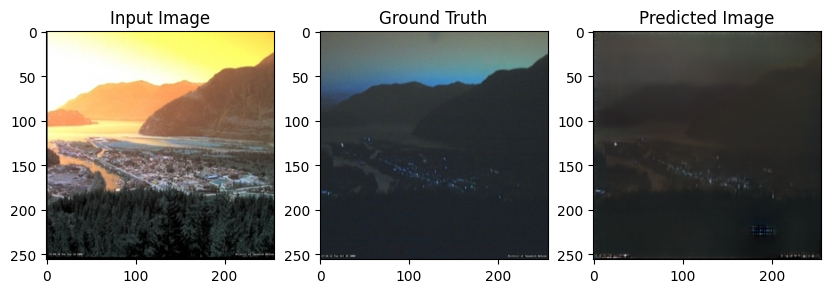

Models saved : gmodel_19000 , dmodel_19000


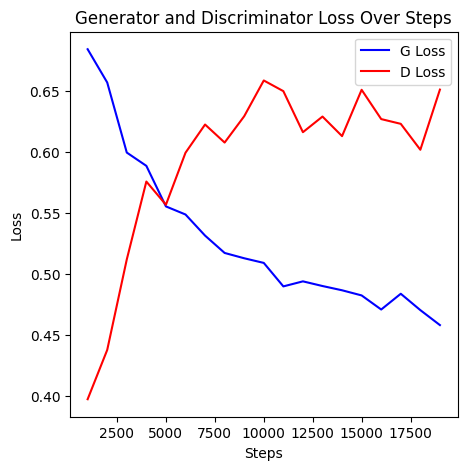

Step 19000/127560  Gen_loss: 0.411  Dis_loss: 0.939 Time: 21ms
Step 19001/127560  Gen_loss: 0.286  Dis_loss: 1.517 Time: 20ms
Step 19002/127560  Gen_loss: 0.501  Dis_loss: 0.504 Time: 20ms
Step 19003/127560  Gen_loss: 0.813  Dis_loss: 0.152 Time: 20ms
Step 19004/127560  Gen_loss: 0.646  Dis_loss: 0.295 Time: 20ms
Step 19005/127560  Gen_loss: 0.36  Dis_loss: 1.93 Time: 20ms
Step 19006/127560  Gen_loss: 0.635  Dis_loss: 0.44 Time: 19ms
Step 19007/127560  Gen_loss: 0.445  Dis_loss: 1.736 Time: 19ms
Step 19008/127560  Gen_loss: 0.797  Dis_loss: 0.044 Time: 20ms
Step 19009/127560  Gen_loss: 0.477  Dis_loss: 0.045 Time: 20ms
Step 19010/127560  Gen_loss: 0.622  Dis_loss: 0.535 Time: 19ms
Step 19011/127560  Gen_loss: 0.495  Dis_loss: 0.357 Time: 20ms
Step 19012/127560  Gen_loss: 0.914  Dis_loss: 0.779 Time: 20ms
Step 19013/127560  Gen_loss: 0.702  Dis_loss: 0.076 Time: 20ms
Step 19014/127560  Gen_loss: 0.342  Dis_loss: 0.115 Time: 19ms
Step 19015/127560  Gen_loss: 0.533  Dis_loss: 0.179 Time: 

Step 19131/127560  Gen_loss: 0.222  Dis_loss: 1.833 Time: 19ms
Step 19132/127560  Gen_loss: 0.533  Dis_loss: 0.144 Time: 19ms
Step 19133/127560  Gen_loss: 0.51  Dis_loss: 0.664 Time: 19ms
Step 19134/127560  Gen_loss: 0.459  Dis_loss: 0.007 Time: 20ms
Step 19135/127560  Gen_loss: 0.791  Dis_loss: 0.088 Time: 20ms
Step 19136/127560  Gen_loss: 0.567  Dis_loss: 0.466 Time: 19ms
Step 19137/127560  Gen_loss: 0.516  Dis_loss: 0.134 Time: 20ms
Step 19138/127560  Gen_loss: 0.625  Dis_loss: 0.158 Time: 19ms
Step 19139/127560  Gen_loss: 0.353  Dis_loss: 0.51 Time: 19ms
Step 19140/127560  Gen_loss: 0.275  Dis_loss: 0.088 Time: 20ms
Step 19141/127560  Gen_loss: 0.495  Dis_loss: 0.083 Time: 20ms
Step 19142/127560  Gen_loss: 0.248  Dis_loss: 2.453 Time: 19ms
Step 19143/127560  Gen_loss: 0.493  Dis_loss: 0.146 Time: 20ms
Step 19144/127560  Gen_loss: 0.401  Dis_loss: 0.128 Time: 20ms
Step 19145/127560  Gen_loss: 0.39  Dis_loss: 0.306 Time: 20ms
Step 19146/127560  Gen_loss: 0.499  Dis_loss: 0.064 Time: 

Step 19262/127560  Gen_loss: 0.462  Dis_loss: 0.056 Time: 19ms
Step 19263/127560  Gen_loss: 0.852  Dis_loss: 0.328 Time: 19ms
Step 19264/127560  Gen_loss: 0.34  Dis_loss: 0.411 Time: 19ms
Step 19265/127560  Gen_loss: 0.282  Dis_loss: 0.127 Time: 21ms
Step 19266/127560  Gen_loss: 0.262  Dis_loss: 2.25 Time: 19ms
Step 19267/127560  Gen_loss: 0.623  Dis_loss: 0.161 Time: 20ms
Step 19268/127560  Gen_loss: 0.419  Dis_loss: 0.515 Time: 19ms
Step 19269/127560  Gen_loss: 0.782  Dis_loss: 0.478 Time: 19ms
Step 19270/127560  Gen_loss: 0.385  Dis_loss: 0.305 Time: 20ms
Step 19271/127560  Gen_loss: 0.501  Dis_loss: 1.28 Time: 20ms
Step 19272/127560  Gen_loss: 0.8  Dis_loss: 0.186 Time: 19ms
Step 19273/127560  Gen_loss: 0.522  Dis_loss: 0.33 Time: 20ms
Step 19274/127560  Gen_loss: 0.696  Dis_loss: 0.705 Time: 20ms
Step 19275/127560  Gen_loss: 0.47  Dis_loss: 0.076 Time: 20ms
Step 19276/127560  Gen_loss: 0.548  Dis_loss: 0.102 Time: 20ms
Step 19277/127560  Gen_loss: 0.479  Dis_loss: 0.616 Time: 21ms

Step 19393/127560  Gen_loss: 0.507  Dis_loss: 0.153 Time: 20ms
Step 19394/127560  Gen_loss: 0.51  Dis_loss: 0.394 Time: 22ms
Step 19395/127560  Gen_loss: 0.588  Dis_loss: 0.085 Time: 20ms
Step 19396/127560  Gen_loss: 0.362  Dis_loss: 0.438 Time: 20ms
Step 19397/127560  Gen_loss: 0.365  Dis_loss: 0.399 Time: 20ms
Step 19398/127560  Gen_loss: 0.657  Dis_loss: 0.12 Time: 20ms
Step 19399/127560  Gen_loss: 0.547  Dis_loss: 0.141 Time: 19ms
Step 19400/127560  Gen_loss: 0.569  Dis_loss: 0.308 Time: 19ms
Step 19401/127560  Gen_loss: 0.393  Dis_loss: 0.862 Time: 20ms
Step 19402/127560  Gen_loss: 0.333  Dis_loss: 0.166 Time: 20ms
Step 19403/127560  Gen_loss: 0.584  Dis_loss: 0.419 Time: 19ms
Step 19404/127560  Gen_loss: 0.493  Dis_loss: 0.044 Time: 19ms
Step 19405/127560  Gen_loss: 0.417  Dis_loss: 0.109 Time: 19ms
Step 19406/127560  Gen_loss: 0.41  Dis_loss: 0.222 Time: 32ms
Step 19407/127560  Gen_loss: 0.479  Dis_loss: 0.82 Time: 19ms
Step 19408/127560  Gen_loss: 0.511  Dis_loss: 0.165 Time: 2

Step 19524/127560  Gen_loss: 0.572  Dis_loss: 0.339 Time: 20ms
Step 19525/127560  Gen_loss: 0.436  Dis_loss: 0.816 Time: 20ms
Step 19526/127560  Gen_loss: 0.229  Dis_loss: 3.515 Time: 21ms
Step 19527/127560  Gen_loss: 0.444  Dis_loss: 0.038 Time: 20ms
Step 19528/127560  Gen_loss: 0.46  Dis_loss: 0.044 Time: 19ms
Step 19529/127560  Gen_loss: 0.485  Dis_loss: 0.043 Time: 19ms
Step 19530/127560  Gen_loss: 0.381  Dis_loss: 0.922 Time: 19ms
Step 19531/127560  Gen_loss: 0.399  Dis_loss: 1.674 Time: 20ms
Step 19532/127560  Gen_loss: 0.48  Dis_loss: 0.589 Time: 20ms
Step 19533/127560  Gen_loss: 0.661  Dis_loss: 0.667 Time: 19ms
Step 19534/127560  Gen_loss: 0.741  Dis_loss: 0.455 Time: 19ms
Step 19535/127560  Gen_loss: 0.587  Dis_loss: 0.809 Time: 19ms
Step 19536/127560  Gen_loss: 0.64  Dis_loss: 0.557 Time: 19ms
Step 19537/127560  Gen_loss: 0.498  Dis_loss: 0.275 Time: 19ms
Step 19538/127560  Gen_loss: 0.486  Dis_loss: 0.26 Time: 20ms
Step 19539/127560  Gen_loss: 0.486  Dis_loss: 0.522 Time: 2

Step 19655/127560  Gen_loss: 0.302  Dis_loss: 0.803 Time: 20ms
Step 19656/127560  Gen_loss: 0.504  Dis_loss: 0.479 Time: 22ms
Step 19657/127560  Gen_loss: 0.45  Dis_loss: 0.346 Time: 19ms
Step 19658/127560  Gen_loss: 0.281  Dis_loss: 0.059 Time: 18ms
Step 19659/127560  Gen_loss: 0.673  Dis_loss: 0.549 Time: 20ms
Step 19660/127560  Gen_loss: 0.416  Dis_loss: 0.268 Time: 19ms
Step 19661/127560  Gen_loss: 0.115  Dis_loss: 1.562 Time: 19ms
Step 19662/127560  Gen_loss: 0.412  Dis_loss: 1.477 Time: 19ms
Step 19663/127560  Gen_loss: 0.477  Dis_loss: 0.168 Time: 19ms
Step 19664/127560  Gen_loss: 0.604  Dis_loss: 0.102 Time: 19ms
Step 19665/127560  Gen_loss: 0.305  Dis_loss: 0.363 Time: 20ms
Step 19666/127560  Gen_loss: 0.416  Dis_loss: 0.276 Time: 19ms
Step 19667/127560  Gen_loss: 0.625  Dis_loss: 0.437 Time: 19ms
Step 19668/127560  Gen_loss: 0.265  Dis_loss: 0.407 Time: 19ms
Step 19669/127560  Gen_loss: 0.473  Dis_loss: 0.099 Time: 20ms
Step 19670/127560  Gen_loss: 0.532  Dis_loss: 0.386 Time

Step 19786/127560  Gen_loss: 0.48  Dis_loss: 0.542 Time: 19ms
Step 19787/127560  Gen_loss: 0.468  Dis_loss: 1.083 Time: 19ms
Step 19788/127560  Gen_loss: 0.891  Dis_loss: 0.333 Time: 19ms
Step 19789/127560  Gen_loss: 0.363  Dis_loss: 0.197 Time: 20ms
Step 19790/127560  Gen_loss: 0.588  Dis_loss: 0.533 Time: 19ms
Step 19791/127560  Gen_loss: 0.381  Dis_loss: 0.445 Time: 19ms
Step 19792/127560  Gen_loss: 0.204  Dis_loss: 1.286 Time: 20ms
Step 19793/127560  Gen_loss: 0.453  Dis_loss: 0.957 Time: 19ms
Step 19794/127560  Gen_loss: 0.541  Dis_loss: 0.135 Time: 19ms
Step 19795/127560  Gen_loss: 0.607  Dis_loss: 0.492 Time: 20ms
Step 19796/127560  Gen_loss: 0.116  Dis_loss: 1.203 Time: 19ms
Step 19797/127560  Gen_loss: 0.759  Dis_loss: 1.483 Time: 19ms
Step 19798/127560  Gen_loss: 0.37  Dis_loss: 1.718 Time: 19ms
Step 19799/127560  Gen_loss: 0.336  Dis_loss: 0.884 Time: 19ms
Step 19800/127560  Gen_loss: 0.383  Dis_loss: 0.26 Time: 19ms
Step 19801/127560  Gen_loss: 0.682  Dis_loss: 0.566 Time: 

Step 19917/127560  Gen_loss: 0.403  Dis_loss: 0.628 Time: 19ms
Step 19918/127560  Gen_loss: 0.432  Dis_loss: 0.182 Time: 19ms
Step 19919/127560  Gen_loss: 0.483  Dis_loss: 0.14 Time: 20ms
Step 19920/127560  Gen_loss: 0.517  Dis_loss: 0.21 Time: 19ms
Step 19921/127560  Gen_loss: 0.916  Dis_loss: 0.275 Time: 19ms
Step 19922/127560  Gen_loss: 0.718  Dis_loss: 0.381 Time: 19ms
Step 19923/127560  Gen_loss: 0.763  Dis_loss: 0.625 Time: 21ms
Step 19924/127560  Gen_loss: 0.146  Dis_loss: 0.692 Time: 20ms
Step 19925/127560  Gen_loss: 0.521  Dis_loss: 0.626 Time: 19ms
Step 19926/127560  Gen_loss: 0.417  Dis_loss: 0.584 Time: 20ms
Step 19927/127560  Gen_loss: 0.483  Dis_loss: 0.15 Time: 20ms
Step 19928/127560  Gen_loss: 0.906  Dis_loss: 0.487 Time: 20ms
Step 19929/127560  Gen_loss: 0.694  Dis_loss: 0.532 Time: 19ms
Step 19930/127560  Gen_loss: 0.107  Dis_loss: 1.507 Time: 19ms
Step 19931/127560  Gen_loss: 0.188  Dis_loss: 1.226 Time: 19ms
Step 19932/127560  Gen_loss: 0.907  Dis_loss: 0.724 Time: 

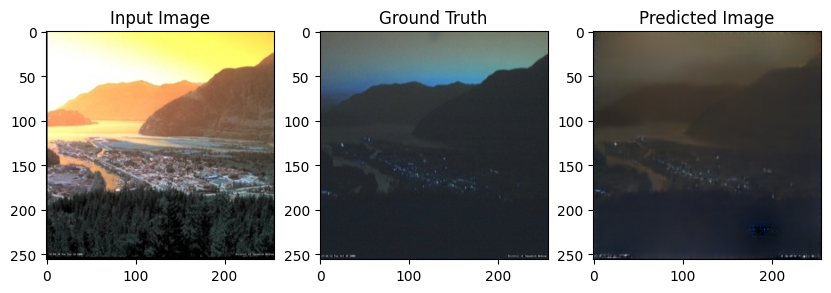

Models saved : gmodel_20000 , dmodel_20000


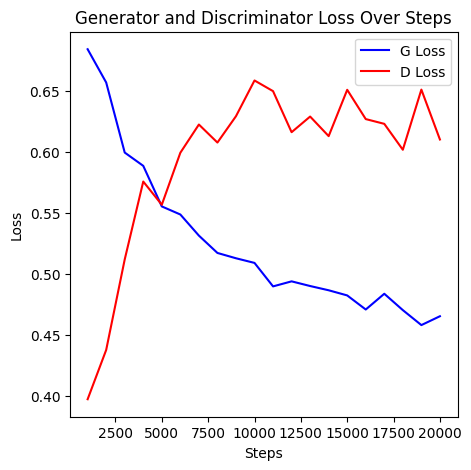

Step 20000/127560  Gen_loss: 0.435  Dis_loss: 2.596 Time: 20ms
Step 20001/127560  Gen_loss: 0.224  Dis_loss: 0.235 Time: 19ms
Step 20002/127560  Gen_loss: 0.557  Dis_loss: 0.168 Time: 20ms
Step 20003/127560  Gen_loss: 0.187  Dis_loss: 1.168 Time: 19ms
Step 20004/127560  Gen_loss: 0.656  Dis_loss: 0.859 Time: 20ms
Step 20005/127560  Gen_loss: 0.465  Dis_loss: 0.367 Time: 19ms
Step 20006/127560  Gen_loss: 0.298  Dis_loss: 1.02 Time: 19ms
Step 20007/127560  Gen_loss: 0.548  Dis_loss: 0.327 Time: 19ms
Step 20008/127560  Gen_loss: 0.418  Dis_loss: 3.828 Time: 19ms
Step 20009/127560  Gen_loss: 0.626  Dis_loss: 0.958 Time: 20ms
Step 20010/127560  Gen_loss: 0.225  Dis_loss: 0.45 Time: 21ms
Step 20011/127560  Gen_loss: 0.385  Dis_loss: 0.984 Time: 19ms
Step 20012/127560  Gen_loss: 0.498  Dis_loss: 0.92 Time: 19ms
Step 20013/127560  Gen_loss: 0.193  Dis_loss: 1.37 Time: 19ms
Step 20014/127560  Gen_loss: 0.583  Dis_loss: 0.152 Time: 20ms
Step 20015/127560  Gen_loss: 0.141  Dis_loss: 1.07 Time: 19

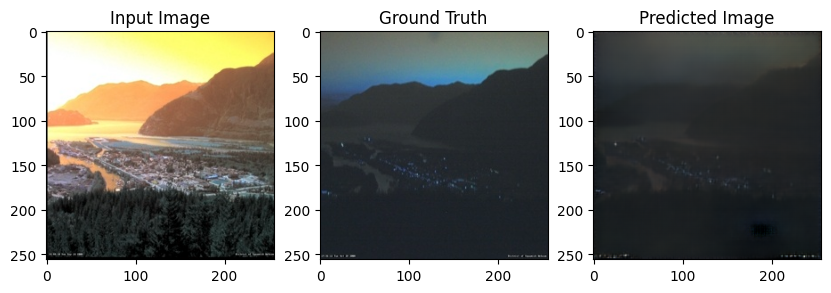

In [17]:
#training
with tf.device("gpu"):
    num_epochs = 15
    train(dataset, num_epochs)

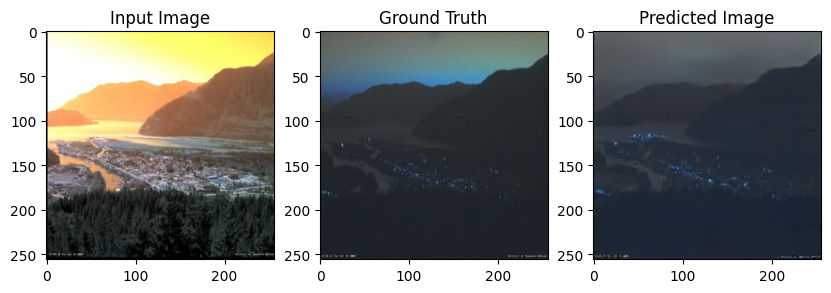

In [18]:
#model performance check
display_per()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


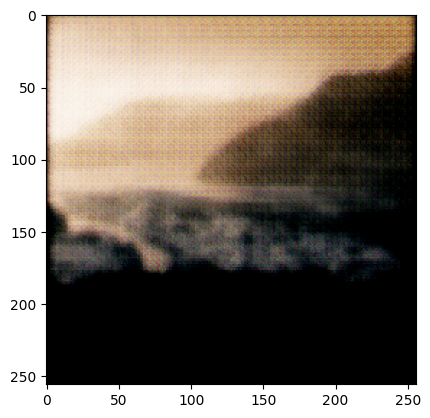

In [28]:
#first output
plt.imshow(ypred)

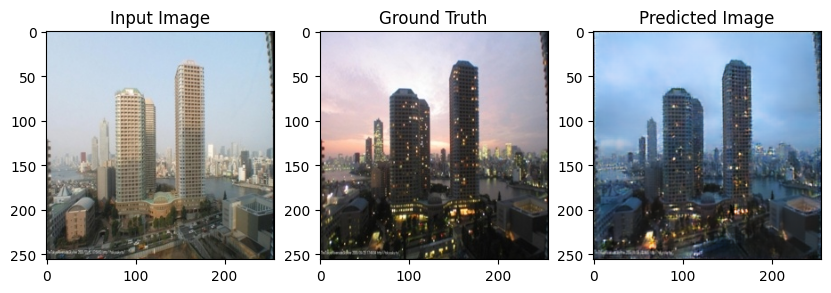

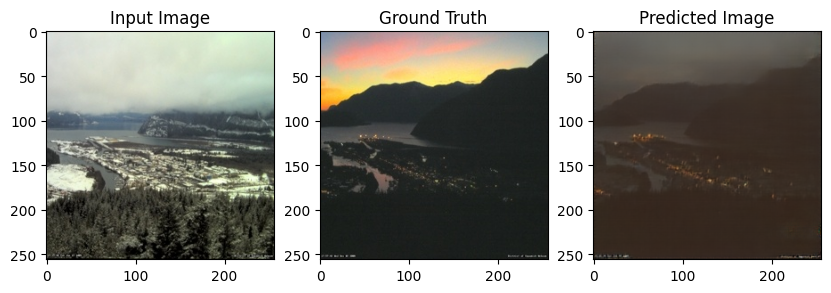

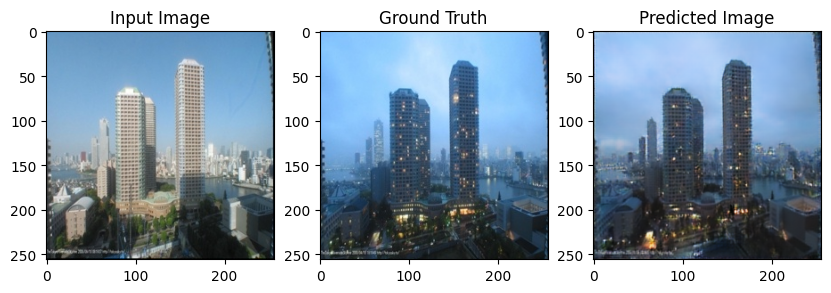

In [17]:
import cv2
for i in range(3):
    n = np.random.randint(0, 1000)
    y_image = y[n:n+5][3]
    x_image = X[n:n+5][3]
    pred_image = generator(y[n:n+5], training=True)[3]
    pred_image = (pred_image * 0.5) + 0.5
    y_image = (y_image * 0.5) + 0.5
    x_image = (x_image * 0.5) + 0.5
    pred_image = cv2.cvtColor(np.array(pred_image), cv2.COLOR_BGR2RGB)
    y_image = cv2.cvtColor(y_image, cv2.COLOR_BGR2RGB)
    x_image = cv2.cvtColor(x_image, cv2.COLOR_BGR2RGB)
    fig, axs = plt.subplots(1, 3, figsize=(10, 10))
    axs[0].imshow(y_image)
    axs[0].set_title('Input Image')
    axs[1].imshow(x_image)
    axs[1].set_title('Ground Truth')
    axs[2].imshow(pred_image)
    axs[2].set_title('Predicted Image')
plt.show()

In [31]:
def plot_loss_over_steps(g_loss, d_loss, steps):
    plt.figure(figsize=(5,5))
    plt.plot(steps, g_loss, label='G Loss', color='blue')
    plt.plot(steps, d_loss, label='D Loss', color='red')
    plt.xlabel('Steps')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Discriminator Loss Over Steps')
    plt.show()

In [20]:
r1 = np.load("Metrics/8116.npy")

In [32]:
results = np.load("Metrics/3007.npy")
results.T[20:]
tests = np.vstack((r1.T, results.T[20:]))

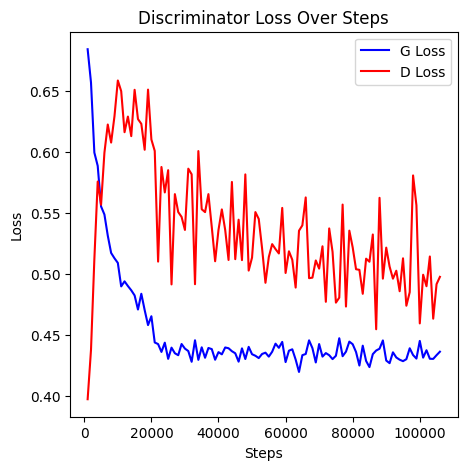

In [33]:
import matplotlib.pyplot as plt
results = tests.T
g_loss = []
d_loss = []
steps = []
for i in results.T:
    steps.append(i[0])
    g_loss.append(i[1])
    d_loss.append(i[2])
# Call the function to plot
plot_loss_over_steps(g_loss, d_loss, steps)

In [70]:
img.shape

(256, 256, 3)